In [3]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string
import scipy.stats
## plotting details
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['axes.color_cycle'] =['#d7191c','#fc8d59','#999999','#a6d96a','#1a9641','#3288bd']
matplotlib.rcParams['lines.linewidth'] = 3.0

home_dir = os.getenv("HOME")
#source activate python2
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES

# import ibutton data cleaned and bias corrected, calculated with CharacteristicsBaltimoreUHI
tempDF=pd.read_csv('data/correctedibuttontemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')['2016-07-01':'2016-08-30']#.first()
tempDF.columns = tempDF.columns.astype(int)
filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)

# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)

#model_bwi = pd.read_csv('data/UCM+SST_d03_allpoints_plusbwi.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')#[tempDF.index[0]:tempDF.index[-1]]

# other variables
model_allvars = pd.read_csv('UCM+SST_d03_allpoints_allvars.csv',header = [0,1], index_col=0,
                        parse_dates = [0], 
                   date_parser = date_parser,
                       skipinitialspace=True)#[tempDF.index[0]:tempDF.index[-1]]
model_allvars.columns.set_levels(model_allvars.columns.levels[1].astype(int), level = 1, inplace = True)
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
rnet = net_lw+net_sw

# landcover 
lcc_english = {
    #! 40 CLASS MODIS (Outside US, cats 1-20)/NLCD (US only, cats 21-40) LU characterization
    # downloaded from https://github.com/yyr/wrf/blob/master/phys/module_sf_pxlsm_data.F March 8 2018
    1: 'Evergreen Needleleaf Forest',
    2:  'Evergreen Broadleaf Forest',
    3:  'Deciduous Needleleaf Forest',
    4:   'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6:  'Closed Shrublands', 
    7:'Open Shrublands', 
    8: 'Woody Savanna', 
    9:'Savanna', 
    10: 'Grasslands', 
    11: 'Perminent Wetlands', 
    12: 'Croplands',
    13: 'Urban andBuilt-up', 
    14: 'Cropland/Natural Vegetation Mosaic', 
    15: 'Snow and Ice', 
    16: 'Barren or Sparsely Vegetated', 
    17:  'IGBP water', 
    18: 'unclassified', 
    19: 'fill value (normally ocean water)', 
    20: 'unclassified', 
    21: 'Open water', 
    22: 'Perennial Ice/snow', 
    23: 'Developed, Open space', 
    24:'Developed, Low Intensity', 
    25: 'Developed, Medium Intensity', 
    26: 'Developed, High Intensity', 
    27: 'Barren land', 
    28: 'Deciduous Forest', 
    29: 'Evergreen Forest', 
    30: 'Mixed Forest',
    31: 'Dwarf Scrub', 
    32:  'Shrub/Scrub', 
    33: 'Grassland/Herbaceous', 
    34: 'Sedge/Herbaceous',
    35: 'Lichens', 
    36: 'Moss', 
    37: 'Pasture/Hay',
    38: 'Cultivated Crops',
    39: 'Woody Wetland',
    40: 'Emergent Herbaceous Wetland',
}

lcc = pd.read_csv('data/UCM+SST_d03_landcover.csv').set_index('Unnamed: 0')# index = meta.index, columns=['LCC'])
lcc['LCC English'] =  [lcc_english[int(x)]for x in lcc.LCC]
lcc.head()
exp = 'UCM+SST'
dom = 'd03'
# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)
fname ='data/%s_%s_bwi.csv'%(exp,dom)
model_bwi = pd.read_csv(fname,parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
#model_bwi.columns = model_bwi.columns.astype(int)

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


In [ ]:
scipy.__version__

In [11]:
print('Pandas version: %s'%pd.__version__, 
      'Numpy version: %s'%np.__version__, 
     'Scipy version : %s'%scipy.__version__, 
      'xarray version: %s'%xr.__version__, 
      'wrf version: %s'%wrf.__version__,
     )

(u'Pandas version: 0.20.1', 'Numpy version: 1.11.3', 'Scipy version : 0.19.0', 'xarray version: 0.9.5', 'wrf version: 1.0.1')


In [ ]:
pripd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial

In [148]:
# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)
fname ='data/%s_%s_bwi.csv'%(exp,dom)
model_bwi = pd.read_csv(fname,parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
#model_bwi.columns = model_bwi.columns.astype(int)

In [18]:
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

In [604]:
f = '/Users/ascott47/mountpoint/wrf/out/UCM+SST/d01/wrfout_d01_2016-06-25_00:00:00'
dataset = Dataset(f)
low_res = getvar(dataset, "LU_INDEX")

f = '/Users/ascott47/mountpoint/wrf/out/UCM+SST/d02/wrfout_d01_2016-06-25_00:00:00'
dataset = Dataset(f)
med_res = getvar(dataset, "LU_INDEX")

In [608]:
low_res.XLONG.min(), low_res.XLONG.max()

(<xarray.DataArray 'XLONG' ()>
 array(-85.5911865234375)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLONG' ()>
 array(-68.0057373046875)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [609]:
low_res.XLAT.min(), low_res.XLAT.max()

(<xarray.DataArray 'XLAT' ()>
 array(32.28853225708008)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLAT' ()>
 array(44.98015594482422)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [610]:
med_res.XLONG.min(), med_res.XLONG.max()

(<xarray.DataArray 'XLONG' ()>
 array(-78.8524169921875)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLONG' ()>
 array(-73.356689453125)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [611]:
med_res.XLAT.min(), med_res.XLAT.max()

(<xarray.DataArray 'XLAT' ()>
 array(36.81785202026367)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25, <xarray.DataArray 'XLAT' ()>
 array(40.98936462402344)
 Coordinates:
     XTIME    float32 44640.0
     Time     datetime64[ns] 2016-06-25)

In [613]:
lu.XLONG.min(), lu.XLONG.max()

(<xarray.DataArray 'XLONG' ()>
 array(-77.65386962890625)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00, <xarray.DataArray 'XLONG' ()>
 array(-75.86077880859375)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00)

In [614]:
lu.XLAT.min(), lu.XLAT.max()

(<xarray.DataArray 'XLAT' ()>
 array(38.275142669677734)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00, <xarray.DataArray 'XLAT' ()>
 array(39.663047790527344)
 Coordinates:
     XTIME    float32 5400.0
     Time     datetime64[ns] 2016-05-28T18:00:00)

(<xarray.DataArray u'xy' ()>
 array(100)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.29813979, lon=-76.69014149)
     x_y           <U1 u'y', <xarray.DataArray u'xy' ()>
 array(128)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.28520643, lon=-76.54833725)
     x_y           <U1 u'y')

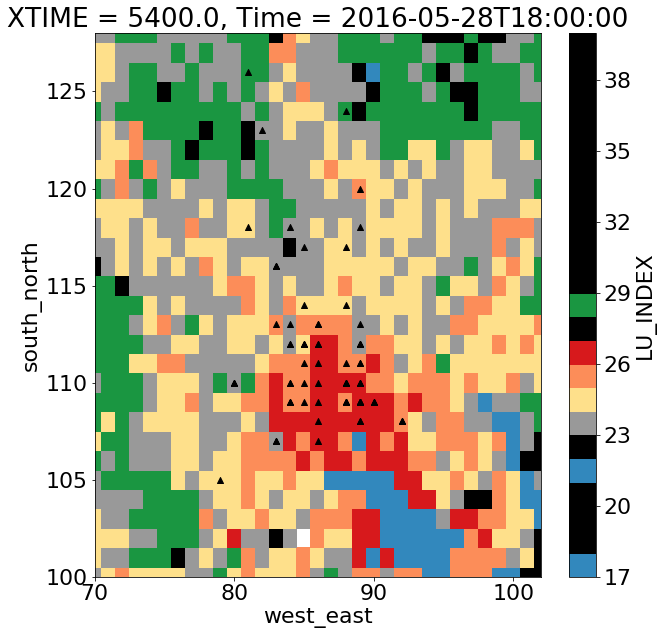

In [597]:
# Fig. 1: A map with insets, some points
# exp = 'UCM+SST'
# dom = 'd03'
# fpath = home_dir + '/mountpoint/wrf/out/'
# files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
# ds = Dataset(files[30*3])
# lu = getvar(ds, "LU_INDEX")
# all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
#                        meta['location:Longitude'].dropna().values)
color_dict ={26.: '#d7191c',
             25 : '#fc8d59',
             24: '#fee08b', #'yellow',
             23: '#999999',
             28: '#1a9641', 
             21: '#3288bd',
             17: '#3288bd'
            }
cmap = ['k' for x in range(17,40)]
#cmap = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30', '#762a83','#af8dc3','#e7d4e8',]

for x in color_dict.keys(): 
    x = int(x)
    cmap[x-17] = color_dict[x]
#lu.plot(levels = 24, cmap  = cm.tab20, figsize = [10,10])
lu.plot(levels = 24,  
        cmap = cmap, 
        vmin = 17, vmax =40, figsize = [10,10])
plt.scatter(all_pts[0], all_pts[1], marker = '^', color = 'k')
# plt.xlim(pts[0].values)
# plt.ylim(pts[1].values)
plt.xlim(pts[0][0]-10, pts[0][1]+10)
plt.ylim(pts[1][0]-10, pts[1][1]+20)
#plt.savefig('figures/map.png')

In [234]:
tempDF.max().max(), tempDF.max().argmax()

(48.0169743537, 2)

In [240]:
tempDF_uncorrected.max().max(), tempDF.max().argmax()

(47.546000000000006, 2)

In [254]:
tempDF[2].argmax()

Timestamp('2016-07-24 09:00:00', freq='H')

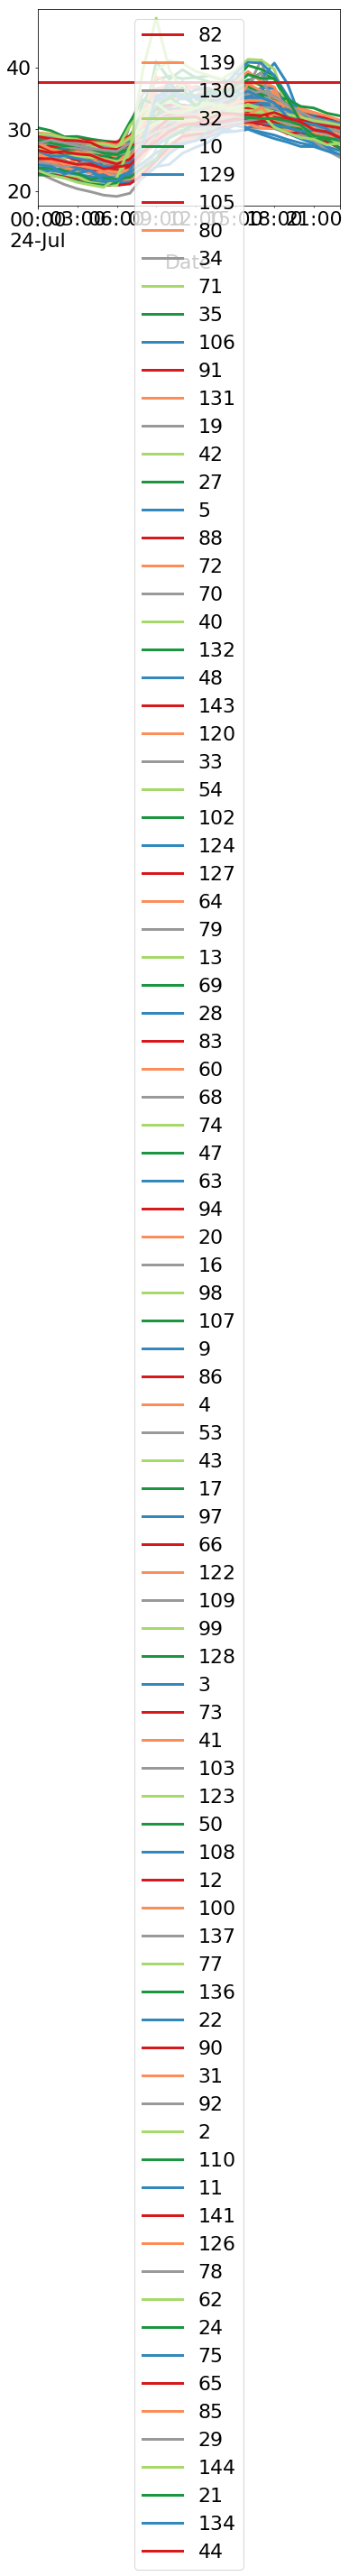

In [256]:
tempDF['2016-07-24'].plot()
plt.axhline(37.7)

In [242]:
tempDF.mean().mean()

26.951557506213774

In [243]:
tempDF_uncorrected.mean().mean()

27.186741987753912

In [245]:
tempDF.index[0]

Timestamp('2016-07-01 00:00:00', freq='H')

In [ ]:
te

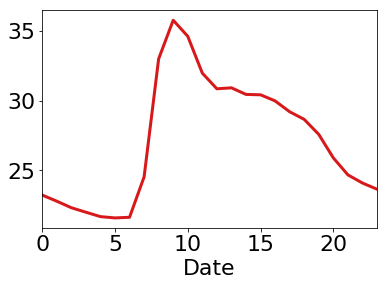

In [244]:
tempDF[2].groupby(tempDF.index.hour).mean().plot()

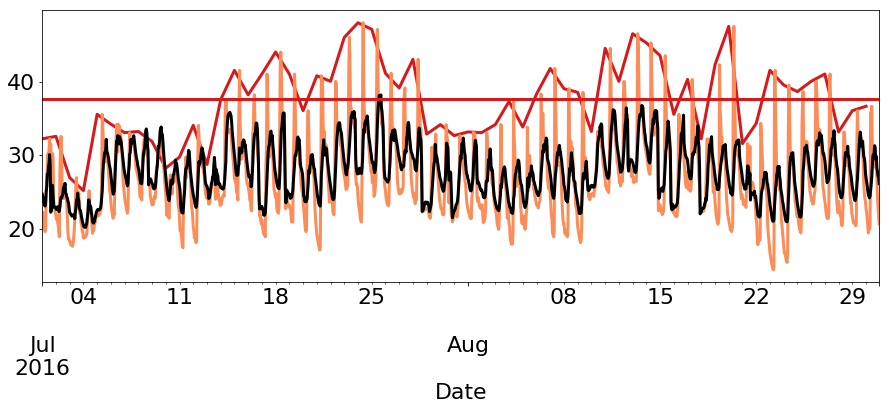

In [252]:
tempDF[2].resample('D').max().plot(figsize = [15,5])
tempDF[2].plot()
tempDF[97].plot(color = 'k')
plt.axhline(37.7)

In [250]:
meta.loc[2]

sensornumber                                                          2
meta:instanceID               uuid:b01f6b7b-2646-4911-a9f3-1821b2f3143e
oldsensornumber                                                       2
location:Latitude                                               39.3575
location:Longitude                                             -76.6586
location:Altitude                                                    80
location:Accuracy                                                     5
direction                                                             0
sunorshade                                                          sun
attachment                                                     deadwood
landcoverclass                                                    grass
vesasitenumber                                                       18
vesacategory                                                          o
picture               https://bmorecoolodk.appspot.com/view/bina

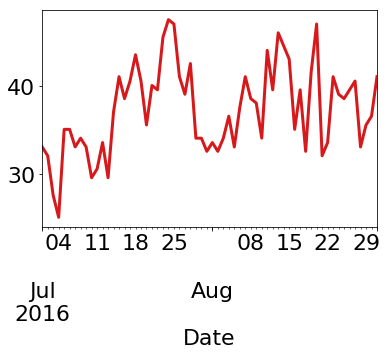

In [239]:
tempDF_uncorrected[2].resample('D').max().plot()

In [473]:
# check unique points 
# define points
a = np.array([pts[0].values, pts[1].values]).T
uniques = 0
# loop over all possible longitudes
for x in np.unique(a[:,0]): 
    # get all the points with the same longitude
    duplicate = a[a[:,0]==x]
    # add the number of unique latitudes within this long to the counter
    uniques = uniques + np.unique(duplicate[:,1]).shape[0]
print(uniques)

43


(2, 86)

In [493]:
# check duplicate points to ask how many points are in the same boxes
num_duplicate_points = [] # list of number of duplicate points
i = 0
# loop over all possible longitudes
for x in np.unique(a[:,0]): 
    # get the points with the same longitude
    duplicate = a[a[:,0]==x]
    # now see if those with the same lon have the same lat
    for y in duplicate[:,1]: 
        # see duplicates
        y_duplicate = duplicate[duplicate[:,1]==y]
        if y_duplicate.shape[0] > 1: 
            # append the number of duplicate points
            num_duplicate_points.append(y_duplicate.shape[0])
            #print(y_duplicate.shape[0])
#     # if the number of unique points is less than the total points, there are duplicates
#     if duplicate[:,1].shape[0] > np.unique(duplicate[:,1]).shape[0] :
#         # count number of unique lats within these unique lons
#         unique = np.unique(duplicate[:,1]).shape[0]
#         # count the total number of duplicate points, subtract the 
#         print(duplicate[:,1].shape[0]- unique)
#     #     if duplicate.shape[0] >0: 
# #         print(duplicate.shape)
print(num_duplicate_points)

[4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 4, 9, 4, 3, 4, 9, 9, 9, 9, 2, 2, 3, 3, 9, 9, 4, 2, 9, 2, 9, 3, 3, 3, 3, 3, 3]


In [498]:
np.mean(num_duplicate_points), np.median(num_duplicate_points) , np.std(num_duplicate_points)

(4.278688524590164, 3.0, 2.2841660783478224)

In [548]:
len(num_duplicate_points)

61

In [620]:
meta.shape

(91, 17)

In [631]:
(meta.loc[model.columns].landcoverclass=='impervious').sum()

24

In [632]:
(meta.loc[model.columns].landcoverclass=='grass').sum()

43

In [639]:
for l in meta.landcoverclass.unique(): 
    print(l,(meta.loc[model.columns].landcoverclass==l).sum() )

('impervious', 24)
('grass', 43)
('dirt', 13)
('grass impervious', 5)


In [638]:
for attach in meta.attachment.unique(): 
    print(attach, (meta.loc[model.columns].attachment==attach).sum())

('tree', 61)
('metal', 17)
('deadwood', 7)


In [641]:
for attach in meta.sunorshade.unique(): 
    print(attach, (meta.loc[model.columns].sunorshade==attach).sum())

('shade', 24)
('sun', 23)
('partial', 38)


In [2]:
# Station temperature/ibutton comparison 
# uncorrected data 
tempDF_uncorrected=pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')['2016-07-01':'2016-08-31']#.first()
tempDF_uncorrected.columns = tempDF_uncorrected.columns.astype('int')
# asos data 
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')
### rearrange asos into obs dataframe
for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

### set plotting details, like colors and linestyles
ibutton_linestyle = '-'
ibutton_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][-1]#'k'
asos_linestyle = '--'
asos_color = 'grey'#plt.rcParams['axes.prop_cycle'].by_key()['color'][1]#'blue'

# plt.figure(figsize = [15,5])
# #plot temp
# ax = plt.subplot(1,2,1)
# data = [tempDF_uncorrected['2016-07-01':'2016-08-31'][97], 
#         obs['2016-07-01':'2016-08-31']['urban'].dropna().values, 
#         tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97],
#         obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban'].dropna(), 
#         tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97],
#         obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban'].dropna(),         
#        ]
# #handles = plt.boxplot(data,positions=[0,1,2,3,4,5])
# handles = plt.boxplot(data[::2],positions=[0,1,2,3,4,5][::2], boxprops=(dict( linestyle=ibutton_linestyle,color='k')))
# handles2 = plt.boxplot(data[1::2],positions=[0,1,2,3,4,5][1::2], boxprops=(dict( linestyle=asos_linestyle,color='k')))
# labels = ['iButton, all hours', 'ASOS, all hours','iButton, 6am', 'ASOS,6am','iButton,4pm', 'ASOS, 4pm',]
# #x_handles = ax.set_xticklabels(labels,rotation='vertical')
# x_handles = plt.xticks([.5,2.5,4.5], ['All data', '6am data', '4pm data'])
# plt.xlim([-.5,5.5])

# handles = ax.boxplot(data[::2],positions=[0,1,2.5,3.5,5,6][::2],  
#                      boxprops=(dict( linestyle=ibutton_linestyle,linewidth=3, color=ibutton_color)), 
#                      whiskerprops=dict(color=ibutton_color,linewidth=3,),flierprops = dict(marker='x', color=ibutton_color),
#                     medianprops = dict(linestyle='-', color='k',linewidth=3,))
# handles2 = ax.boxplot(data[1::2],positions=[0,1,2.5,3.5,5,6][1::2], 
#                       boxprops=(dict( linestyle=asos_linestyle,color=asos_color,linewidth=3,)),
#                       whiskerprops=dict(color=asos_color,linewidth=3,),flierprops = dict(marker='x', color =asos_color),
#                       medianprops = dict(linestyle='-', color='k',linewidth=3,))
# x_handles = plt.xticks([.5,3,5.5], ['All hours', '6am', '4pm'])
# plt.xlim([-1,7])

# ax.set_title('a)') 
# ax.set_ylabel('Temperature ($^\circ C$)')

# ax = plt.subplot(1,2,2)
# tempDF_uncorrected['2016-07-01':'2016-08-31'][97].groupby(tempDF_uncorrected['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'iButton', linestyle=ibutton_linestyle, color = ibutton_color)
# obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS', linestyle=asos_linestyle,color = asos_color)
# plt.legend(loc =2,frameon=False)
# ax.set_title('b)')
# ax.set_ylabel('Temperature ($^\circ C$)')
# ax.set_xlabel('Hour')
# #plt.savefig('figures/ibuttonbias.png')
# plt.savefig('figures/ibuttonbias.eps')

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  app.launch_new_instance()


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  app.launch_new_instance()


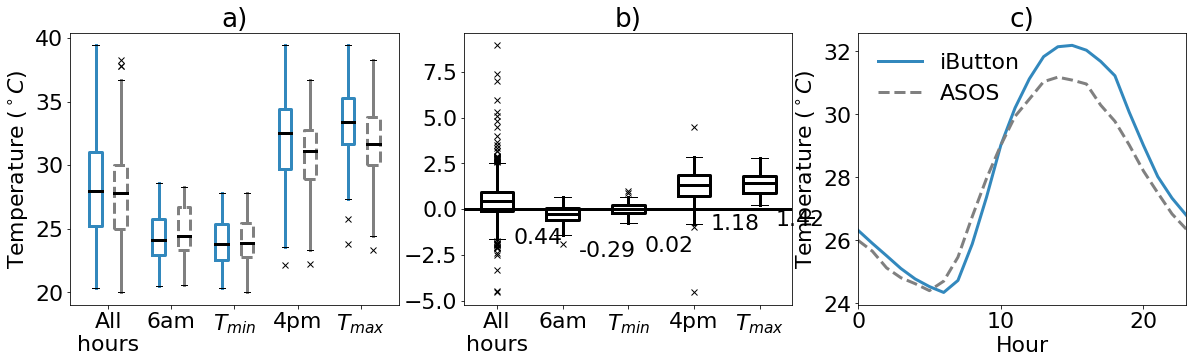

In [203]:
# Station temperature/ibutton comparison 
# uncorrected data 
tempDF_uncorrected=pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')['2016-07-01':'2016-08-31']#.first()
tempDF_uncorrected.columns = tempDF_uncorrected.columns.astype('int')
# asos data 
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')
### rearrange asos into obs dataframe
for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

### set plotting details, like colors and linestyles
ibutton_linestyle = '-'
ibutton_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][-1]#'k'
asos_linestyle = '--'
asos_color = 'grey'#plt.rcParams['axes.prop_cycle'].by_key()['color'][1]#'blue'
plt.figure(figsize = [20,5])
#plot temp
ax = plt.subplot(1,3,1)
data = [tempDF_uncorrected['2016-07-01':'2016-08-31'][97], 
        obs['2016-07-01':'2016-08-31']['urban'].dropna().values, 
        tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97],
        obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban'].dropna(), 
        tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').min(),
        obs['2016-07-01':'2016-08-31']['urban'].resample('D').min().dropna(), 
        
        tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97],
        obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban'].dropna(),   
        tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').max(),
        obs['2016-07-01':'2016-08-31']['urban'].resample('D').max().dropna(), 
       ]

handles = ax.boxplot(data[::2],positions=[0,1, 2.5,3.5, 5,6, 7.5, 8.5, 10, 11 ][::2],  
                     boxprops=(dict( linestyle=ibutton_linestyle,linewidth=3, color=ibutton_color)), 
                     whiskerprops=dict(color=ibutton_color,linewidth=3,),flierprops = dict(marker='x', color=ibutton_color),
                    medianprops = dict(linestyle='-', color='k',linewidth=3,))
handles2 = ax.boxplot(data[1::2],positions=[0,1, 2.5,3.5, 5,6, 7.5, 8.5, 10, 11 ][1::2], 
                      boxprops=(dict( linestyle=asos_linestyle,color=asos_color,linewidth=3,)),
                      whiskerprops=dict(color=asos_color,linewidth=3,),flierprops = dict(marker='x', color =asos_color),
                      medianprops = dict(linestyle='-', color='k',linewidth=3,))
x_handles = plt.xticks([.5,3,5.5, 8, 10.5], ['All\nhours', '6am', '$T_{min}$', '4pm', '$T_{max}$'])
plt.xlim([-1,12])

ax.set_title('a)') 
ax.set_ylabel('Temperature ($^\circ C$)')

ax = plt.subplot(1,3,2)
data = [(tempDF_uncorrected['2016-07-01':'2016-08-31'][97]-obs['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97] - obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').min()- obs['2016-07-01':'2016-08-31']['urban'].resample('D').min()).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97]- obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban']).dropna(),   
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').max() - obs['2016-07-01':'2016-08-31']['urban'].resample('D').max()).dropna(), 
       ]
ax.axhline(0, color = 'k')
h = ax.boxplot(data, positions=[0,1,2,3,4],  
                     boxprops=(dict( linestyle='-',linewidth=3, color='k')), 
                     whiskerprops=dict(color='k',linewidth=3,),flierprops = dict(marker='x', color='k'),
                    medianprops = dict(linestyle='-', color='k',linewidth=3,))
for i in range(0,5): 
    mean = data[i].mean()
    ax.text(i+.25,mean-2,'%1.2f'%mean, verticalalignment='center')
x_handles = plt.xticks([0,1,2,3,4], ['All\nhours', '6am', '$T_{min}$', '4pm', '$T_{max}$'])
ax.set_title('b)')

ax = plt.subplot(1,3,3)
tempDF_uncorrected['2016-07-01':'2016-08-31'][97].groupby(tempDF_uncorrected['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'iButton', linestyle=ibutton_linestyle, color = ibutton_color)
obs['2016-07-01':'2016-08-31']['urban'].groupby(obs['2016-07-01':'2016-08-31'].index.hour).mean().plot(label = 'ASOS', linestyle=asos_linestyle,color = asos_color)
plt.legend(loc =2,frameon=False)
ax.set_title('c)')
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Hour')
#plt.savefig('figures/ibuttonbias.png')
plt.savefig('figures/ibuttonbias.eps',bbox_inches='tight')

In [709]:
data = [(tempDF_uncorrected['2016-07-01':'2016-08-31'][97]-obs['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==6]['2016-07-01':'2016-08-31'][97] - obs[obs.index.hour==6]['2016-07-01':'2016-08-31']['urban']).dropna(), 
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').min()- obs['2016-07-01':'2016-08-31']['urban'].resample('D').min()).dropna(), 
        (tempDF_uncorrected[tempDF_uncorrected.index.hour ==16]['2016-07-01':'2016-08-31'][97]- obs[obs.index.hour==16]['2016-07-01':'2016-08-31']['urban']).dropna(),   
        (tempDF_uncorrected['2016-07-01':'2016-08-31'][97].resample('D').max() - obs['2016-07-01':'2016-08-31']['urban'].resample('D').max()).dropna(), 
       ]
for i in range(0,5): 
    print(data[i].mean())

0.4446816609
-0.288533333333
0.019064516129
1.17725
1.41772580645


In [149]:
x = obs['2016-07-01':'2016-08-31']['urban'].dropna()
y = tempDF_uncorrected['2016-07-01':'2016-08-31'][97].dropna()
scipy.stats.pearsonr(x, y[x.index])

(0.96756173303551996, 0.0)

In [480]:
# rmse
from sklearn.metrics import mean_squared_error
# correlation 
# coefficient of determination: r**2
# hit rate 
def pbias(obs, sim): 
    return 100*(sim-obs).sum()/(obs).sum()
# index of agreement
def mioa(obs,sim,  j =2): 
    return 1 - (((obs-sim)**j).sum())/( (abs(sim-obs.mean())+abs(obs-obs.mean()))**j).sum() 
# # pretty print latex table : 
# vars = [rmse,correlation[0]]
# labels = ['RMSE', 'r']
# for var, label in zip(vars,labels): 
#     print('%s & %2.2f \\\\'%(label,var))

In [578]:
### compute error in space 
obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].mean(axis=0).values
sim = model['2016-07-01':'2016-08-29'].mean(axis=0).values

stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])
# all data 
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF_uncorrected[tempDF_uncorrected.index.hour ==hr].loc[:'2016-08-29', model.columns].mean(axis=0).values
    sim = model[model.index.hour==hr][:'2016-08-29'].mean(axis=0).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)
    
for hr in ['min', 'max']: 
    obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].resample('D', how = hr).mean(axis=0).values
    sim = model['2016-07-01':'2016-08-29'].resample('D', how = hr).mean(axis=0).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

print('Error in space', stats_df)

('Error in space',                  all data             6        16           min       max
rmse         9.332737e-01  3.315613e+00  3.698937  2.744835e+00  6.087859
correlation  6.435396e-01  5.239002e-01  0.461411  5.384820e-01  0.398209
p-value      3.082531e-11  2.669312e-07  0.000009  1.062557e-07  0.000160
pbias        7.787390e-01 -6.379852e+00  2.551613 -5.764737e+00  3.308640
mioa         6.860877e-01  5.541978e-01  0.451269  5.684483e-01  0.415107
r_squared    4.141432e-01  2.744714e-01  0.212901  2.899628e-01  0.158570)


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


In [579]:
print('Space error: '+  stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' '))

Space error: \begin{tabular}{lrrrrr}
\toprule
{} &  all data &     6 &   16 &   min &  max \\
\midrule
rmse        &      0.93 &  3.32 & 3.70 &  2.74 & 6.09 \\
correlation &      0.64 &  0.52 & 0.46 &  0.54 & 0.40 \\
p-value     &      0.00 &  0.00 & 0.00 &  0.00 & 0.00 \\
pbias       &      0.78 & -6.38 & 2.55 & -5.76 & 3.31 \\
mioa        &      0.69 &  0.55 & 0.45 &  0.57 & 0.42 \\
r\_squared   &      0.41 &  0.27 & 0.21 &  0.29 & 0.16 \\
\bottomrule
\end{tabular}



In [581]:
obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].mean(axis=1).values
sim = model['2016-07-01':'2016-08-29'].mean(axis=1).values

stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])
# all data 
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF_uncorrected[tempDF_uncorrected.index.hour ==hr].loc['2016-07-01':'2016-08-29', model.columns].mean(axis=1).values
    sim = model[model.index.hour==hr]['2016-07-01':'2016-08-29'].mean(axis=1).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

for hr in ['min', 'max']: 
    obs = tempDF_uncorrected.loc['2016-07-01':'2016-08-29', model.columns].resample('D', how = hr).mean(axis=1).values
    sim = model['2016-07-01':'2016-08-29'].resample('D', how = hr).mean(axis=1).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)
print('Time error: ', stats_df)

('Time error: ',              all data             6            16           min           max
rmse         4.601450  4.147685e+00  6.038084e+00  3.937321e+00  2.865623e+00
correlation  0.894613  8.399708e-01  7.629231e-01  8.201512e-01  9.011401e-01
p-value      0.000000  4.925047e-17  1.391145e-12  1.087524e-15  1.020706e-22
pbias        0.778739 -6.379852e+00  2.551613e+00 -5.764737e+00  3.308640e+00
mioa         0.933305  8.299194e-01  8.541625e-01  8.210240e-01  9.164267e-01
r_squared    0.800333  7.055510e-01  5.820517e-01  6.726480e-01  8.120534e-01)


/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


In [582]:
print('%Time error: \n'+  stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' '))

Time error: \begin{tabular}{lrrrrr}
\toprule
{} &  all data &     6 &   16 &   min &  max \\
\midrule
rmse        &      4.60 &  4.15 & 6.04 &  3.94 & 2.87 \\
correlation &      0.89 &  0.84 & 0.76 &  0.82 & 0.90 \\
p-value     &      0.00 &  0.00 & 0.00 &  0.00 & 0.00 \\
pbias       &      0.78 & -6.38 & 2.55 & -5.76 & 3.31 \\
mioa        &      0.93 &  0.83 & 0.85 &  0.82 & 0.92 \\
r\_squared   &      0.80 &  0.71 & 0.58 &  0.67 & 0.81 \\
\bottomrule
\end{tabular}



In [523]:
tempDF.mean(axis=1).std()

3.4922423609056255

In [529]:
tempDF.resample('D').mean().mean(axis=1).min(), tempDF.resample('D').mean().mean(axis=1).max(), tempDF.resample('D').mean().mean(axis=1).std()

(21.12557283873868, 31.405609626487976, 2.2232278301714588)

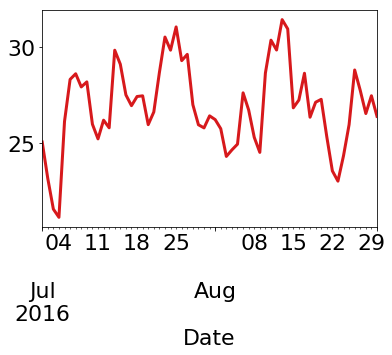

In [525]:
tempDF.resample('D').mean().mean(axis=1).plot()

In [3]:
# lcz classification 
lcz_dict = {1: 'compact high-rise', #tens of stories, no trees, paved 
2: 'compact mid-rise', #3-9 stories, mostly paved
3: 'compact low-rise', #1-3 stories
6: 'Open low-rise', #abundance of pervious landcover, 1-3 stories
            8: 'sparesely built', 
'A': 'dense trees', # natural forest or urban park
'B': 'scattered trees', #natural forest or urban park
'D': 'low plants', #natural grassland, ag, or urban park
'G': 'water',
           }
# first, assume that everything is 3: compact low rise, impervious
lcz[[97, 77]] = 1
lcz[[]] = 2

# rural or urban forest- A
68, 75, 103, 63, 4,  33.0, 13.0, 28.0, 47.0, 16.0,  4.0, 43.0, 22.0,  29.0, 21.0, 44.0, 20
# suburban 9
130, 121 # Ben's house, 75, could also maybe be here? 
# open low-rise, 6, essentially Roland park type housing
73, 64, 94, 127,123, 128, 129, 85, 83 
# Vesa's open category, park, D 
144,4, 53, 20, meta[meta['vesacategory'] == 'o'].index
# compact mid-rise , 2
88
# scattered trees, B 
11.0,12,  54, 34.0,32.0, 

# dense housing, aka rowhomes, 3
74, 108, 79, 84, 72

NameError: name 'lcz' is not defined

In [6]:
lcz_dict = {1: 'compact high-rise', #tens of stories, no trees, paved 
2: 'compact mid-rise', #3-9 stories, mostly paved
3: 'compact low-rise', #1-3 stories
6: 'Open low-rise', #abundance of pervious landcover, 1-3 stories
            9: 'sparesely built', 
'A': 'dense trees', # natural forest or urban park
'B': 'scattered trees', #natural forest or urban park
'D': 'low plants', #natural grassland, ag, or urban park
'G': 'water',
           }

In [5]:
lcc['lcz'] = np.ones(lcc.shape[0])*3
sel = [97, 77]
lcc.loc[sel,'lcz'] = 1

sel = [68, 75, 103, 63, 4,  33.0, 13.0, 28.0, 47.0, 16.0,  4.0, 43.0, 22.0,  29.0, 21.0, 44.0, 20]
lcc.loc[sel,'lcz'] = 'A'
sel = [130]#, 121 ]
lcc.loc[sel,'lcz'] = 9
sel = [73, 64, 94, 127,123, 128, 129, 85, 83 ]
lcc.loc[sel,'lcz'] = 6
#sel = [144,4, 53, 20, meta[meta['vesacategory'] == 'o'].index]
sel = [x for x in meta[meta['vesacategory'] == 'o'].index.values] + [144,4, 53, 20,]
sel =np.setdiff1d(sel, 41)
lcc.loc[sel,'lcz'] = 'D'
lcc.loc[88, 'lcz'] = 2
sel = [11.0,12,  54, 34.0,32.0, ]
lcc.loc[sel, 'lcz'] = 'B'
sel = [74, 108, 79,  72] # 84,
lcc.loc[sel, 'lcz'] = 3
lcc['LCZ English'] =  [lcz_dict[x]for x in lcc.lcz]

NameError: name 'lcc' is not defined

In [ ]:
#### error tables 
# error in space 
# error in time 

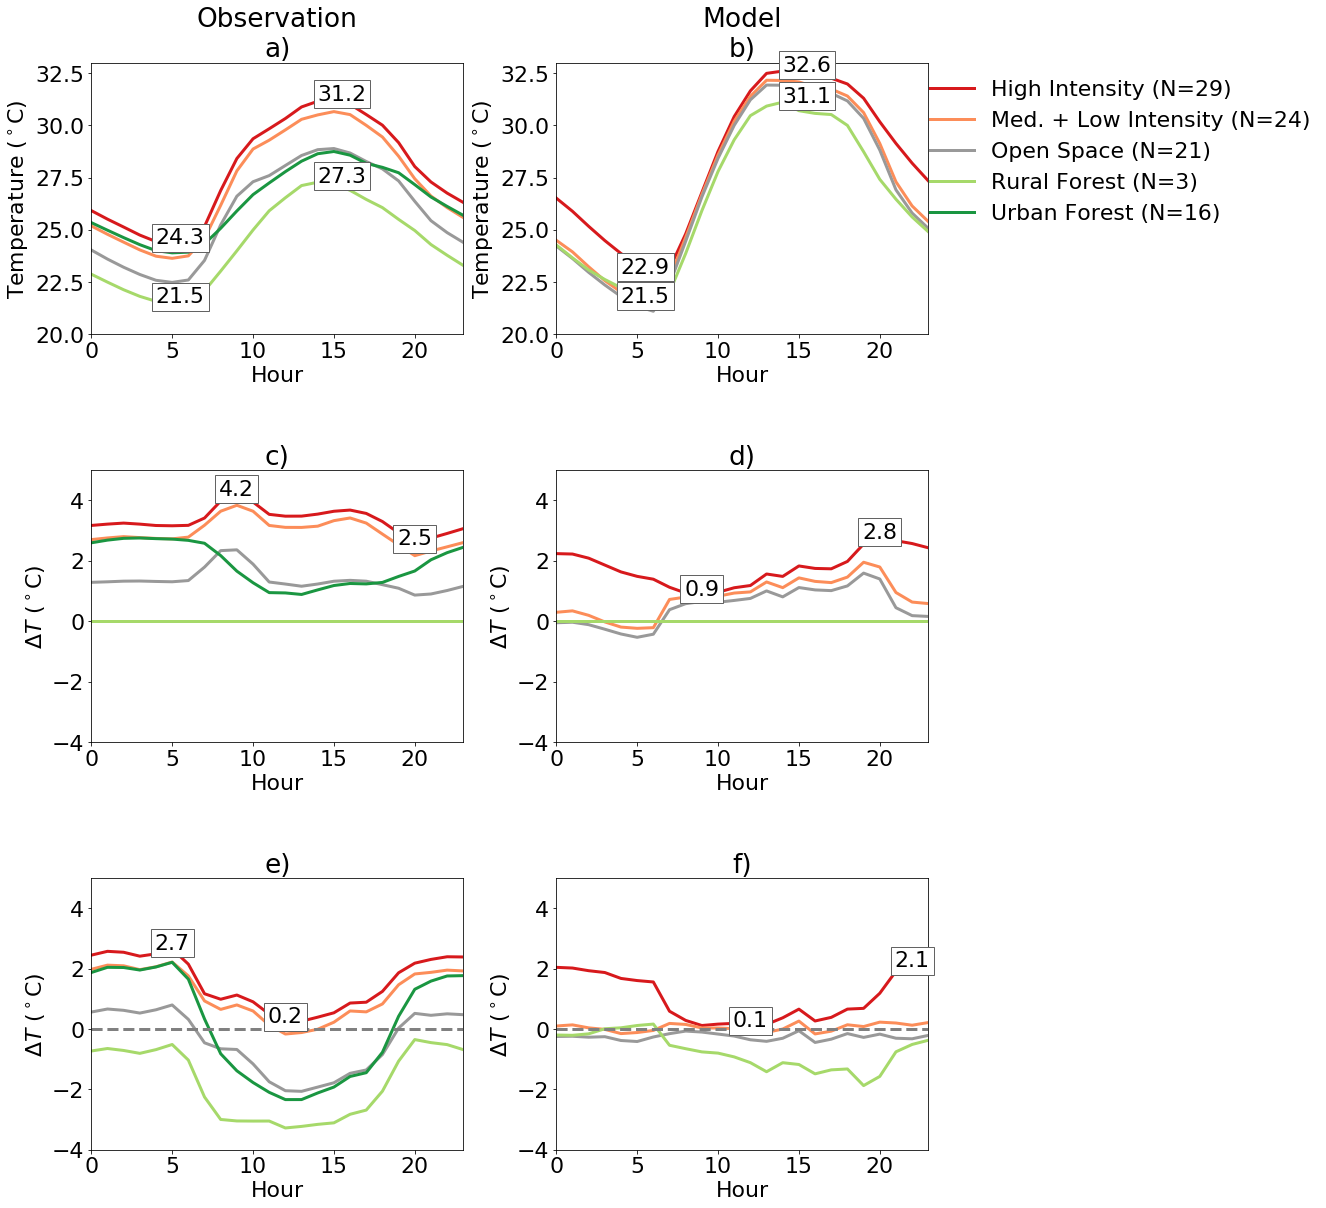

In [345]:
plt.figure(figsize= [15,20])
model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
model_rural =  model[lcc[lcc.LCC ==28].index].groupby(model.index.hour).mean().mean(axis=1)
obs_rural = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1)
#obs_rural = tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)

ax = plt.subplot(3,2,1)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', 'Urban Forest (N=16)']
plt.legend(labels, bbox_to_anchor=(2.2, 1.01),loc=2,frameon=False)
lc = 26
plt.text(15.5, tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).max(),
'%2.1f'%tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(5.5, tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).min(),
 '%2.1f'% tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

lc = 28
plt.text(15.5, tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).max(),
'%2.1f'%tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(5.5, tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).min(),
 '%2.1f'% tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

ax = plt.subplot(3,2,2)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
lc = 26
plt.text(15.5, model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).max(),
'%2.1f'%model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(5.5, model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).min(),
 '%2.1f'%model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

lc = 28
plt.text(15.5, model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).max(),
'%2.1f'%model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(5.5, model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).min(),
 '%2.1f'%model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

# plot DT
ax = plt.subplot(3,2,3)
#tempDF.subtract(tempDF[103], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).plot(label = lcc_english[lc],ax=ax)
tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
lc = 26
plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmax(),(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
'%2.1f'%(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmin(), (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
 '%2.1f'% (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()
ax.set_title('c)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4,5])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(3,2,4)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).plot(label = lcc_english[lc],ax=ax)
lc = 26
plt.text((model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).argmax(),
         (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).max(),
'%2.1f'%(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text((model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).argmin(),
         (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).min(),
 '%2.1f'%(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_title('d)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([-4,5])

# add plot comparing with BWI
ax = plt.subplot(3,2,5)
obs_rural = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).plot(label = lcc_english[lc],ax=ax)
tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
ax.set_title('e)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')

ax.set_ylim([-4,5])
ax.axhline(0, linestyle ='--', color = 'gray')
lc = 26
plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmax(),(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
'%2.1f'%(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmin(), (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
 '%2.1f'% (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_xlabel('Hour')
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()

ax = plt.subplot(3,2,6)
model_rural = model_bwi['0.0'].groupby(model_bwi.index.hour).mean()
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).plot(label = lcc_english[lc],ax=ax)
ax.set_title('f)')
ax.set_ylim([-4,5])
ax.axhline(0, linestyle ='--', color = 'gray')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
lc = 26
plt.text((model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).argmax(),
         (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).max(),
'%2.1f'%(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).max(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text((model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).argmin(),
         (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).min(),
 '%2.1f'%(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural).min(),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#plt.legend(labels,loc=2,frameon=False)
plt.subplots_adjust(hspace=.5,wspace = .25)
plt.savefig('figures/diurnal.eps',bbox_inches='tight')

In [ ]:
for ids, label in zip(selected,['Street Trees', 'Park + Trees', 'Parks, Open Field', 'Urban Forest'] ): 
    ax = plt.subplot(1,4,i)
    all_data = []
    for lc in [26,25,23]: 
        if lc ==25: 
            data = tempDF[np.intersect1d(ids, [lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(ax=ax)
        else: 
            data = tempDF[np.intersect1d(ids, [lcc[lcc.LCC ==lc].index])].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(ax=ax)
            plt.text(data.argmin(), data.min(), '%2.1f'%(data.min()),horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363'))
            plt.text(data.argmax(), data.max(), '%2.1f'%(data.max()),horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363'))
        data.plot() 
        all_data.append(data.values)
    plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
    ax.set_title(label)
    ax.set_ylim([22,34])
    ax.set_ylabel('Temperature ($^\circ $C)')
    ax.set_xlabel('Hour')
#     lc = 26
#     plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmax(),(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
#     '%2.1f'%(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
#     plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmin(), (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
#      '%2.1f'% (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )

    i = i+1
plt.legend(['High Intensity', 'Med. + Low Intensity', 'Open Space', 'Mean'], #labels, 
           bbox_to_anchor=(1.1, 1.01),
               frameon=False)
plt.subplots_adjust(wspace = .5)


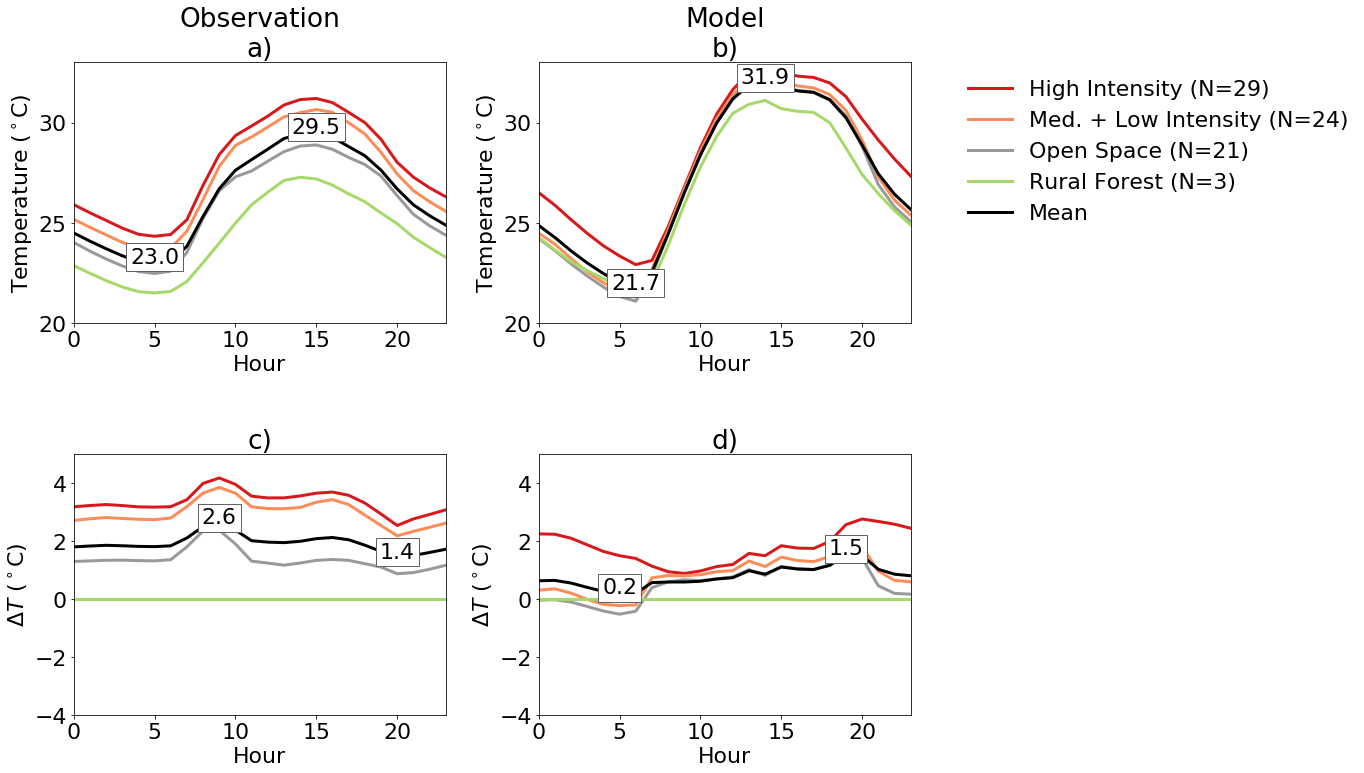

In [215]:
plt.figure(figsize= [15,12])

#plt.figure(figsize= [15,20])
model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
model_rural =  model[lcc[lcc.LCC ==28].index].groupby(model.index.hour).mean().mean(axis=1)
obs_rural = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1)
#ax = plt.subplot(3,2,1)
ax = plt.subplot(2,2,1)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        data = tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax = plt.subplot(2,2,2)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        data = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
        #plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', #'Urban Forest (N=16)', '
          'Mean']
plt.legend(labels,#['High Intensity', 'Med. + Low Intensity', 'Open Space', 'Rural Forest', 'Mean'], #labels, 
           bbox_to_anchor=(1.1, 1.01),
               frameon=False)
# plot DT
ax = plt.subplot(2,2,3)
ax.axhline(0, linestyle ='--', color = 'gray')

#tempDF.subtract(tempDF[103], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
lc = 26
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()
ax.set_title('c)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4,5])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(2,2,4)
ax.axhline(0, linestyle ='--', color = 'gray')

all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
lc = 26
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_title('d)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([-4,5])

# # add plot comparing with BWI
# ax = plt.subplot(3,2,5)
# obs_rural = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
# all_data =[]
# for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     if lc ==28: 
#         data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
#     else: 
# #     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
#         data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
#     data.plot()
#     all_data.append(data.values)
# plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
# #tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
# ax.set_title('e)')
# ax.set_ylabel('$\Delta T$ ($^\circ$C)')
# ax.set_xlabel('Hour')

# ax.set_ylim([-4,5])
# ax.axhline(0, linestyle ='--', color = 'gray')
# lc = 26
# plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
#          np.max(np.mean(np.array(all_data),axis=0)),
# '%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
#  horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#  )
# plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
#          np.min(np.mean(np.array(all_data),axis=0)),
#  '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
#  horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#  )
# ax.set_xlabel('Hour')
# #tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()

# ax = plt.subplot(3,2,6)
# model_rural = model_bwi['0.0'].groupby(model_bwi.index.hour).mean()
# all_data = []
# for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
# #     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
#     data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
#     data.plot()
#     all_data.append(data.values)
# plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
# ax.set_title('f)')
# ax.set_ylim([-4,5])
# ax.axhline(0, linestyle ='--', color = 'gray')
# ax.set_ylabel('$\Delta T$ ($^\circ$C)')
# ax.set_xlabel('Hour')
# plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
#          np.max(np.mean(np.array(all_data),axis=0)),
# '%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
#  horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#  )
# plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
#          np.min(np.mean(np.array(all_data),axis=0)),
#  '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
#  horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#  )
# #plt.legend(labels,loc=2,frameon=False)
plt.subplots_adjust(hspace=.5,wspace = .25)
plt.savefig('figures/diurnal.eps',bbox_inches='tight')

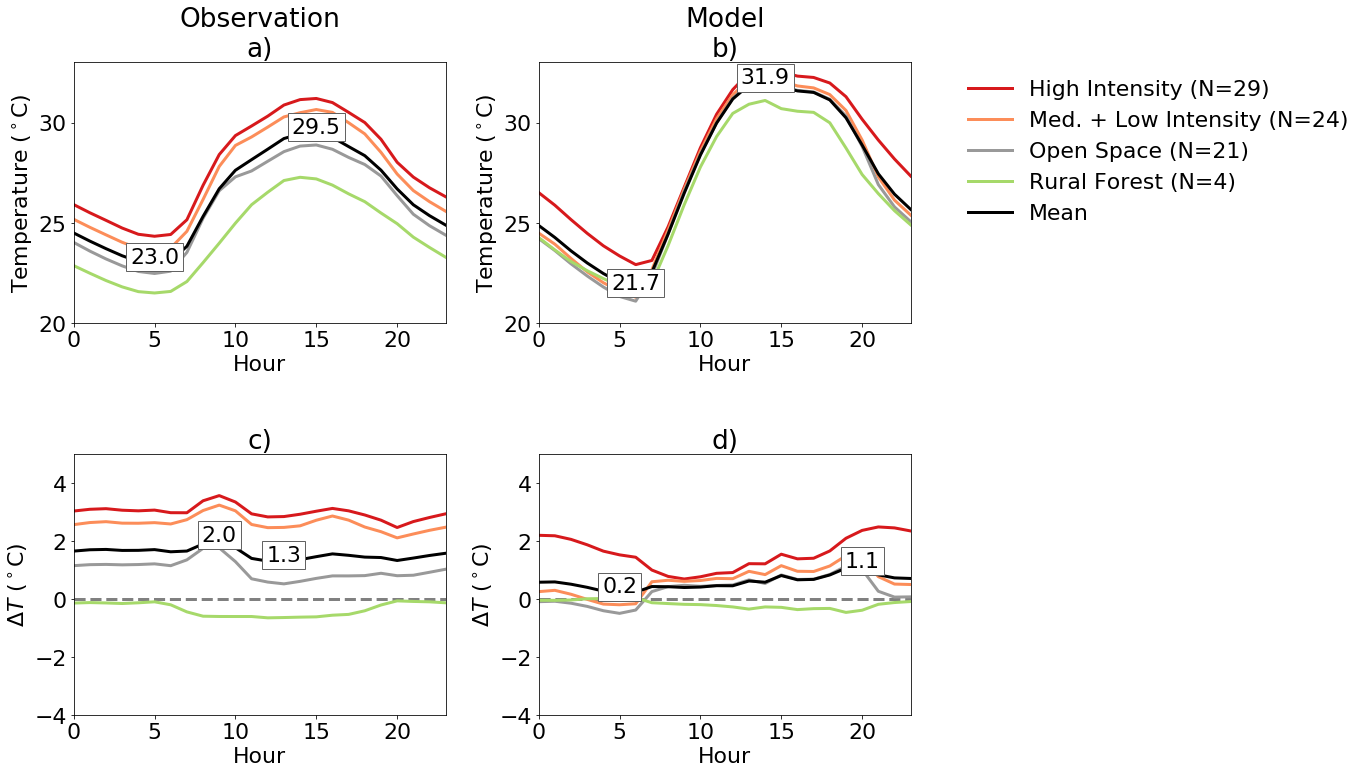

In [32]:
# add BWI to rural baseline
plt.figure(figsize= [15,12])

model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
# rural model 
frames = [model[lcc[lcc.LCC ==28].index].groupby(model.index.hour).mean(), model_bwi.groupby(model_bwi.index.hour).mean()]
model_rural = pd.concat(frames,axis=1).mean(axis=1)

# rural observations 
frames = [tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean(), obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()]
obs_rural = pd.concat(frames,axis=1).mean(axis=1)
#ax = plt.subplot(3,2,1)
ax = plt.subplot(2,2,1)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        data = tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax = plt.subplot(2,2,2)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        data = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
        #plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=4)', #'Urban Forest (N=16)', '
          'Mean']
plt.legend(labels,#['High Intensity', 'Med. + Low Intensity', 'Open Space', 'Rural Forest', 'Mean'], #labels, 
           bbox_to_anchor=(1.1, 1.01),
               frameon=False)
# plot DT
ax = plt.subplot(2,2,3)
ax.axhline(0, linestyle ='--', color = 'gray')

#tempDF.subtract(tempDF[103], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
lc = 26
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()
ax.set_title('c)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4,5])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(2,2,4)
ax.axhline(0, linestyle ='--', color = 'gray')

all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
lc = 26
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_title('d)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([-4,5])
plt.subplots_adjust(hspace=.5,wspace = .25)
plt.savefig('figures/diurnal_includingBWI.eps',bbox_inches='tight')

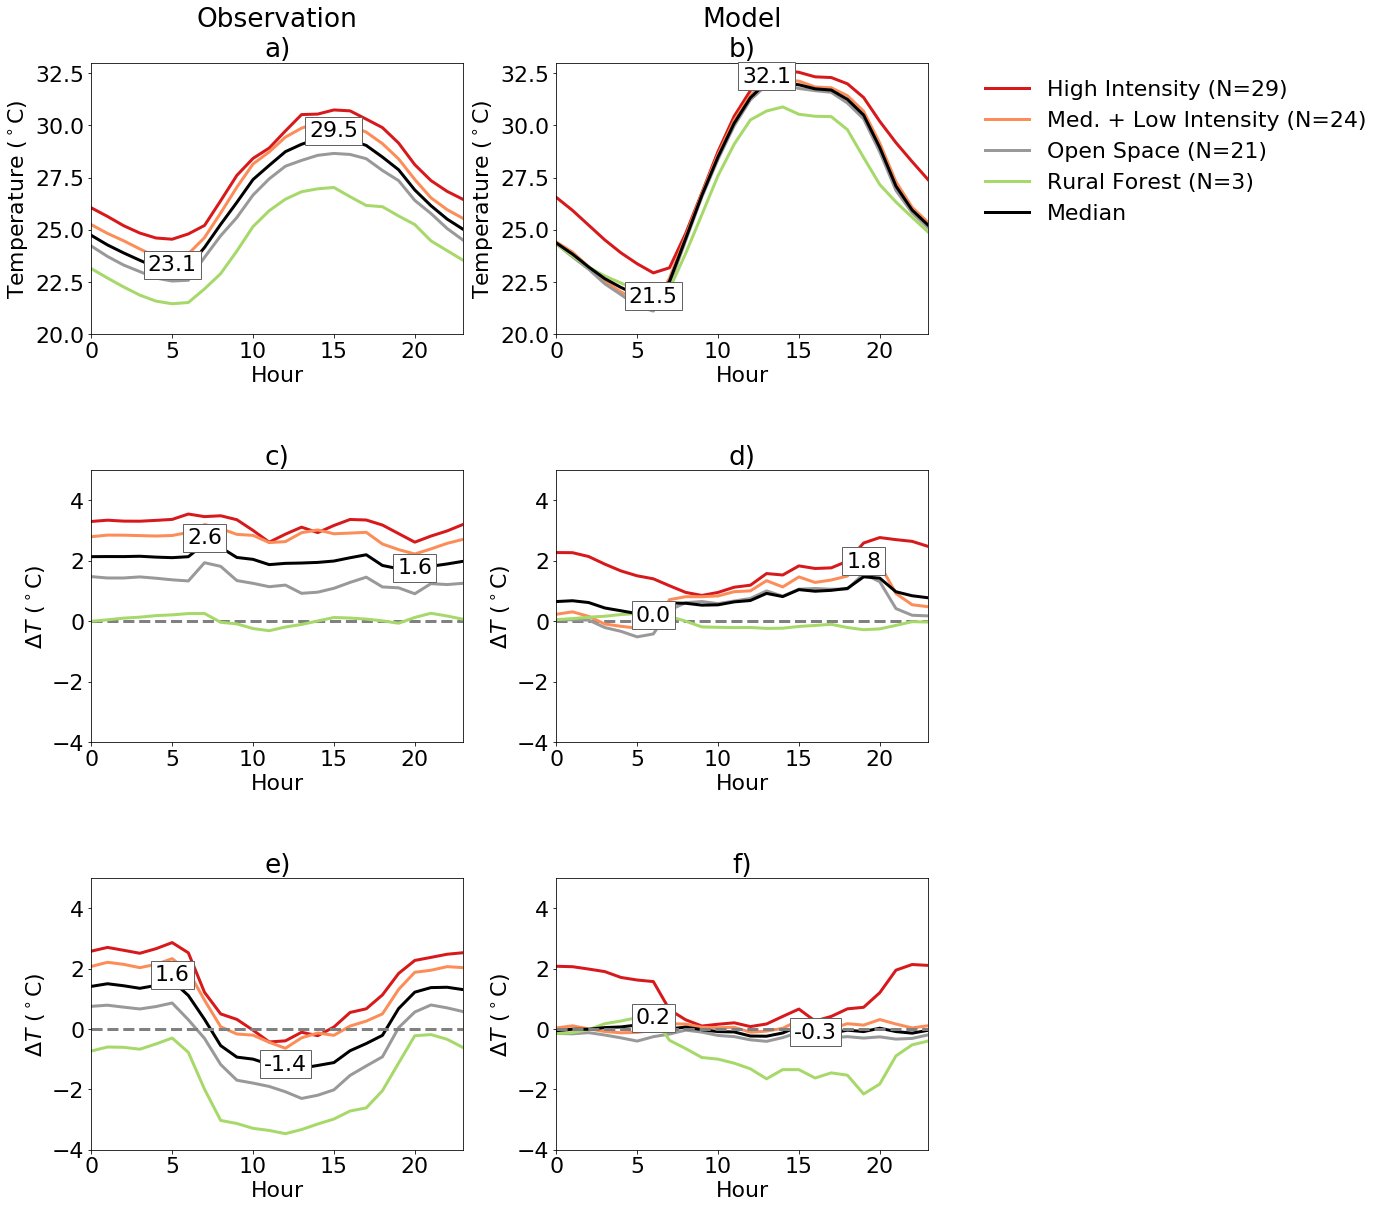

In [888]:
plt.figure(figsize= [15,20])
model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
model_rural =  model[lcc[lcc.LCC ==28].index].groupby(model.index.hour).mean().mean(axis=1)
obs_rural = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1)
ax = plt.subplot(3,2,1)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        data = tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax = plt.subplot(3,2,2)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        data = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
        #plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', #'Urban Forest (N=16)', '
          'Median']
plt.legend(labels,#['High Intensity', 'Med. + Low Intensity', 'Open Space', 'Rural Forest', 'Mean'], #labels, 
           bbox_to_anchor=(1.1, 1.01),
               frameon=False)
# plot DT
ax = plt.subplot(3,2,3)
ax.axhline(0, linestyle ='--', color = 'gray')

#tempDF.subtract(tempDF[103], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().median(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
lc = 26
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()
ax.set_title('c)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4,5])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(3,2,4)
ax.axhline(0, linestyle ='--', color = 'gray')

all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
lc = 26
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_title('d)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([-4,5])

# add plot comparing with BWI
ax = plt.subplot(3,2,5)
obs_rural = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().median(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
ax.set_title('e)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')

ax.set_ylim([-4,5])
ax.axhline(0, linestyle ='--', color = 'gray')
lc = 26
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_xlabel('Hour')
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()

ax = plt.subplot(3,2,6)
model_rural = model_bwi['0.0'].groupby(model_bwi.index.hour).mean()
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
ax.set_title('f)')
ax.set_ylim([-4,5])
ax.axhline(0, linestyle ='--', color = 'gray')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#plt.legend(labels,loc=2,frameon=False)
plt.subplots_adjust(hspace=.5,wspace = .25)

In [326]:
lc = 26
tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1) - tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1)

Date
0     0.732369
1     0.724770
2     0.722773
3     0.708887
4     0.700375
5     0.703032
6     0.674134
7     0.575818
8     0.706093
9     0.592267
10    0.491409
11    0.546105
12    0.544602
13    0.591610
14    0.652066
15    0.550915
16    0.489634
17    0.515871
18    0.566016
19    0.650447
20    0.584962
21    0.671893
22    0.692430
23    0.723012
dtype: float64

In [328]:
tempDF[lcc[lcc.LCC ==23].index].groupby(tempDF.index.hour).mean().mean(axis=1).min(), tempDF[lcc[lcc.LCC ==23].index].groupby(tempDF.index.hour).mean().mean(axis=1).max()

(22.48758469542339, 28.889905017864223)

In [331]:
31.2-24.3

6.899999999999999

In [330]:
27.3-21.5

5.800000000000001

In [329]:
28.9-22.5

6.399999999999999

In [287]:
lc = 26 
model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).subtract(model_rural).argmax()

22

In [344]:
obs_rural = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1)
tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).min(), tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).max(), tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).argmin(), tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).argmax()

(1.8105060881159467, 3.3504786206683725, 20, 9)

In [352]:
# figure out bwi land class 
sel_pts = wrf.ll_to_xy(Dataset(files[-1]), 39.175, -76.668)
bwi_lc = getvar(Dataset(files[-1]), "LU_INDEX").isel(west_east = sel_pts.values[0], south_north = sel_pts.values[1])
bwi_lc.values


array(23.0, dtype=float32)

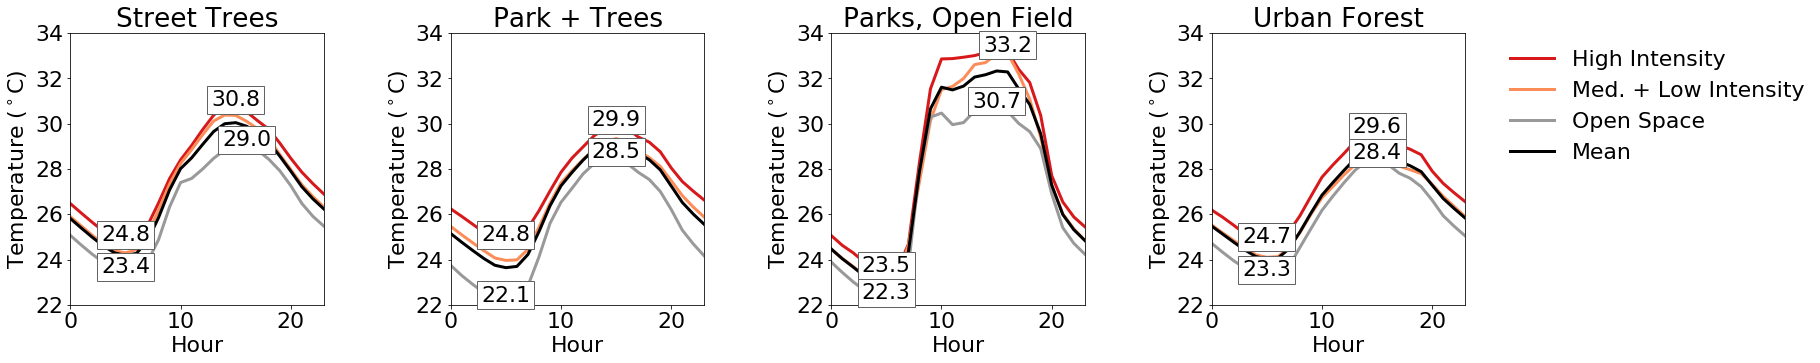

In [512]:
# make diurnal plot for sub 1-km vegetation 
selected = [meta[(meta.landcoverclass=='impervious') & (meta.attachment =='tree')].index, 
            meta[(meta.landcoverclass=='grass') & (meta.attachment =='tree')].index, 
            meta[(meta.vesacategory=='o')].index, 
            meta[(meta.vesacategory=='f')].index] 
plt.figure(figsize= [25,5])
i = 1
for ids, label in zip(selected,['Street Trees', 'Park + Trees', 'Parks, Open Field', 'Urban Forest'] ): 
    ax = plt.subplot(1,4,i)
    all_data = []
    for lc in [26,25,23]: 
        if lc ==25: 
            data = tempDF[np.intersect1d(ids, [lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(ax=ax)
        else: 
            data = tempDF[np.intersect1d(ids, [lcc[lcc.LCC ==lc].index])].groupby(tempDF.index.hour).mean().mean(axis=1)#.plot(ax=ax)
            plt.text(data.argmin(), data.min(), '%2.1f'%(data.min()),horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363'))
            plt.text(data.argmax(), data.max(), '%2.1f'%(data.max()),horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363'))
        data.plot() 
        all_data.append(data.values)
    plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
    ax.set_title(label)
    ax.set_ylim([22,34])
    ax.set_ylabel('Temperature ($^\circ $C)')
    ax.set_xlabel('Hour')
#     lc = 26
#     plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmax(),(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
#     '%2.1f'%(tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).max(),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
#     plt.text((tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).argmin(), (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
#      '%2.1f'% (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1)).subtract(obs_rural).min(),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )

    i = i+1
plt.legend(['High Intensity', 'Med. + Low Intensity', 'Open Space', 'Mean'], #labels, 
           bbox_to_anchor=(1.1, 1.01),
               frameon=False)
plt.subplots_adjust(wspace = .5)
plt.savefig('figures/diurnal_sub1km.eps',bbox_inches='tight')

In [361]:
tempDF[meta[(meta.attachment !='tree')].index].mean().mean(), tempDF[meta[(meta.attachment =='tree')].index].mean().mean()

(27.731625599785332, 26.634654843200327)

In [258]:
24.8-23.5

1.3000000000000007

In [ ]:
imp = meta[(meta.landcoverclass=='impervious') & (meta.attachment =='tree')].index
imp = meta[(meta.landcoverclass=='grass') & (meta.attachment =='tree')].index
imp = meta[(meta.vesacategory=='o')].index
imp = meta[(meta.vesacategory=='f')].index

for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')


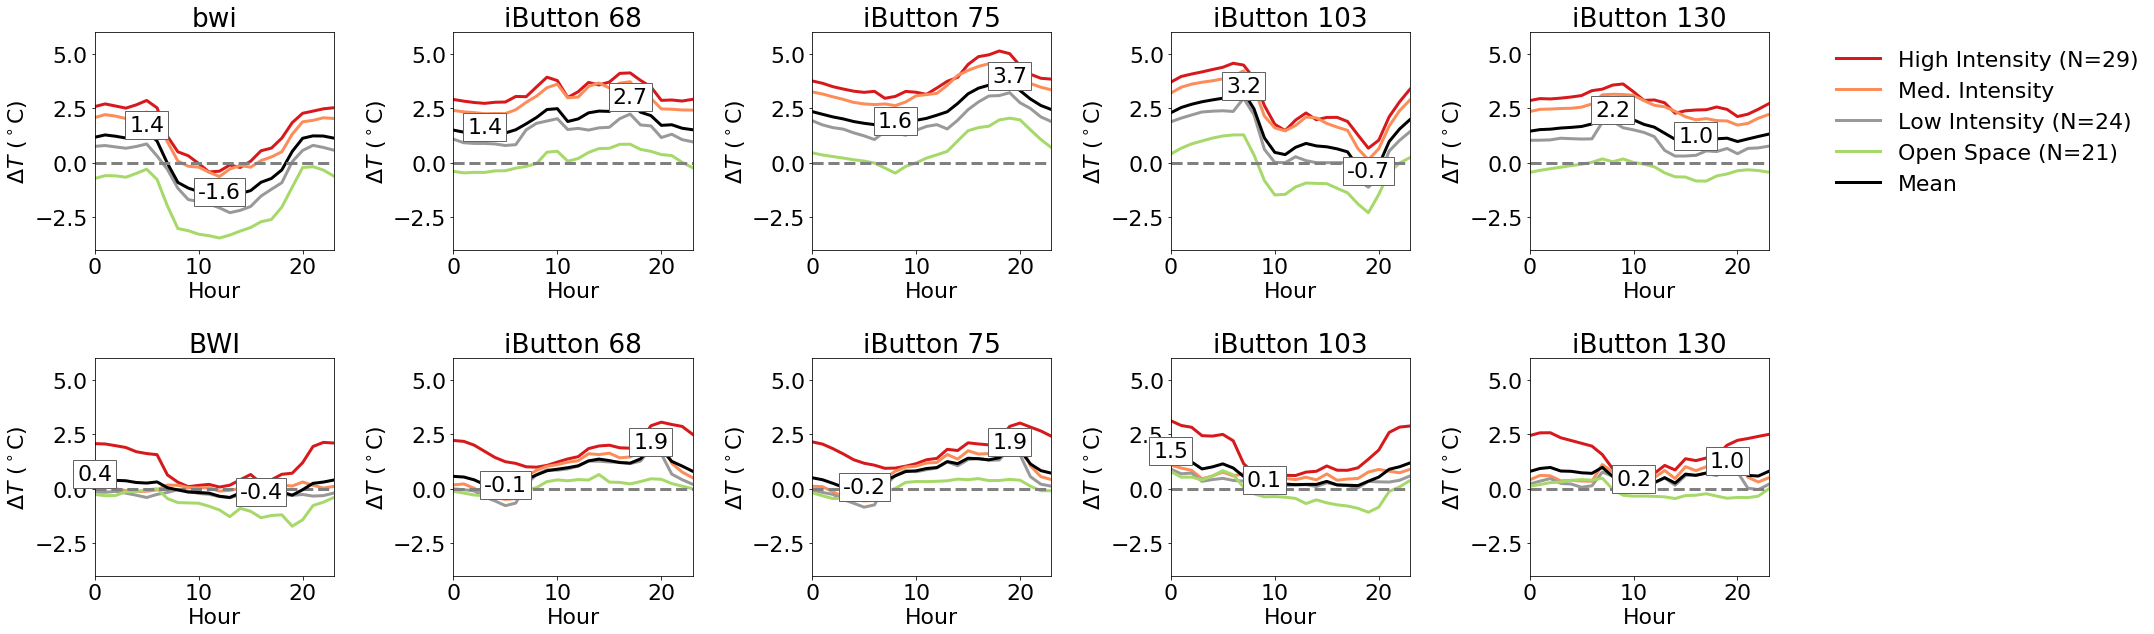

In [212]:
# UHI sensitivity plot 
bwi = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
ibutton = tempDF[[68]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton00 = tempDF[[75]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton01 = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)

plt.figure(figsize=[30,10])
i = 1
for obs_rural, title in zip([bwi,ibutton,ibutton00, ibutton01, ibutton2], ['bwi', 'iButton 68', 'iButton 75', 'iButton 103', 'iButton 130']): 
    ax = plt.subplot(2,5,i)
    all_data =[]
    for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
        if lc ==28: 
            data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().median(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
        else: 
            data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
        data.plot(ax = ax)
        all_data.append(data.values)
#    ax.plot(np.median(np.array(all_data),axis=0), color = 'k')
    ax.plot(np.mean(np.array(all_data),axis=0), color = 'k')
    plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
    '%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )
    plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
             np.min(np.mean(np.array(all_data),axis=0)),
     '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )

#     plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
#          np.max(np.median(np.array(all_data),axis=0)),
#     '%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
#     plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
#              np.min(np.median(np.array(all_data),axis=0)),
#      '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
#     ax.set_title('c)')
    ax.set_ylabel('$\Delta T$ ($^\circ$C)')
    #plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
    ax.set_ylim([-4, 6])
    ax.set_xlabel('Hour')
    ax.set_title(title)
    ax.axhline(0, linestyle ='--', color = 'gray')

    i = i+1
plt.legend(['High Intensity (N=29)',
 'Med. Intensity',
 'Low Intensity (N=24)',
 'Open Space (N=21)', 'Mean'], bbox_to_anchor=(1.2, 1.01),loc=2,frameon=False)


ax = plt.subplot(2,5,i)    
model_rural = np.array(model_bwi.groupby(model_bwi.index.hour).mean()).flatten()#model_bwi.groupby(model_bwi.index.hour).mean().values
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = model[[68, 75, 130, 103]].groupby(model.index.hour).mean().median(axis=1).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
        data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot(ax = ax)
    all_data.append(data.values)    
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4, 6])
ax.set_xlabel('Hour')
ax.set_title('BWI')
ax.axhline(0, linestyle ='--', color = 'gray')

ax.plot(np.mean(np.array(all_data),axis=0), color = 'k')
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
     np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

i = i+1
for ibutton, title in zip([68,75,103, 130,], ['iButton 68', 'iButton 75', 'iButton 103', 'iButton 130']): 
    ax = plt.subplot(2,5,i)
    model_rural = model[ibutton].groupby(model.index.hour).mean()
    all_data =[]
    for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
        if lc ==28: 
            data = model[[68, 75, 130, 103]].groupby(model.index.hour).mean().median(axis=1).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
        else: 
            data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
        data.plot(ax = ax)
        all_data.append(data.values)    
    ax.set_ylabel('$\Delta T$ ($^\circ$C)')
    #plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
    ax.set_ylim([-4, 6])
    ax.set_xlabel('Hour')
    ax.set_title(title)
    ax.axhline(0, linestyle ='--', color = 'gray')
    
    ax.plot(np.mean(np.array(all_data),axis=0), color = 'k')
    plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
    '%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )
    plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
             np.min(np.mean(np.array(all_data),axis=0)),
     '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )
    
    i = i+1

plt.subplots_adjust(wspace=.5, hspace = 0.5)
plt.savefig('figures/DT_sensitivity.eps', bbox_inches = 'tight')

In [167]:
data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1))#.subtract(model_rural,axis=0)
data

Unnamed: 0
0     26.553708
1     25.933155
2     25.224862
3     24.518651
4     23.899840
5     23.379159
6     22.941881
7     23.186597
8     24.829394
9     26.771713
10    28.748233
11    30.437857
12    31.657594
13    32.500355
14    32.640879
15    32.535139
16    32.319762
17    32.285164
18    31.986544
19    31.330563
20    30.189150
21    29.170188
22    28.262522
23    27.388808
dtype: float64

In [197]:
model_rural = np.array(model_bwi.groupby(model_bwi.index.hour).mean()).flatten()

In [194]:
np.array(model_rural).flatten()

array([ 24.47653899,  23.86998011,  23.24014532,  22.61817457,
        22.19296865,  21.75736474,  21.37156002,  22.54835135,
        24.52474162,  26.67382914,  28.5904658 ,  30.2330602 ,
        31.57722473,  32.33391164,  32.2235906 ,  31.87498118,
        32.05590159,  31.86835429,  31.31884155,  30.61193186,
        28.98695068,  27.22164561,  26.12721812,  25.28313751])

In [195]:
data +(np.array(model_rural).flatten())

Unnamed: 0
0     51.030247
1     49.803135
2     48.465007
3     47.136826
4     46.092809
5     45.136524
6     44.313441
7     45.734949
8     49.354135
9     53.445542
10    57.338698
11    60.670917
12    63.234819
13    64.834266
14    64.864470
15    64.410121
16    64.375664
17    64.153519
18    63.305386
19    61.942495
20    59.176101
21    56.391834
22    54.389740
23    52.671945
dtype: float64

In [198]:
data.subtract(model_rural)

Unnamed: 0
0     2.077169
1     2.063175
2     1.984717
3     1.900477
4     1.706872
5     1.621794
6     1.570321
7     0.638246
8     0.304652
9     0.097884
10    0.157767
11    0.204797
12    0.080369
13    0.166443
14    0.417289
15    0.660158
16    0.263861
17    0.416810
18    0.667703
19    0.718631
20    1.202200
21    1.948543
22    2.135304
23    2.105670
dtype: float64

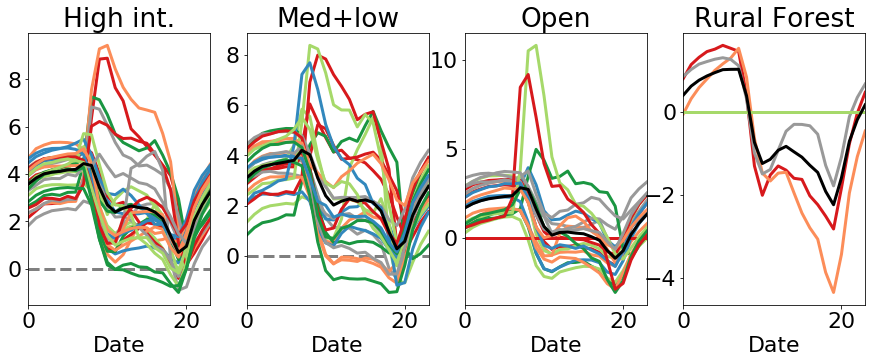

In [625]:
plt.figure(figsize = [15,5])
ax = plt.subplot(1,7,i)
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
all_data =[]
i = 1
lcs = ['High int.', 'Med+low', 'Open', 'Rural Forest']
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    ax = plt.subplot(1,4, i)
    ax.axhline(0, linestyle ='--', color = 'gray')
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    else: 
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    data.plot(ax = ax, legend = False)
    data.mean(axis=1).plot(color = 'k')
    ax.set_title('%s'%lcs[i-1])
    i = i+1
#plt.legend(labels, bbox_to_anchor=(1.2, 1.01),loc=2,frameon=False)

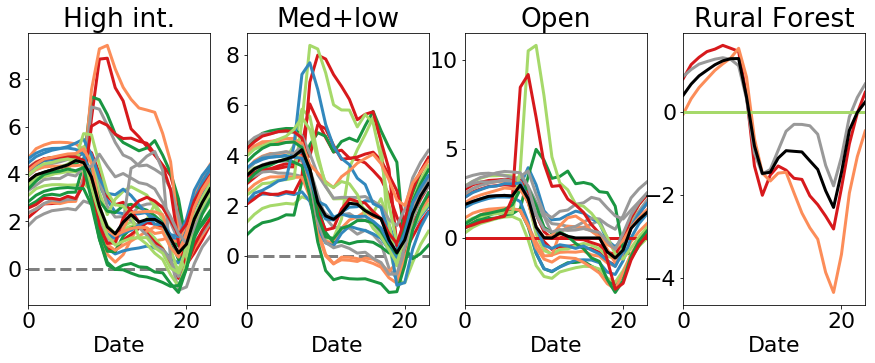

In [884]:
plt.figure(figsize = [15,5])
i = 1
ax = plt.subplot(1,7,i)
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
all_data =[]
lcs = ['High int.', 'Med+low', 'Open', 'Rural Forest']
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    ax = plt.subplot(1,4, i)
    ax.axhline(0, linestyle ='--', color = 'gray')
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    else: 
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    data.plot(ax = ax, legend = False)
    data.median(axis=1).plot(color = 'k')
    ax.set_title('%s'%lcs[i-1])
    i = i+1
#plt.legend(labels, bbox_to_anchor=(1.2, 1.01),loc=2,frameon=False)

In [586]:
meta.loc[[68, 75, 130, 103]][['landcoverclass','attachment', 'sunorshade', 'notes']]

landcoverclass attachment sunorshade  \
sensornumber                                        
68                    grass       tree      shade   
75                     dirt       tree      shade   
130                   grass       tree    partial   
103                   grass       tree    partial   

                                                  notes  
sensornumber                                             
68                                         nothingtoadd  
75                                          Ben's house  
130           Cherry tree in middle of grounds entrance  
103                   Meadowood park behind rain garden

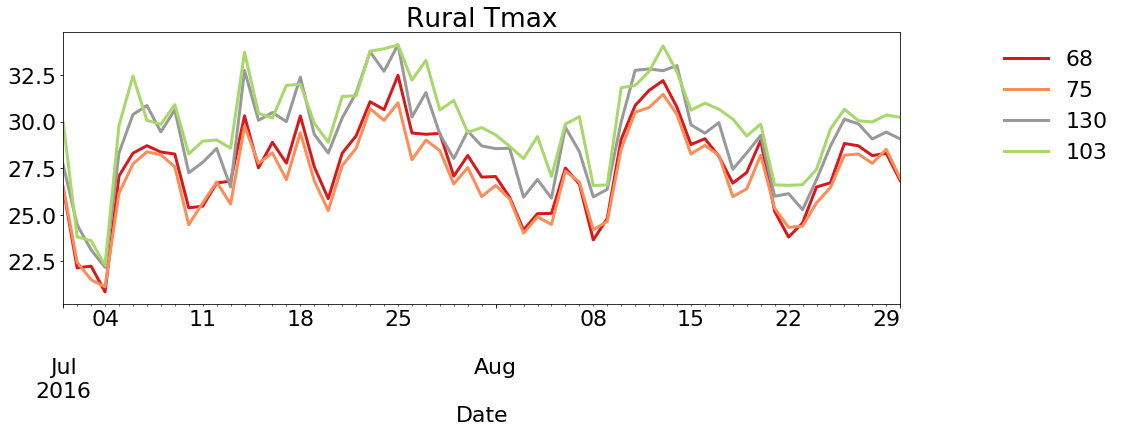

In [594]:
tempDF[[68, 75, 130, 103]].resample('D').max().plot(figsize = [15,5], title = 'Rural Tmax')
plt.legend(bbox_to_anchor=(1.1, 1.01),loc=2,frameon=False)

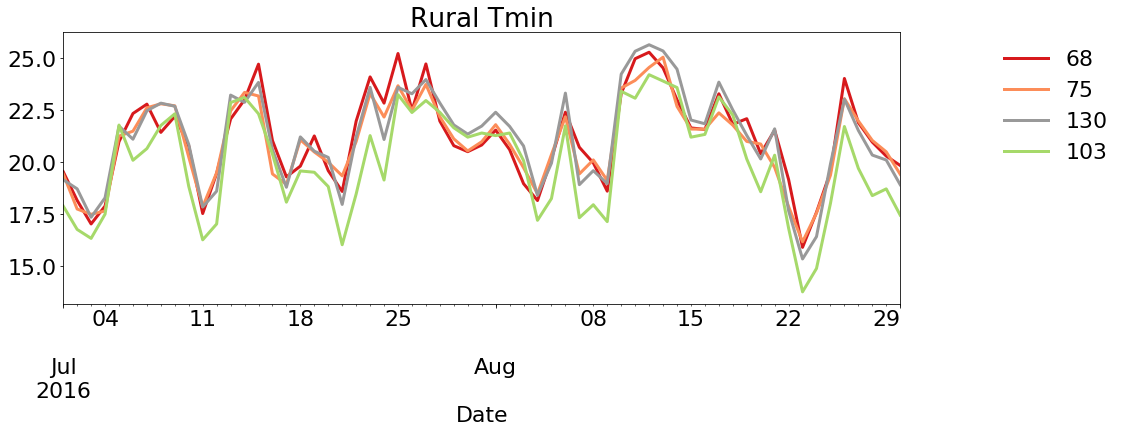

In [597]:
tempDF[[68, 75, 130, 103]].resample('D').min().plot(figsize = [15,5], title = 'Rural Tmin')
plt.legend(bbox_to_anchor=(1.1, 1.01),loc=2,frameon=False)

In [101]:
h = ax.boxplot(data, positions=[0,1,2,3,4],  
                     boxprops=(dict( linestyle='-',linewidth=3, color='k')), 
                     whiskerprops=dict(color='k',linewidth=3,),flierprops = dict(marker='x', color='k'),
                    medianprops = dict(linestyle='-', color='k',linewidth=3,))


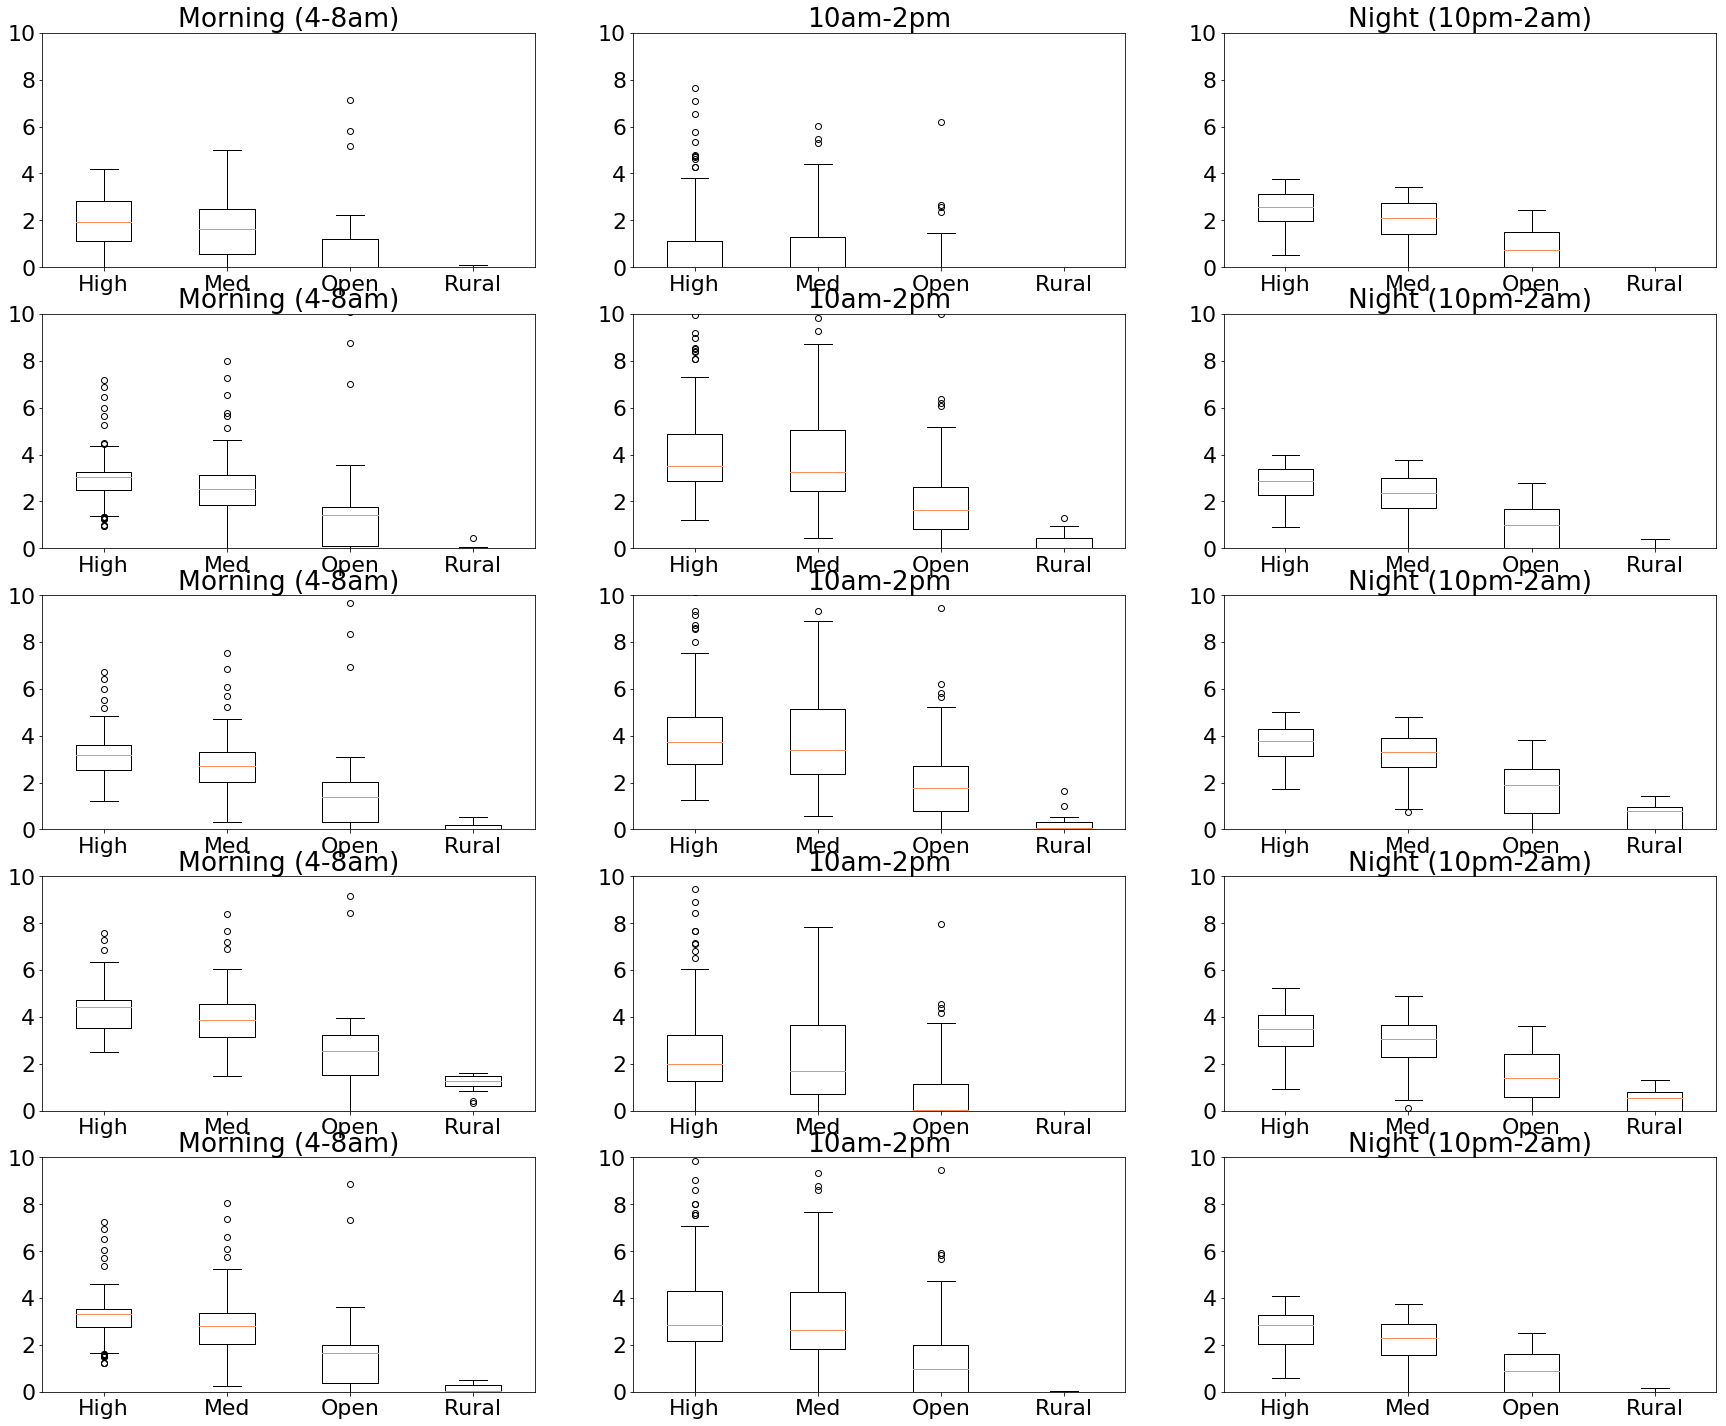

In [124]:
plt.figure(figsize = [15,5])
i = 1
bwi = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
ibutton = tempDF[[68]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton00 = tempDF[[75]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton01 = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)

plt.figure(figsize=[30,25])
i = 1
for obs_rural, title in zip([bwi,ibutton,ibutton00, ibutton01, ibutton2], ['bwi', 'iButton 68', 'iButton 75', 'iButton 103', 'iButton 130']): 
    ax = plt.subplot(5,3,i)
    box_data = []
    for lc in [ 26.,25,23,  28.]:
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
        box_data.append(data.loc[4:8].values.flatten()) 
    handles = plt.boxplot(box_data)
    tick_handles = plt.xticks([1,2,3,4], ['High', 'Med', 'Open', 'Rural'])
    plt.title('Morning (4-8am)')
    ax.set_ylim([0,10])
    ax.set_ylabel('')
    ax = plt.subplot(5,3,i+1)

    box_data = []
    for lc in [ 26.,25,23,  28.]:
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
        box_data.append(data.loc[10:14].values.flatten()) 
    handles = plt.boxplot(box_data)
    ax.set_ylim([0,10])
    tick_handles = plt.xticks([1,2,3,4], ['High', 'Med', 'Open', 'Rural'])
    plt.title('10am-2pm')

    ax = plt.subplot(5,3,i+2)
    box_data = []
    for lc in [ 26.,25,23,  28.]:
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
        box_data.append(data.loc[[22,23,0,2,]].values.flatten()) 
    handles = plt.boxplot(box_data)
    ax.set_ylim([0,10])
    tick_handles = plt.xticks([1,2,3,4], ['High', 'Med', 'Open', 'Rural'])
    plt.title('Night (10pm-2am)')
    i = i+3
plt.subplots_adjust(wspace=.5)

In [ ]:
box_data = []
for lc in [ 26.,25,23,  28.]:
    data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    box_data.append(data.loc[].values.flatten()) 
handles = plt.boxplot(box_data)
tick_handles = plt.xticks([1,2,3,4], ['High', 'Med', 'Open', 'Rural'])
plt.title('Morning UHI')

In [ ]:
bwi = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
ibutton = tempDF[[68]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton00 = tempDF[[75]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton01 = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)
plt.figure(figsize=[30,10])
i = 1
for obs_rural, title in zip([bwi,ibutton,ibutton00, ibutton01, ibutton2], ['bwi', 'iButton 68', 'iButton 75', 'iButton 103', 'iButton 130']): 
    ax = plt.subplot(2,5,i)
    for lc in [ 26.,25,23,  28.]:
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
        x = data.loc[10:14].mean(axis=0)
        y = data.loc[[22,23,0,1]].mean(axis=0)
        plt.scatter( x,y)
        #print(np.corrcoef(x,y)[0,1])
    plt.plot(np.linspace(0,8,10), np.linspace(0,8,10), 'k')
    #plt.plot(x,x)#plt.plot(x,-1*x +x.max() )
    plt.xlabel('$\Delta T$ Daytime')
    plt.ylabel('$\Delta T$ Night')
    plt.title(title)
    plt.ylim([-2,8])
    plt.xlim([-2,8])
#     plt.text(3,7, 'r = %1.2f'%np.corrcoef(x,y)[0,1],
#      #horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
    i = i+1


0.631424091622
0.636008347763
0.646405999347
-0.607548331204
0.631424091622
0.636008347763
0.646405999347
-0.607548331204
0.631424091622
0.636008347763
0.646405999347
-0.607548331204
0.631424091622
0.636008347763
0.646405999347
-0.607548331204
0.631424091622
0.636008347763
0.646405999347
-0.607548331204


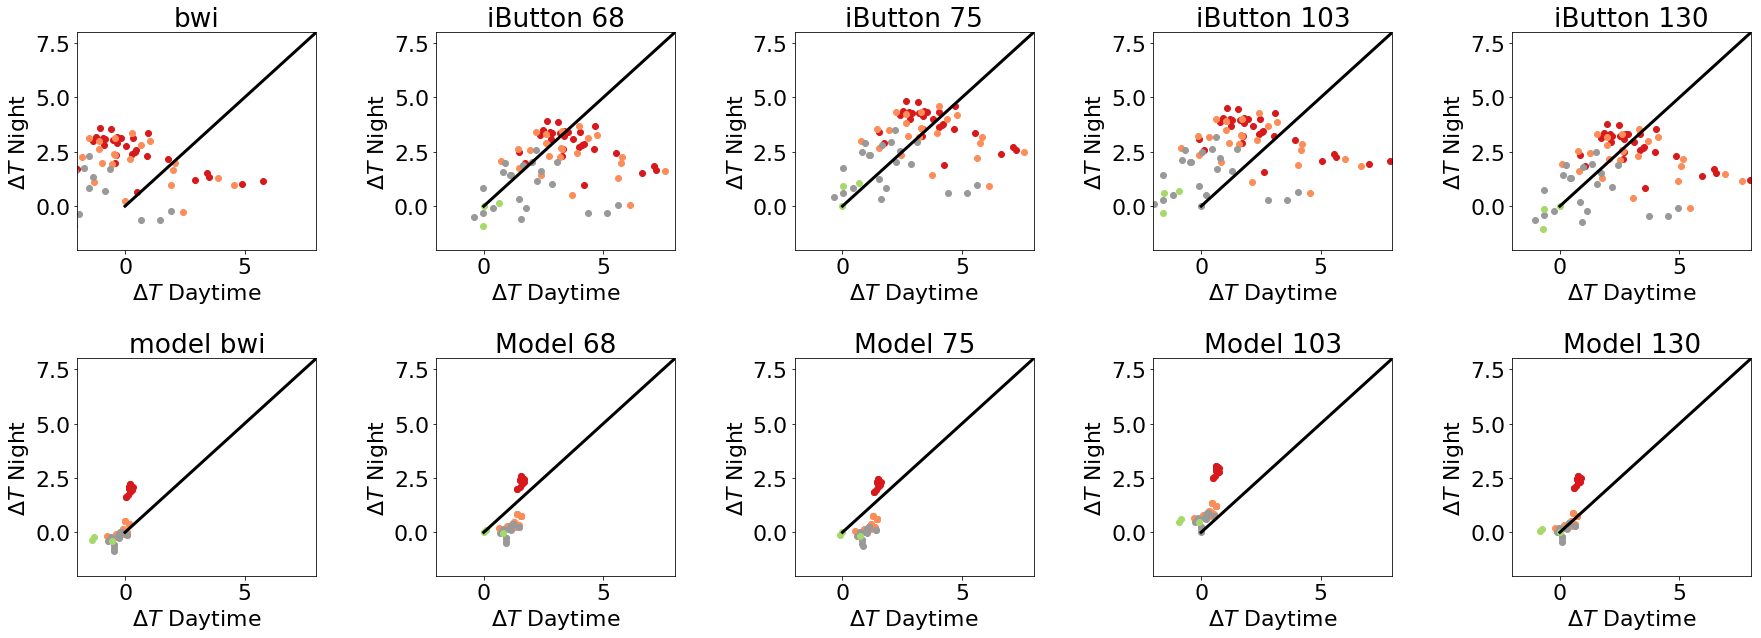

In [881]:

bwi = model_bwi['0.0'].groupby(model_bwi.index.hour).mean()
ibutton = model[[68]].groupby(model.index.hour).mean().mean(axis=1)
ibutton00 = model[[75]].groupby(model.index.hour).mean().mean(axis=1)
ibutton01 = model[[103]].groupby(model.index.hour).mean().mean(axis=1)
ibutton2= model[[130]].groupby(model.index.hour).mean().mean(axis=1)
for model_rural, title in zip([bwi,ibutton,ibutton00, ibutton01, ibutton2], ['model bwi', 'Model 68', 'Model 75', 'Model 103', 'Model 130']): 
    ax = plt.subplot(2,5,i)
    for lc in [ 26.,25,23,  28.]:
        data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean()).subtract(model_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
        x = data.loc[10:14].mean(axis=0)
        y = data.loc[[22,23,0,1]].mean(axis=0)
        plt.scatter( x,y)
        print(np.corrcoef(x,y)[0,1])
    plt.plot(np.linspace(0,8,10), np.linspace(0,8,10), 'k')
    #plt.plot(x,x)#plt.plot(x,-1*x +x.max() )
    plt.xlabel('$\Delta T$ Daytime')
    plt.ylabel('$\Delta T$ Night')
    plt.title(title)
    plt.ylim([-2,8])
    plt.xlim([-2,8])
#     plt.text(3,7, 'r = %1.2f'%np.corrcoef(x,y)[0,1],
#      #horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
    i = i+1
plt.subplots_adjust(wspace=.5, hspace = 0.5)

In [877]:
satellitedf['ndvi'][[68,75,103,130]]

Unnamed: 0
68     0.527851
75     0.457631
103    0.524227
130    0.450265
Name: ndvi, dtype: float64

In [880]:
vff.loc[[68,75,103,130]]

VF
Unnamed: 0           
68          81.528183
75          74.932465
103         66.301079
130         79.935478

In [862]:
data.loc[12:4]

Empty DataFrame
Columns: [10, 80, 71, 35, 27, 88, 70, 40, 132, 33, 102, 124, 60, 47, 98, 107, 97, 66, 122, 108, 137, 77, 141, 126, 78, 62, 24, 65, 29]
Index: []

[0 rows x 29 columns]

In [863]:
data

10        80        71        35        27        88        70   \
Date                                                                         
0     2.159311  4.286164  4.253738  3.095311  2.651262  4.097705  4.224443   
1     2.446574  4.520377  4.485852  3.382705  2.840164  4.371787  4.447230   
2     2.738033  4.638836  4.616557  3.502066  3.090607  4.562918  4.610754   
3     2.752803  4.638328  4.637475  3.549672  3.146361  4.598344  4.675705   
4     2.780738  4.655066  4.643049  3.553180  3.100557  4.644869  4.711049   
5     2.906066  4.670738  4.649607  3.530951  3.225918  4.673082  4.738000   
6     2.941262  4.685492  4.633492  3.541492  3.236525  4.674426  4.703459   
7     3.579492  4.517197  4.516475  3.597721  4.432148  4.442557  4.487131   
8     6.363590  3.390918  3.503934  3.300180  7.265361  3.295705  3.482705   
9     8.859803  1.664902  1.919279  2.626623  7.141033  1.649508  1.681967   
10    8.897590  0.607033  1.135902  1.812934  6.516197  0.854721  0.842262   
11    7.650033  0.275951  1.085557  1.474410  5.694672  0.622033  0.767393   
12    7.093869  0.591197  1.855311  1.671574  5.335000  0.751803  1.213607   
13    5.912574  1.225770  2.266869  1.800066  5.161033  0.826541  1.442836   
14    5.570508  1.881475  2.625967  1.859000  4.982902  0.876656  1.707787   
15    5.165131  1.579541  2.729246  2.075525  5.101820  0.953328  1.940131   
16    4.798475  1.181344  2.753754  2.723721  5.415049  0.871377  1.885689   
17    4.379656  1.232590  2.632934  2.256230  4.799475  0.819311  1.730213   
18    3.934508  1.363426  1.947246  1.271148  4.051180  0.420082  1.314705   
19    2.712098  1.086262  1.171361  0.532754  2.951279  0.243967  1.095754   
20    0.173721  1.615115  1.698770  0.616590  1.042721  1.173836  1.781934   
21    0.663311  2.838557  2.870869  1.696820  1.507721  2.539492  2.897770   
22    1.222967  3.509246  3.498443  2.306066  1.854311  3.224426  3.478295   
23    1.847344  3.972967  3.990754  2.799541  2.322852  3.770180  3.943082   

           40        132       33     ...          108       137       77   \
Date                                  ...                                    
0     2.334197  2.365844  3.464148    ...     3.997033  1.815358  3.544410   
1     2.539607  2.520011  3.784410    ...     4.193328  2.144599  3.898459   
2     2.749115  2.755193  3.953049    ...     4.297393  2.319677  4.032262   
3     2.796623  2.897347  4.000721    ...     4.328557  2.450679  4.165984   
4     2.750639  2.842919  4.045213    ...     4.337148  2.494898  4.283230   
5     2.835098  2.925921  4.105000    ...     4.350820  2.539641  4.422869   
6     2.845541  2.925188  4.090984    ...     4.356180  2.486967  4.653787   
7     3.901934  3.782117  4.147164    ...     4.389803  2.860334  5.709770   
8     7.561049  6.838508  3.431508    ...     3.643705  2.738869  5.664557   
9     9.291262  6.742083  2.159967    ...     2.168623  1.888028  4.399525   
10    9.441115  6.065064  1.763738    ...     1.315443  1.249432  3.232213   
11    8.446934  5.339848  1.473918    ...     1.139951  1.317143  2.701951   
12    7.670066  4.805178  1.785164    ...     1.693459  1.957682  2.646066   
13    7.160164  4.653481  1.978656    ...     2.366820  4.241370  2.284377   
14    6.793230  4.342372  1.800180    ...     2.396131  4.431272  1.295590   
15    6.706885  4.378738  1.615705    ...     2.422459  4.755684  1.032410   
16    6.610115  4.197406  1.290361    ...     2.402836  4.953675  0.652803   
17    5.717311  3.973904  0.855705    ...     2.281230  4.153630  0.389016   
18    4.520230  3.380015  0.296180    ...     1.278361  0.409631 -0.254689   
19    1.663623  2.199523 -0.016574    ...     0.656148 -0.911442 -0.742820   
20    0.159230  0.728605  0.616049    ...     1.512393 -0.774340  0.239393   
21    0.870607  1.138631  1.860459    ...     2.716426  0.213711  1.676885   
22    1.414213  1.510370  2.568115    ...     3.306197  0.915584  2.558410   
23    1.932000  1.972193  3.0863

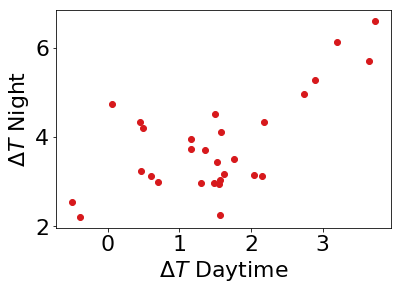

In [865]:
#for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
lc = 26#    ax = plt.subplot(1,4, i)
data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
plt.scatter(data.loc[16:20].mean(axis=0), 
           data.loc[6:10].mean(axis=0))
plt.xlabel('$\Delta T$ Daytime')
plt.ylabel('$\Delta T$ Night')

In [ ]:
#for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
lc = 26#    ax = plt.subplot(1,4, i)
data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
plt.scatter(data.loc[10:14].mean(axis=0), 
           data.loc[[22,23,0,1]].mean(axis=0))
plt.xlabel('$\Delta T$ Daytime')
plt.ylabel('$\Delta T$ Night')

In [ ]:
#for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
lc = 26#    ax = plt.subplot(1,4, i)
data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
plt.scatter(data.loc[10:14].mean(axis=0), 
           data.loc[[22,23,0,1]].mean(axis=0))
plt.xlabel('$\Delta T$ Daytime')
plt.ylabel('$\Delta T$ Night')

In [818]:
data.loc[[22,23,0,1]]#.mean(axis=0)

10        80        71        35        27        88        70   \
Date                                                                         
22    1.222967  3.509246  3.498443  2.306066  1.854311  3.224426  3.478295   
23    1.847344  3.972967  3.990754  2.799541  2.322852  3.770180  3.943082   
0     2.159311  4.286164  4.253738  3.095311  2.651262  4.097705  4.224443   
1     2.446574  4.520377  4.485852  3.382705  2.840164  4.371787  4.447230   

           40        132       33     ...          108       137       77   \
Date                                  ...                                    
22    1.414213  1.510370  2.568115    ...     3.306197  0.915584  2.558410   
23    1.932000  1.972193  3.086311    ...     3.761672  1.358448  3.181984   
0     2.334197  2.365844  3.464148    ...     3.997033  1.815358  3.544410   
1     2.539607  2.520011  3.784410    ...     4.193328  2.144599  3.898459   

           141       126       78        62        24        65        29   
Date                                                                        
22    1.960944  3.941016  3.437246  3.345344  2.381492  2.991574  2.306705  
23    2.447668  4.365852  3.928852  3.869377  2.956787  3.567984  2.922902  
0     2.828378  4.650246  4.223656  4.150754  3.301639  3.938541  3.366115  
1     3.105354  4.884475  4.484492  4.425738  3.531525  4.242377  3.702639  

[4 rows x 29 columns]

In [8]:
tempDF.min().min(), tempDF.max().max(), tempDF.mean().mean()

(13.757734767000001, 48.0169743537, 26.951557506213774)

In [14]:
tempDF[tempDF.index.hour==6].mean().mean(), tempDF[tempDF.index.hour==16].mean().mean()

(23.66165586656399, 30.086906195118818)

In [18]:
 tempDF.mean().max() -tempDF.mean().min()

5.5585587431693142

In [19]:
tempDF.mean().std()

1.1938613086459238

In [370]:
# are we still not different from SciCenter? 
obs['urban']

valid
2016-04-30 20:00:00    13.9
2016-04-30 21:00:00    13.3
2016-04-30 22:00:00    13.3
2016-04-30 23:00:00    12.2
2016-05-01 00:00:00    12.2
2016-05-01 01:00:00    11.7
2016-05-01 02:00:00    11.1
2016-05-01 03:00:00    10.6
2016-05-01 04:00:00    10.6
2016-05-01 05:00:00    10.6
2016-05-01 06:00:00    10.6
2016-05-01 07:00:00    10.6
2016-05-01 08:00:00    10.6
2016-05-01 09:00:00    11.1
2016-05-01 10:00:00    11.1
2016-05-01 11:00:00    11.1
2016-05-01 12:00:00    11.7
2016-05-01 13:00:00    11.7
2016-05-01 14:00:00    12.2
2016-05-01 15:00:00    12.8
2016-05-01 16:00:00    12.8
2016-05-01 17:00:00    12.8
2016-05-01 18:00:00    12.8
2016-05-01 19:00:00    12.8
2016-05-01 20:00:00    12.2
2016-05-01 21:00:00    12.2
2016-05-01 22:00:00    12.2
2016-05-01 23:00:00    12.8
2016-05-02 00:00:00    12.2
2016-05-02 01:00:00    12.2
                       ... 
2016-09-03 14:00:00    25.6
2016-09-03 15:00:00    25.6
2016-09-03 16:00:00    25.6
2016-09-03 17:00:00    25.0
2016-09-03 18:

In [376]:
tempDF.subtract(obs['urban'][tempDF.index[0]:tempDF.index[-1]], axis=0).mean().mean()

-0.8559941249359292

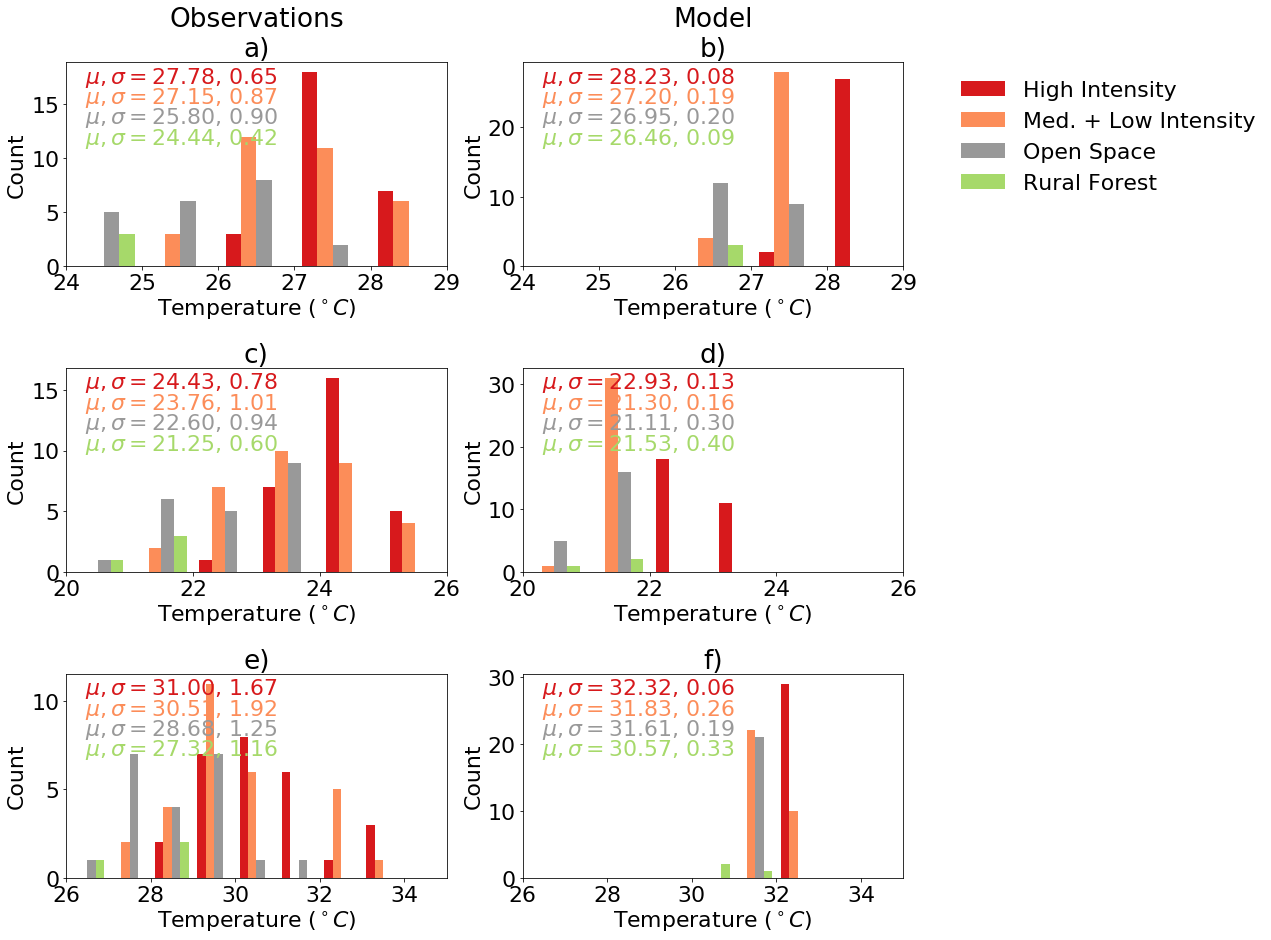

In [513]:
# Histogram of temperature by lancover type

bbins = [  np.linspace(24,29,6), np.linspace(24,29,6),# bins for all data
            np.linspace(20,26,7), np.linspace(20,26,7), # bins for 6am data
           np.linspace(26,34,9),  np.linspace(26,34,9),# bins for 4pm data]
]
iii = 1
fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[lcc[(lcc.LCC==26)].index].mean(),
        tempDF[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#    ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1

ax.hist(data, bins = bbins[0])
ax.set_title('Observations\na)')
ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
#labels = ['Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']
labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
#plt.legend(labels,loc =2)

ax = plt.subplot(3,2,2)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        model.dropna()[lcc[(lcc.LCC==26)].index].mean(),
        model.dropna()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        model.dropna()[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        model.dropna()[lcc[lcc.LCC ==28].index].mean(),#.dropna().values.flatten(),
       ]
ax.hist(data, bins = bbins[1])
plt.legend(labels, bbox_to_anchor=(1.1, 1.01),loc=2,frameon=False)

#plt.legend(labels,loc =2)#bbox_to_anchor=(1.1, 1.01))
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#    ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1
ax.set_xlim([24,32])
ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
ax.set_title('Model\nb)')

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC==26)].index].mean(),
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[tempDF.index.hour ==hr][[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
    ax.hist(data, bins = bbins[iii-1] )
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    ax.set_xlabel('Temperature ($^\circ C$)')
    ax.set_ylabel('Count')
    i = 0
    for d in data: 
        ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#        ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        i = i+1
    iii =iii+1
    
    ax = plt.subplot(3,2,iii)

    data = [#tempDF.dropna().mean().values.flatten(), # all data
        model[model.index.hour ==hr][lcc[(lcc.LCC==26)].index].mean(),
        model[model.index.hour ==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        model[model.index.hour ==hr][lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        model[model.index.hour ==hr][lcc[lcc.LCC ==28].index].mean(),#.dropna().values.flatten(),
       ]
    ax.hist(data, bins = bbins[iii-1] )
    i = 0
    for d in data: 
        ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#        ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        i = i+1

    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    ax.set_xlabel('Temperature ($^\circ C$)')
    ax.set_ylabel('Count')
    iii =iii+1
#plt.legend(labels,frameon=False)
# set xlimit bounds for a and b
for iii in [1,2]:
    ax = plt.subplot(3,2,iii)
    ax.set_xlim([24,29])
# set xlimit bounds for c and d
for iii in [3,4]:
    ax = plt.subplot(3,2,iii)
    ax.set_xlim([20,26])
# set xlimit bounds for e and f
for iii in [5,6]:
    ax = plt.subplot(3,2,iii)
    ax.set_xlim([26,35])

plt.subplots_adjust(hspace=.5)
plt.savefig('figures/landcover_distribution.eps',bbox_inches='tight')

In [410]:
517.07/5.

103.41400000000002

In [401]:
np.linspace(26,34,9)

array([ 26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.])

(array([  2.,   9.,  11.,  25.,  15.,   7.,   6.,   4.]),
 array([ 26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.]),
 <a list of 8 Patch objects>)

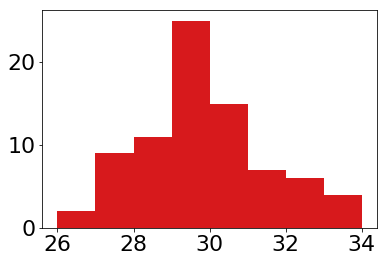

In [402]:
plt.hist(data, bins = np.linspace(26,34,9))

(24, 29)

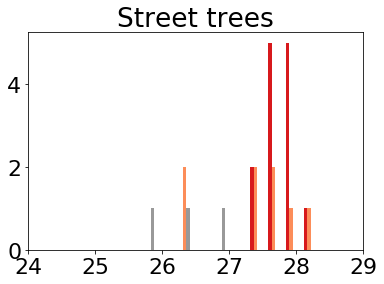

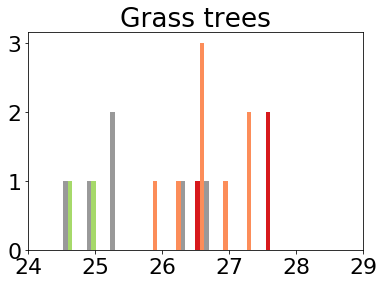

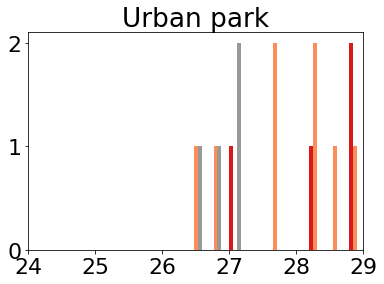

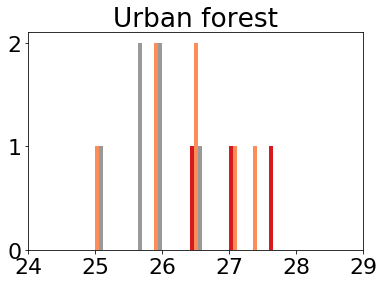

In [214]:
x1 = 24
x2 = 29
# imp = meta[(meta.landcoverclass=='impervious') & (meta.attachment !='tree')].index
# data = [tempDF[np.intersect1d(lcc[lcc.LCC==26].index, imp)].mean(), 
#     tempDF[np.intersect1d(lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index, imp)].mean(), 
#     tempDF[np.intersect1d(lcc[lcc.LCC==23].index, imp)].mean(), 
#     tempDF[np.intersect1d(lcc[lcc.LCC==28].index, imp)].mean(), 
#    ]
# plt.figure()
# plt.hist(data) 
# plt.title('Impervious')
# plt.xlim(x1,x2)

imp = meta[(meta.landcoverclass=='impervious') & (meta.attachment =='tree')].index
data = [tempDF[np.intersect1d(lcc[lcc.LCC==26].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==23].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==28].index, imp)].mean(), 
   ]
plt.figure()
plt.hist(data)
plt.title('Street trees')
plt.xlim(x1,x2)

imp = meta[(meta.landcoverclass=='grass') & (meta.attachment =='tree')].index
data = [tempDF[np.intersect1d(lcc[lcc.LCC==26].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==23].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==28].index, imp)].mean(), 
   ]
plt.figure()
plt.hist(data)
plt.title('Grass trees')
plt.xlim(x1,x2)

imp = meta[(meta.vesacategory=='o')].index
data = [tempDF[np.intersect1d(lcc[lcc.LCC==26].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==23].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==28].index, imp)].mean(), 
   ]
plt.figure()
plt.hist(data)
plt.title('Urban park')
plt.xlim(x1,x2)

imp = meta[(meta.vesacategory=='f')].index
data = [tempDF[np.intersect1d(lcc[lcc.LCC==26].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==23].index, imp)].mean(), 
    tempDF[np.intersect1d(lcc[lcc.LCC==28].index, imp)].mean(), 
   ]
plt.figure()
plt.hist(data)
plt.title('Urban forest')
plt.xlim(x1,x2)

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: invalid value encountered in double_scalars


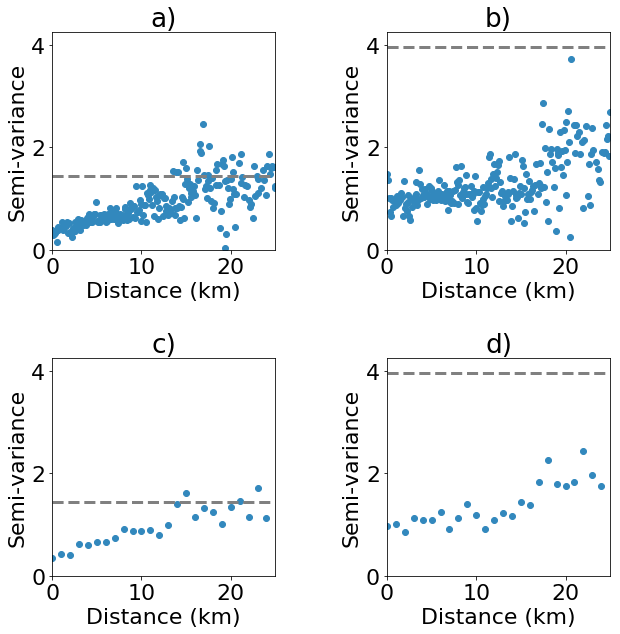

In [530]:
# Observations
r_earth = 6371
# pts_df = pts.T.to_pandas()
# pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
#fig =plt.figure(figsize=[25,10])
fig =plt.figure(figsize=[10,10])

iii = 1
caption = []
#### clean this data!!!!    
locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values


hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    ax.set_ylim([0,4.25])
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_obs.eps',bbox_inches='tight')

#iii = 1
caption = []
#### clean this data!!!!    
locations0 = pts_df
data0 = model.mean()

locations1 = pts_df.loc[lcc[lcc.LCC ==26].index]
data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean()

locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]
data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean()

locations3 = pts_df.loc[lcc[lcc.LCC ==23].index]
data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean()    

locations4 = pts_df.loc[lcc[lcc.LCC ==28].index]
data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean()

hs = np.linspace(0,25,26)
bandwidth =1# np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
#    data = data[data.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
    ax.set_ylim([0,4.25])
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_model.eps',bbox_inches='tight')
plt.savefig('figures/semivariogram.eps',bbox_inches='tight')

In [24]:
tempDF[tempDF.index.hour==6].mean().var(), tempDF[tempDF.index.hour==16].mean().var()

(1.4156509742053016, 3.939220389964565)

In [776]:
hs[2]-hs[1]

0.10000000000000001

In [33]:
tempDF.mean()

82     25.694325
139    28.178058
130    24.795002
32     25.643905
10     28.883384
129    26.461925
105    27.444336
80     27.511677
34     25.955324
71     27.907259
35     27.259502
106    24.336994
91     26.828684
131    27.712630
19     26.659237
42     26.381811
27     28.854913
5      27.699723
88     27.275434
72     27.400992
70     27.643986
40     29.348440
132    28.364319
48     28.325548
143    26.448841
120    28.402873
33     27.241996
54     26.546231
102    27.636999
124    28.055431
         ...    
41           NaN
103    24.818824
123    26.380544
50     28.456567
108    27.706828
12     26.648685
100    27.854271
137    26.992682
77     27.555009
136    26.409119
22     27.238672
90     24.494404
31     27.129419
92     27.242899
2      27.151098
110    25.074527
11     25.698893
141    26.267559
126    27.987738
78     27.980337
62     27.733940
24     28.188391
75     23.789881
65     27.305074
85     25.923213
29     26.461943
144    26.500567
21     26.0478

In [50]:
data0.dropna().shape

(90,)

In [49]:
locations0.dropna().shape

(86, 2)

In [60]:
ind = ~np.isnan(data0) & ~np.isnan(locations0[:,0])

TypeError: unhashable type

In [63]:
~np.isnan(locations0[:,0])

TypeError: unhashable type

In [68]:
~np.isnan(locations[:,0])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [58]:
~np.isnan(data0)

82      True
139     True
130     True
32      True
10      True
129     True
105     True
80      True
34      True
71      True
35      True
106     True
91      True
131     True
19      True
42      True
27      True
5       True
88      True
72      True
70      True
40      True
132     True
48      True
143     True
120     True
33      True
54      True
102     True
124     True
       ...  
41     False
103     True
123     True
50      True
108     True
12      True
100     True
137     True
77      True
136     True
22      True
90      True
31      True
92      True
2       True
110     True
11      True
141     True
126     True
78      True
62      True
24      True
75      True
65      True
85      True
29      True
144     True
21      True
134     True
44      True
Length: 91, dtype: bool

In [56]:
locations0.shape

(91, 2)

In [53]:
data0.loc[locations0.dropna().index]

sensornumber
82.0     25.694325
139.0    28.178058
130.0    24.795002
32.0     25.643905
10.0     28.883384
129.0    26.461925
105.0    27.444336
80.0     27.511677
34.0     25.955324
71.0     27.907259
35.0     27.259502
106.0    24.336994
91.0     26.828684
19.0     26.659237
42.0     26.381811
27.0     28.854913
5.0      27.699723
88.0     27.275434
72.0     27.400992
70.0     27.643986
40.0     29.348440
132.0    28.364319
48.0     28.325548
33.0     27.241996
54.0     26.546231
102.0    27.636999
124.0    28.055431
127.0    26.152001
64.0     25.279561
79.0     26.907205
           ...    
73.0     26.118514
41.0           NaN
103.0    24.818824
123.0    26.380544
50.0     28.456567
108.0    27.706828
12.0     26.648685
100.0    27.854271
137.0    26.992682
77.0     27.555009
22.0     27.238672
90.0     24.494404
31.0     27.129419
92.0     27.242899
2.0      27.151098
110.0    25.074527
11.0     25.698893
141.0    26.267559
126.0    27.987738
78.0     27.980337
62.0     27.733940

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in double_scalars


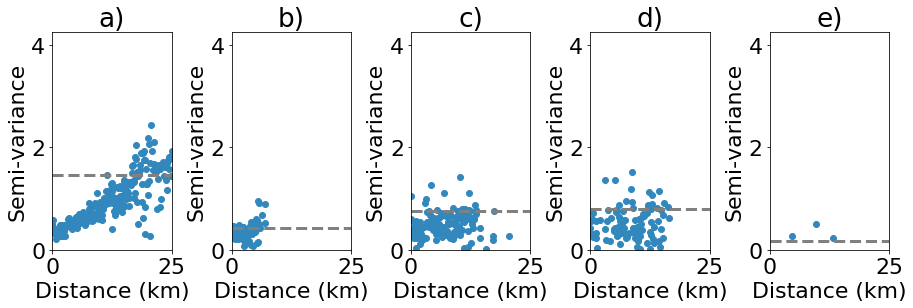

In [74]:
r_earth = 6371
plt.figure(figsize = [15,10])
# pts_df = pts.T.to_pandas()
# pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values

caption = []
hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
iii = 1
for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
#label = 'All data'
    # clean data 
#for hr in [6,16]: 
#     locations = locations0
#     data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
    ax = plt.subplot(2,5,iii)
#    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    ax.set_ylim([0,4.25])
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)

In [75]:
caption = []
plt.figure(figsize = [15,10])
#### clean this data!!!!    
locations0 = pts_df
data0 = model.mean()

locations1 = pts_df.loc[lcc[lcc.LCC ==26].index]
data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean()

locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]
data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean()

locations3 = pts_df.loc[lcc[lcc.LCC ==23].index]
data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean()    

locations4 = pts_df.loc[lcc[lcc.LCC ==28].index]
data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean()
iii = 1
hs = np.linspace(0,25,26)
hr = 6
bandwidth =1# np.abs(hs[1]-hs[0])
for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
    #label = 'All data'
    # clean data 
#for hr in [6,16]: 
#     locations = locations0
#     data = tempDF[tempDF.index.hour==hr].mean()
#    data = data[data.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
    ax.set_ylim([0,4.25])
plt.subplots_adjust(hspace=.5,wspace =0.5)

NameError: name 'pts_df' is not defined

In [ ]:
# Observations
r_earth = 6371
# pts_df = pts.T.to_pandas()
# pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
#fig =plt.figure(figsize=[25,10])
fig =plt.figure(figsize=[10,10])

iii = 1
caption = []
#### clean this data!!!!    
locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values


hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    ax.set_ylim([0,4.25])
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_obs.eps',bbox_inches='tight')

#iii = 1
caption = []
#### clean this data!!!!    
locations0 = pts_df
data0 = model.mean()

locations1 = pts_df.loc[lcc[lcc.LCC ==26].index]
data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean()

locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]
data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean()

locations3 = pts_df.loc[lcc[lcc.LCC ==23].index]
data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean()    

locations4 = pts_df.loc[lcc[lcc.LCC ==28].index]
data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean()

hs = np.linspace(0,25,26)
bandwidth =1# np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
#    data = data[data.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
    ax.set_ylim([0,4.25])
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_model.eps',bbox_inches='tight')

In [322]:
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
len(files)

2353

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in double_scalars


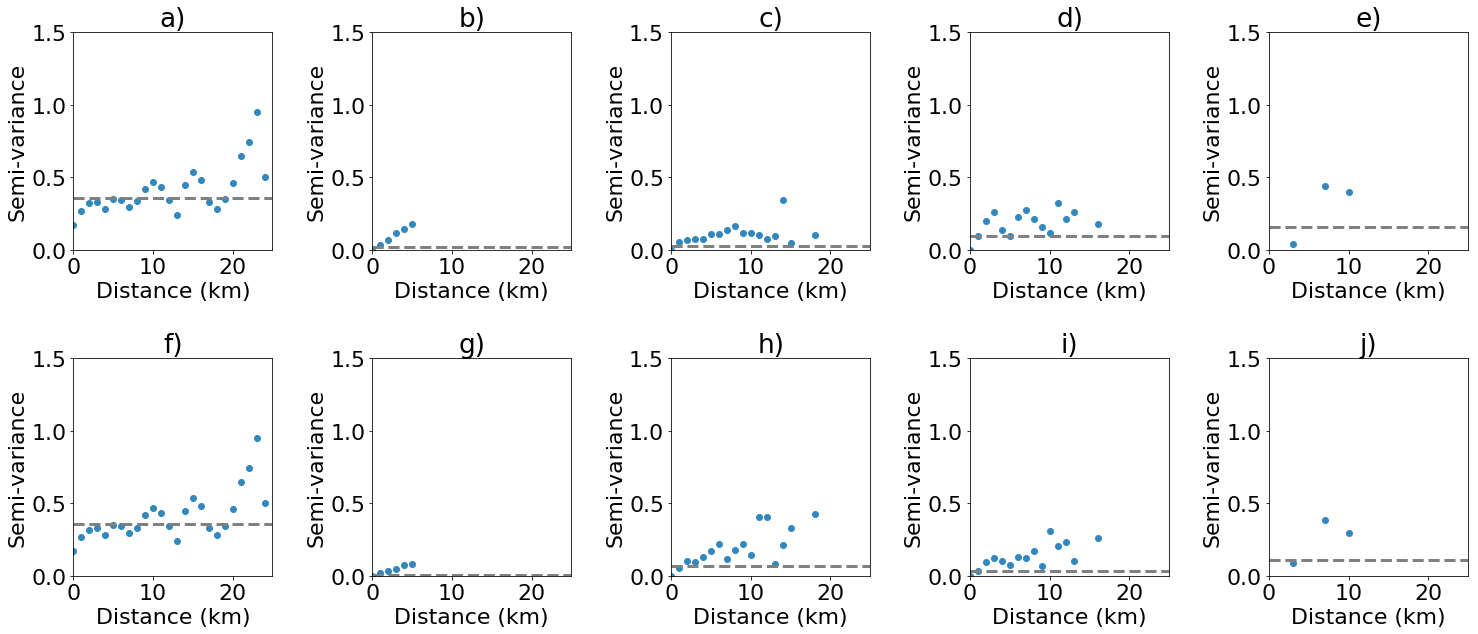

In [323]:
# Model
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
pts = wrf.ll_to_xy(Dataset(files[-1]), meta['location:Latitude'].dropna().values,
                       meta['location:Longitude'].dropna().values)
    
r_earth = 6371
pts_df = pts.T.to_pandas()
pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
fig =plt.figure(figsize=[25,10])
iii = 1
for hr in [6,16]: 
    locations0 = pts_df.values
    data0 = model.mean().values
    
    locations1 = pts_df.loc[lcc[lcc.LCC ==26].index].values
    data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean().values
    
    locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].values
    data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean().values
    
    locations3 = pts_df.loc[lcc[lcc.LCC ==23].index].values
    data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean().values    
    
    locations4 = pts_df.loc[lcc[lcc.LCC ==28].index].values
    data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean().values
    
    hs = np.linspace(0,25,26)
    bandwidth =1# np.abs(hs[1]-hs[0])
    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
        N = data.shape[0]
        ax = plt.subplot(2,5,iii)
        semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
        for h in hs:
            Z = []
            for i in range(N): 
                for j in range(i+1,N): 
                    #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                    if (distance >= h) and (distance< h+bandwidth):
                        Z.append(np.abs(data[i] - data[j])) 
            semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
        ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
        ax.axhline(data.var(), linestyle ='--', color = 'gray')
        ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
        #ax.set_title('%s , %i o\'clock '%(label,hr))
        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Semi-variance')
        ax.set_ylim([0,1.5])
        ax.set_xlim([0,25])

        iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.savefig('figures/semivariogram_model.eps')

In [4]:
# mean temp vs ndvi/gvf
exp = 'UCM+SST'
dom = 'd03'
vff = pd.read_csv('data/%s_%s_vf.csv'%(exp,dom)).set_index('Unnamed: 0')
satellitedf = pd.read_csv('data/satellite_values.csv').set_index('Unnamed: 0')

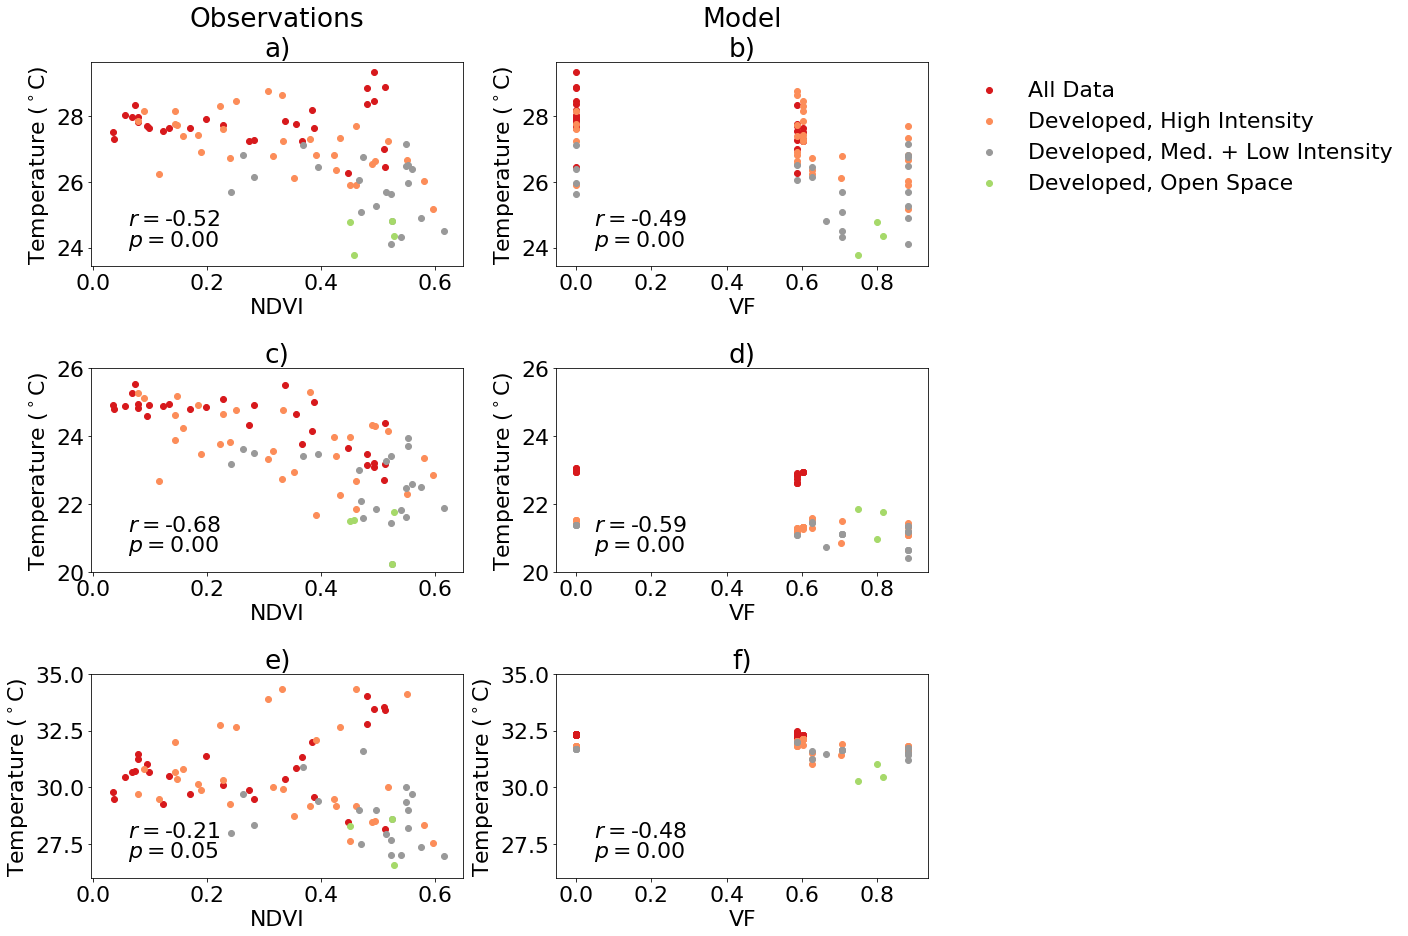

In [6]:
# mean temp vs ndvi/gvf
exp = 'UCM+SST'
dom = 'd03'
vff = pd.read_csv('data/%s_%s_vf.csv'%(exp,dom)).set_index('Unnamed: 0')
satellitedf = pd.read_csv('data/satellite_values.csv').set_index('Unnamed: 0')
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Observations\na)')

ax = plt.subplot(3,2,2)
x = vff['VF'].astype(float)*.01
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('VF')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Model\nb)')
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01))
ax.legend(labels,bbox_to_anchor=(1.05, 1.01),frameon=False)

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    x = satellitedf['ndvi'].astype(float).dropna()
    y = tempDF[tempDF.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        elif lc ==28: 
            plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
    ax.set_ylim([20,26])

#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    
    ax = plt.subplot(3,2,iii)
    x = vff['VF'].astype(float)*.01
    y = model[model.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('VF')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    ax.set_ylim([20,26])
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
plt.subplot(3,2,5).set_ylim([26,35])
plt.subplot(3,2,6).set_ylim([26,35])
plt.savefig('figures/vegetation_fraction.eps',bbox_inches='tight')

In [364]:
# correlation between Ndvi and vf
np.corrcoef(satellitedf['ndvi'].dropna(), vff['VF'])

array([[ 1.        ,  0.25482854],
       [ 0.25482854,  1.        ]])

In [628]:
pwd

u'/Users/ascott47/blausteinmount/finalthesischapter'

In [7]:
# # source activate mapping-wrf
# # functions for elevation, distance to park 
# from osgeo import ogr, osr
# import numpy as np
# import os
# import gdal
# import pandas as pd
# import shapely 
# import shapely.wkt
# from shapely.geometry import Point

# filepath = '/Users/ascott47/blausteinmount/cityheat/Bmore/2016/'
# meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
# meta = meta.set_index('sensornumber', drop = False)
# meta = meta.set_index(meta.index.astype('float64'), drop = False)
# lon = meta['location:Longitude'].values
# lat = meta['location:Latitude'].values
# def extract_raster_values(X,Y, rasterfile,x_radius =1, y_radius=1, how = 'none'):
#     # X = lon
#     # Y = lat
#     # x_radius =1
#     # y_radius=1
#     #how = 'none'
#     sourceEPSG = 4326
#     sourceProj = osr.SpatialReference()
#     sourceProj.ImportFromEPSG(sourceEPSG)

#     # Read in raster data to get info on the raster projection
#     layer = gdal.Open(rasterfile)
#     gt =layer.GetGeoTransform()
#     bands = layer.RasterCount

#     rasterProj = osr.SpatialReference()
#     rasterProj.ImportFromWkt(layer.GetProjection())
#     transform = osr.CoordinateTransformation(sourceProj, rasterProj)

#     elevation = np.zeros(X.shape[0])
#     src = layer.GetRasterBand(1)
#     i = 0
#     for xx,yy in zip(X,Y):
#         if ~np.isnan(xx) & ~np.isnan(yy):
#             point = ogr.Geometry(ogr.wkbPoint)
#             point.AddPoint(xx,yy)
#         # reproject the lat/lon point to the projection of the raster data
#             point.Transform(transform)

#             x = point.GetPoints()[0][0]
#             y = point.GetPoints()[0][1]

#             rasterx = int((x - gt[0]) / gt[1])
#             rastery = int((y - gt[3]) / gt[5])
#         else: 
#             elevation[i] = np.nan
#         if (rasterx > 0) & (rastery> 0): 
#             data = src.ReadAsArray(rasterx,rastery, win_xsize=x_radius, win_ysize=y_radius)
#             if data.shape == (1,1) :
#                 elevation[i] = data
#             elif how == 'mean' : # mean of raster data, eg, average number of trees for a given buffer
#                 elevation[i] = data.mean()
#             elif how == 'sum' : # total number of raster data, eg, total number of trees
#                 elevation[i] = data.sum()
#             elif how == 'density' : # compute the density of raster data, ie, tree canopy cover
#                 area = x_radius*y_radius
#                 elevation[i] = data.sum()/area
#             #print layer.GetRasterBand(1).ReadAsArray(rasterx,rastery, 1, 1)
#         else:
#             print('missing data at ', i)
#             elevation[i] = np.nan
#         i = i+1
#     return elevation

# def compute_distance_to_feature(X,Y,feature_file, feature_name = 'none', calculationProjection = 6347):
# # compute distance from an array of lons/lats to a feature
# # if multiple features in shapefile, specify feature_name
# #feature_file = 'data/Parks_Dissolved_reproj.shp'
# #feature_name = 'none'
# #calculationProjection = 6347
# #X = meta.drop(64, axis=0)['location:Longitude'][selected].values
# #Y = meta.drop(64, axis=0)['location:Latitude'][selected].values
    
#     #feature_file = 'data/Parks_Dissolved_reproj.shp'
#     # Read in shapefile for the feature
#     shapefile = ogr.Open(feature_file)
#     layer = shapefile.GetLayer(0)
    
#     # Select the correct feature
#     if feature_name == 'none': 
#         feature = layer.GetFeature(0)
#         geometry = feature.GetGeometryRef()
#     else: 
#         for i in range(layer.GetFeatureCount()):
#             feature = layer.GetFeature(i)
#             name = feature.GetField('name')
#             if name == feature_name : 
#                 geometry = feature.GetGeometryRef()
    
#     ### Transform
#     # reproject lat/lon values to the raster
#     inSpatialRef = osr.SpatialReference()
#     inSpatialRef.ImportFromEPSG(4326) # lat lon

#     outSpatialRef = osr.SpatialReference()
#     #outSpatialRef = layer.GetSpatialRef()
#     outSpatialRef.ImportFromEPSG(calculationProjection)
    
#     # create the CoordinateTransformation
#     coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
#     # check that the shapefile is in the correct projection
#     if geometry.GetSpatialReference() != outSpatialRef : 
#         # reproject 
#         coordTrans2 = osr.CoordinateTransformation(geometry.GetSpatialReference(), outSpatialRef)
#         geometry.Transform(coordTrans2)
    
#     shape = shapely.wkt.loads(geometry.ExportToWkt())
    
#     i = 0
#     distance_to_park = np.zeros(X.shape)
#     for (x,y) in zip(X,Y): 
#         point = ogr.Geometry(ogr.wkbPoint)
#         point.AddPoint(x,y)
#         point.Transform(coordTrans)
#         distance_to_park[i] = Point(point.GetPoints()[0]).distance(shape)
#         i = i+1
#     #distance_to_park = distance_to_park*2*np.pi/360*6371000.    
#     return distance_to_park
# fp = u'/Users/ascott47/blausteinmount/finalthesischapter/'

# feature_file = fp + 'data/parks/Parks_Dissolved_reproj.shp'
# distance_to_park = compute_distance_to_feature(lon,lat,feature_file, feature_name = 'none')
# pd.DataFrame(distance_to_park, index = meta.index).to_csv(fp + 'data/distance_to_park.csv')

# rasterfile = fp + 'data/BaltimoreDEM'
# elevation = extract_raster_values(lon,lat, rasterfile)
# rasterfile = fp+ 'data/Baltimore_DEM_2015_2.5ft/baltimore2015/dblbnd.adf'

# inds =el[0][np.isnan(el[0])].index
# lon = meta['location:Longitude'][inds].values
# lat = meta['location:Latitude'][inds].values
# elevation2 = extract_raster_values(lon,lat, rasterfile)
# el = pd.DataFrame(elevation, index = meta.index.astype(int))  
# el.loc[inds,0] = elevation2
# el.to_csv(fp + 'data/elevation.csv')

# calculate elevation from DEM 
elevation = pd.read_csv('data/elevation.csv').set_index('sensornumber')['0'].astype(float)
elevation.index = elevation.index.astype(int)
distance_to_park = pd.read_csv('data/distance_to_park.csv').set_index('sensornumber')['0'].astype(float)
distance_to_park.index = distance_to_park.index.astype(int)

#units are both in meters

In [12]:
def easy_scatter(x,y,title='', xlabel='', ylabel='', text_x = 0.5, text_y = 0.9) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.3f x + %.2f'%(m,b), xy=(text_x, text_y), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(text_x, text_y-.1), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(text_x, text_y-.2), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(text_x, text_y-.3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

In [210]:
tempDF[tempDF.index.hour==16].mean().mean()[distance_to_park < thresh]

TypeError: 'float' object has no attribute '__getitem__'

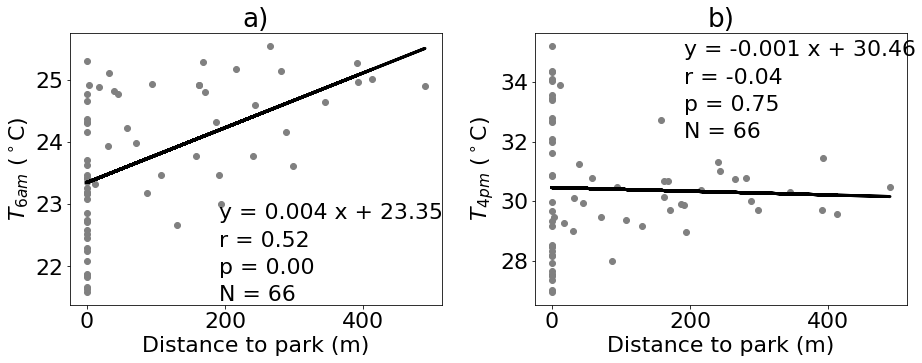

In [211]:
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
easy_scatter(distance_to_park[distance_to_park < thresh], 
             tempDF[tempDF.index.hour==6].mean()[distance_to_park < thresh], text_x =0.4, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{6am}$ ($^\circ $C)')
ax.set_title('a)')
ax = plt.subplot(1,2,2)
m,r,p = easy_scatter(distance_to_park[distance_to_park < thresh], 
             tempDF[tempDF.index.hour==16].mean()[distance_to_park < thresh], text_x = 0.4)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{4pm}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
plt.savefig('figures/distance_to_park.eps',bbox_inches='tight')

In [10]:
thresh = 500
distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)]

sensornumber
82      87.330699
129    107.447629
105    161.823521
35     240.278744
91      70.555629
88       3.333808
72      58.350309
70      94.024882
48     157.948007
33     187.055176
102    161.926652
124    489.801829
79     191.542608
69     344.983905
60     171.668332
74     298.149998
98     413.594490
107     38.721314
86     281.612586
53      11.363646
66     265.749314
99     215.428709
41     226.628805
50       0.923017
108    243.408529
100    391.848145
77      18.042666
22      45.546037
92     288.292840
126    168.002425
78     392.944843
62      32.498433
85     130.163539
21     193.902071
44      30.475764
Name: 0, dtype: float64

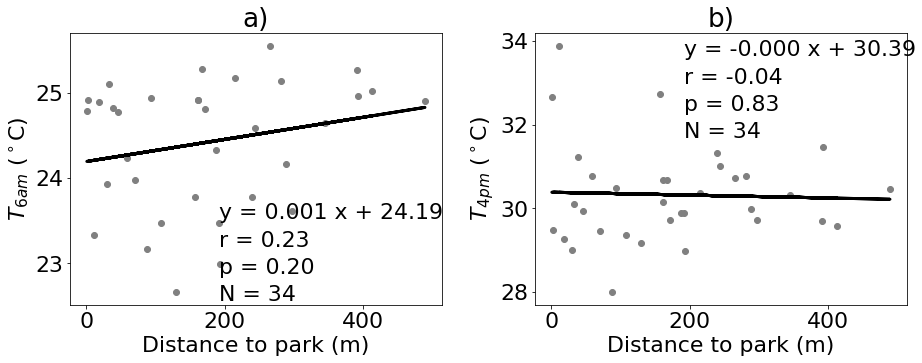

In [81]:
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
easy_scatter(distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)], 
             tempDF[tempDF.index.hour==6].mean()[(distance_to_park < thresh) & (distance_to_park >0)], text_x =0.4, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{6am}$ ($^\circ $C)')
ax.set_title('a)')
ax = plt.subplot(1,2,2)
m,r,p = easy_scatter(distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)], 
             tempDF[tempDF.index.hour==16].mean()[(distance_to_park < thresh) & (distance_to_park >0)], text_x = 0.4)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{4pm}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.savefig('figures/distance_to_park.eps',bbox_inches='tight')

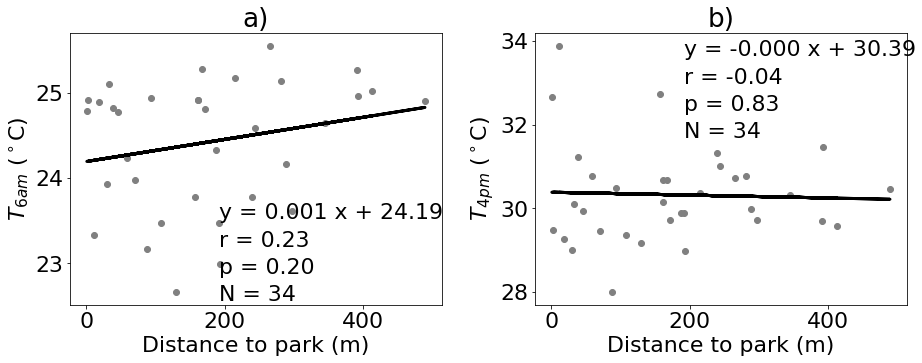

In [13]:
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
easy_scatter(distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)], 
             tempDF[tempDF.index.hour==6].mean()[(distance_to_park < thresh) & (distance_to_park >0)], text_x =0.4, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{6am}$ ($^\circ $C)')
ax.set_title('a)')
ax = plt.subplot(1,2,2)
m,r,p = easy_scatter(distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)], 
             tempDF[tempDF.index.hour==16].mean()[(distance_to_park < thresh) & (distance_to_park >0)], text_x = 0.4)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{4pm}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.savefig('figures/distance_to_park.eps',bbox_inches='tight')

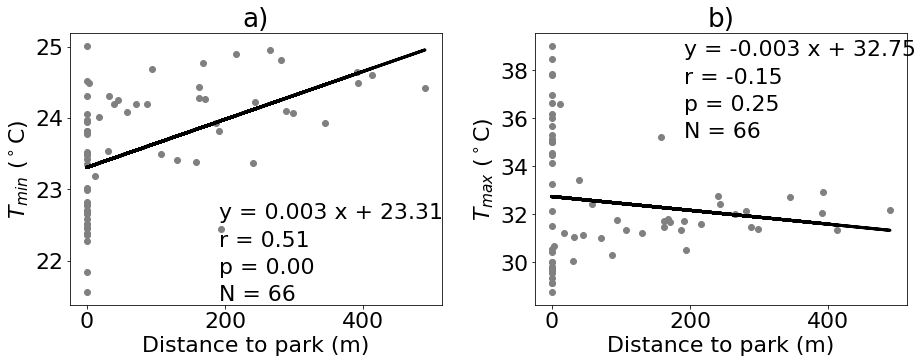

In [955]:
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
x = distance_to_park
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]

easy_scatter(x[x < thresh], 
             y[x < thresh], text_x =0.4, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{min}$ ($^\circ $C)')
ax.set_title('a)')

ax = plt.subplot(1,2,2)
x = distance_to_park
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]
m,r,p = easy_scatter(x[x < thresh], 
             y[x < thresh], text_x = 0.4)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{max}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.savefig('figures/distance_to_park_corrected.eps',bbox_inches='tight')

In [954]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [952]:
x = distance_to_park
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]
x.shape, y.shape

((90,), (90,))

In [948]:
x = distance_to_park
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]

In [949]:
x.shape, y.shape

((90,), (90,))

In [945]:
distance_to_park.shape, distance_to_park.dropna().shape

((91,), (91,))

In [943]:
y.shape, y.dropna().shape

((90,), (90,))

In [941]:
distance_to_park[distance_to_park < thresh].shape, y[distance_to_park < thresh].shape

((67,), (66,))

In [913]:
elevation.median(), elevation.mean()

(34.54740524291992, 49.708366467402534)

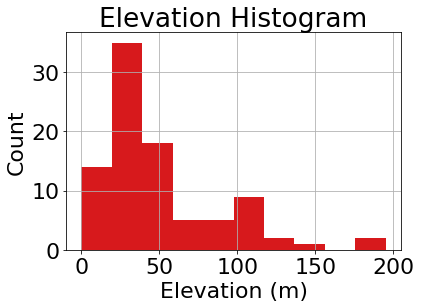

In [777]:
elevation.hist()
plt.xlabel('Elevation (m)')
plt.ylabel('Count')
plt.title('Elevation Histogram')

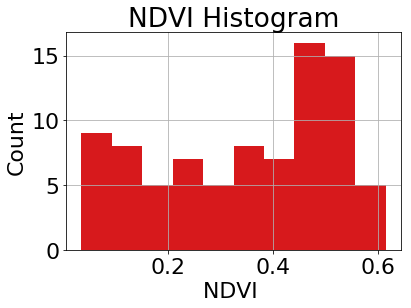

In [723]:
satellitedf['ndvi'].hist()
plt.xlabel('NDVI ')
plt.ylabel('Count')
plt.title('NDVI Histogram')

In [730]:
elevation.shape

(91,)

In [728]:
satellitedf['ndvi'].shape

(90,)

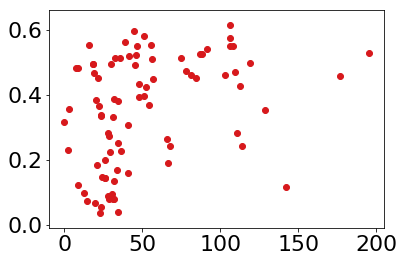

In [778]:
plt.scatter(elevation[satellitedf['ndvi'].index], satellitedf['ndvi'])

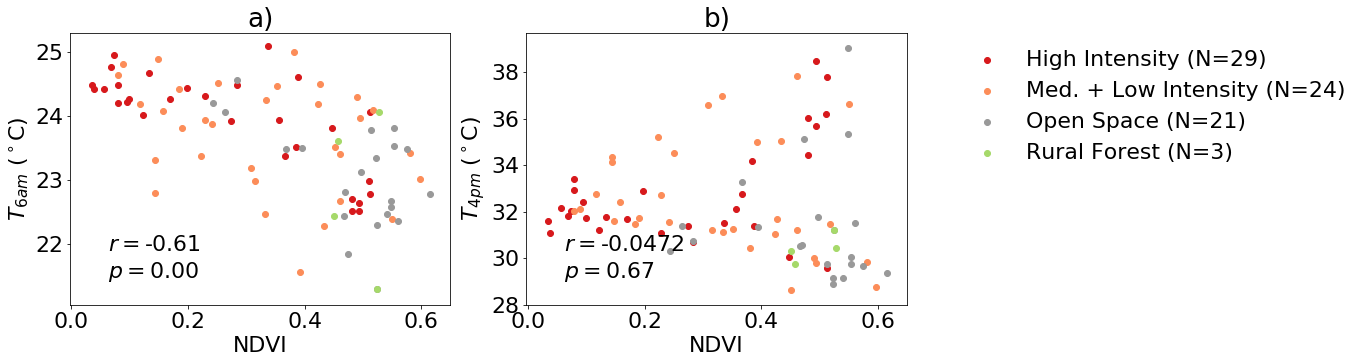

In [204]:
fig = plt.figure(figsize=[15,5])
i = 1
ax = plt.subplot(1,2,i)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
ind = ~np.isnan(x) & ~np.isnan(y)
r,p = scipy.stats.pearsonr(x[ind], y[ind])#x.dropna(), y[x.dropna().index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('$T_{6am}$ ($^\circ$C)')
ax.set_title('a)')
#ax.set_title('Elevation-corrected $T_{min}$\na)')
i = 2
ax = plt.subplot(1,2,i)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
ind = ~np.isnan(x) & ~np.isnan(y)
r,p = scipy.stats.pearsonr(x[ind], y[ind])#x.dropna(), y[x.dropna().index])
ax.annotate('$r=$%2.4f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('$T_{4pm}$ ($^\circ$C)')
#ax.set_title('Elevation-corrected $T_{max}$\nb)')
ax.set_title('b)')
plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
plt.savefig('figures/veg_elevation_corrected.eps',bbox_inches='tight')

In [889]:
elevation.describe()

count     91.000000
mean      49.708366
std       38.924711
min        0.000000
25%       23.651491
50%       34.547405
75%       65.936592
max      195.133606
Name: 0, dtype: float64

In [905]:
# elevation correlation in the morning
np.corrcoef(tempDF[tempDF.index.hour==6].mean().dropna(), elevation[tempDF[tempDF.index.hour==6].mean().dropna().index])

array([[ 1.        , -0.67507984],
       [-0.67507984,  1.        ]])

In [906]:
# elevation correlation in the afternoon
np.corrcoef(tempDF[tempDF.index.hour==16].mean().dropna(), elevation[tempDF[tempDF.index.hour==16].mean().dropna().index])

array([[ 1.        , -0.45266351],
       [-0.45266351,  1.        ]])

In [918]:
elevation.sort_values(ascending=False)

sensornumber
68     195.133606
75     176.847046
94     141.750946
73     128.807800
64     118.694748
82     113.811424
123    112.591141
127    110.472450
110    109.232605
2      107.854416
4      106.209724
144    106.156052
90     105.899117
5      103.091225
106     91.372444
63      88.374596
103     86.993736
130     84.259598
85      81.424652
9       77.947830
11      74.781677
128     67.646851
79      66.349274
74      65.523911
141     56.771053
137     55.962273
34      55.458912
31      54.215317
131     52.389637
91      52.389637
          ...    
86      27.825989
88      27.793037
139     26.021055
17      26.021055
71      25.724264
99      24.107763
47      23.725058
22      23.577925
124     23.218504
80      22.608877
35      22.358833
43      21.411997
41      21.026052
105     20.801702
24      20.297018
126     19.534195
21      18.842646
109     18.061516
122     18.061516
40      18.061516
44      15.821361
66      14.249324
102     12.281138
136      8.6825

In [921]:
tempDF[tempDF.index.hour==6].mean().sort_values()

103    20.233850
63     21.435407
130    21.494325
75     21.525456
9      21.593931
2      21.632325
3      21.671620
68     21.760489
106    21.832718
64     21.860931
5      21.862046
90     21.883128
110    22.095964
134    22.255204
19     22.299391
144    22.462182
4      22.516538
42     22.589243
85     22.670522
94     22.678735
137    22.720816
20     22.750309
13     22.864882
73     22.949948
21     22.996374
40     23.079391
132    23.159037
82     23.172997
10     23.175112
122    23.197130
         ...    
109    24.524345
108    24.590030
17     24.633472
69     24.643505
97     24.665374
22     24.767833
50     24.778259
65     24.799030
60     24.805423
107    24.817784
71     24.867341
77     24.887636
124    24.900456
88     24.908276
105    24.910718
102    24.916850
80     24.919341
131    24.932685
70     24.937309
78     24.959358
98     25.019112
62     25.101276
86     25.135030
99     25.175620
100    25.268964
126    25.278423
28     25.298489
47     25.5093

In [794]:
test_df = pd.DataFrame({'elevation': elevation[[68,75, 103, 130]], 
             'NDVI': satellitedf['ndvi'][[68,75, 103, 130]], 
            'Elevation cooling': 0.015*test_df['elevation'], 
                       'NDVI cooling':2.91*test_df['NDVI'] })
test_df[['elevation', 'NDVI', 'Elevation cooling', 'NDVI cooling']]

elevation      NDVI  Elevation cooling  NDVI cooling
68   195.133606  0.527851           2.927004      1.536048
75   176.847046  0.457631           2.652706      1.331706
103   86.993736  0.524227           1.304906      1.525501
130   84.259598  0.450265           1.263894      1.310271

In [805]:
# how many sites is cooling probably stronger due to elevation? 
satellitedf[(0.015*elevation -2.91*satellitedf['ndvi'])>0].index.shape

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(26,)

In [803]:
# how many sites is cooling from NDVI more than from elevation? 
satellitedf[(0.015*elevation -2.91*satellitedf['ndvi'])<0].index.shape

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


(59,)

In [808]:
tempDF.shape

(1464, 91)

In [796]:
(0.015*test_df['elevation'] - 2.91*test_df['NDVI'] )>0

68      True
75      True
103    False
130    False
dtype: bool

In [789]:
-0.015*test_df['elevation']

68    -2.927004
75    -2.652706
103   -1.304906
130   -1.263894
Name: elevation, dtype: float64

In [790]:
-2.91*test_df['NDVI']

68    -1.536048
75    -1.331706
103   -1.525501
130   -1.310271
Name: NDVI, dtype: float64

In [783]:
satellitedf['ndvi'][[68,75, 103, 130]]

Unnamed: 0
68     0.527851
75     0.457631
103    0.524227
130    0.450265
Name: ndvi, dtype: float64

In [721]:
elevation.describe()

count     83.000000
mean      42.299055
std       29.630410
min        0.000000
25%       22.913691
50%       31.870153
75%       52.389637
max      118.694748
Name: 0, dtype: float64

In [724]:
satellitedf['ndvi'].describe()

count    85.000000
mean      0.350287
std       0.170060
min       0.035046
25%       0.197813
50%       0.384637
75%       0.494098
max       0.615087
Name: ndvi, dtype: float64

In [928]:
elevation[vars]

sensornumber
83     0.000000
62     2.536470
97     3.095654
132    7.562119
Name: 0, dtype: float64

In [932]:
-2.9*.6

-1.74

In [930]:
vars = elevation.sort_values().index[0:4]
test_df = pd.DataFrame({'elevation': elevation[vars], 
             'NDVI': satellitedf['ndvi'][vars]})
test_df['Elevation cooling']= 0.015*test_df['elevation']
test_df['NDVI cooling'] = 2.91*test_df['NDVI']
test_df[['elevation', 'NDVI', 'Elevation cooling', 'NDVI cooling']]

elevation      NDVI  Elevation cooling  NDVI cooling
sensornumber                                                      
83             0.000000  0.315459           0.000000      0.917985
62             2.536470  0.228532           0.038047      0.665027
97             3.095654  0.356219           0.046435      1.036598
132            7.562119  0.480757           0.113432      1.399004

In [924]:
elevation.sort_values().index[0:4]

Int64Index([83, 62, 97, 132], dtype='int64', name=u'sensornumber')

In [720]:
import statsmodels.formula.api as sm

df = pd.DataFrame({"AirTemp": tempDF.resample('D').min().mean(axis=0), 
                   "Elevation": elevation, 
                   "park_distance": distance_to_park, 
                   'NDVI': satellitedf['ndvi'].astype(float), #.dropna(),
                  })

# inPark = {'grass': 1, 'impervious': 0, 'dirt':1, 'grass impervious':0, 'grass impervious dirt': 0 }
# parkyesno = np.array([inPark[x] for x in meta.loc[selected].landcoverclass])
# df['InPark'] = parkyesno

result = sm.ols(formula="AirTemp ~ Elevation + NDVI", data=df).fit()
print(result.params)
print(result.summary())

Intercept    24.679405
Elevation    -0.015560
NDVI         -2.915571
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                AirTemp   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     56.98
Date:                Wed, 02 May 2018   Prob (F-statistic):           1.05e-15
Time:                        18:50:59   Log-Likelihood:                -76.935
No. Observations:                  77   AIC:                             159.9
Df Residuals:                      74   BIC:                             166.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [690]:
df = pd.DataFrame({"AirTemp": tempDF.resample('D').max().mean(axis=0), 
                   "Elevation": elevation, 
                   "park_distance": distance_to_park, 
                   'NDVI': satellitedf['ndvi'].astype(float), #.dropna(),
                  })

# inPark = {'grass': 1, 'impervious': 0, 'dirt':1, 'grass impervious':0, 'grass impervious dirt': 0 }
# parkyesno = np.array([inPark[x] for x in meta.loc[selected].landcoverclass])
# df['InPark'] = parkyesno

result = sm.ols(formula="AirTemp ~ Elevation + NDVI", data=df).fit()
print(result.params)
print(result.summary())

Intercept    32.438744
Elevation    -0.017540
NDVI          0.195543
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                AirTemp   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.652
Date:                Wed, 02 May 2018   Prob (F-statistic):              0.199
Time:                        18:35:40   Log-Likelihood:                -177.50
No. Observations:                  77   AIC:                             361.0
Df Residuals:                      74   BIC:                             368.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

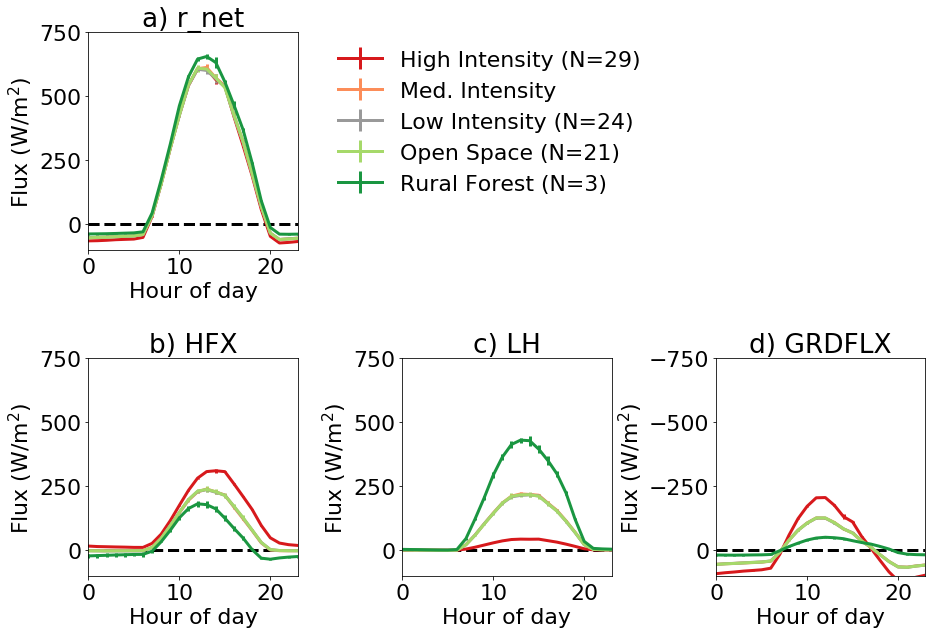

In [230]:
# SEB plots
#em = getvar(dataset_list[-1], 'EMISS')
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model_allvars = pd.read_csv('UCM+SST_d03_allpoints_allvars.csv',header = [0,1], index_col=0,
                        parse_dates = [0], 
                   date_parser = date_parser,
                       skipinitialspace=True)#[tempDF.index[0]:tempDF.index[-1]]
model_allvars.columns.set_levels(model_allvars.columns.levels[1].astype(int), level = 1, inplace = True)
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
rnet = net_lw+net_sw
labels = ['High Intensity (N=29)' ,'Med. Intensity',  'Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)']

fig = plt.figure(figsize=[15,10])
# Plot net 
ax = plt.subplot(2, 3,1)
# #netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
# netflux = rnet - model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']

# for lc in [ 26.,25,24, 23,  28.]:
# #     if lc == 25: 
# #         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
# #             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
# #     else: 
#     netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
#             linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
# plt.title('a) Rnet -LH +H -G')#Average Net Flux')
# plt.xlabel('Hour of day')
# ax.set_ylabel('Flux (W/m$^2$)')
# plt.axhline(0, color ='k', linestyle = '--')

# # plot net radiation 
# ax = plt.subplot(2,3,2)
data = model_allvars.loc[:,var]
for lc in [ 26.,25,24, 23,  28.]:
    rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('%s) %s'%(string.ascii_lowercase[i-3], var))
    ax.set_ylim([-100,750])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
ax.set_title('a) r_net')
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.axhline(0, color ='k', linestyle = '--')

#selected_vars = ['GRDFLX','LH','HFX' ]
selected_vars = ['HFX','LH', ]
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 4
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(2,3,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25, 24,23,  28.]:
#         if lc == 25: 
#             data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
#                                                                                                                 label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#         else: 
        data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s) %s'%(string.ascii_lowercase[i-3], var))
#    ax.set_title(var)
    ax.set_ylim([-100,750])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    plt.axhline(0, color ='k', linestyle = '--')

# plot ground flux
ax = plt.subplot(2, 3,6)
var = 'GRDFLX'
data = model_allvars.loc[:,var]
for lc in [ 26.,25, 24,23,  28.]:
#         if lc == 25: 
#             data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
#                                                                                                                 label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#         else: 
    data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
ax.set_title('%s) %s'%(string.ascii_lowercase[i-3], var))
#    ax.set_title(var)
ax.set_ylim([-750])
ax.set_xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
#plt.xticks([6,12,16])

#plt.ylabel(' (Wm$^{-2}$)')
plt.axhline(0, color ='k', linestyle = '--')
# want: 'R_net', 'Net LW','Sensible', 'Latent', 'Ground flux',

plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.legend(bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/SEB.eps', bbox_inches='tight')
# caption: net flux, sensible, latent heat, net radiation

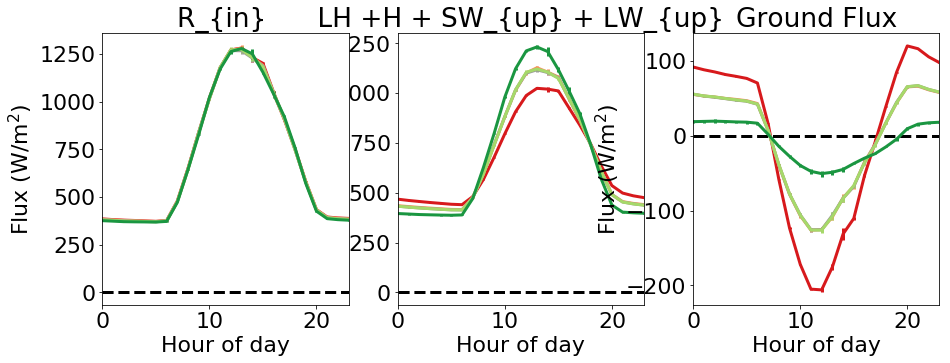

In [226]:
plt.figure(figsize = [15,5])
ax = plt.subplot(1,3,2)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux =model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'SWUPB'] + model_allvars.loc[:,'LWUPB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title(' LH +H + SW_{up} + LW_{up} ')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')


ax = plt.subplot(1,3,1)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux = model_allvars.loc[:,'SWDNB'] + model_allvars.loc[:,'LWDNB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title('R_{in} ')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')

ax = plt.subplot(1,3,3)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux =model_allvars.loc[:,'GRDFLX']#+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'SWUPB'] + model_allvars.loc[:,'LWUPB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title('Ground Flux')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')

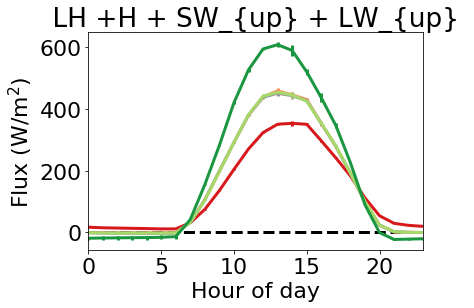

In [227]:
ax = plt.subplot(1,1,1)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux =model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX']# + model_allvars.loc[:,'SWUPB'] + model_allvars.loc[:,'LWUPB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title(' LH +H + SW_{up} + LW_{up} ')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')


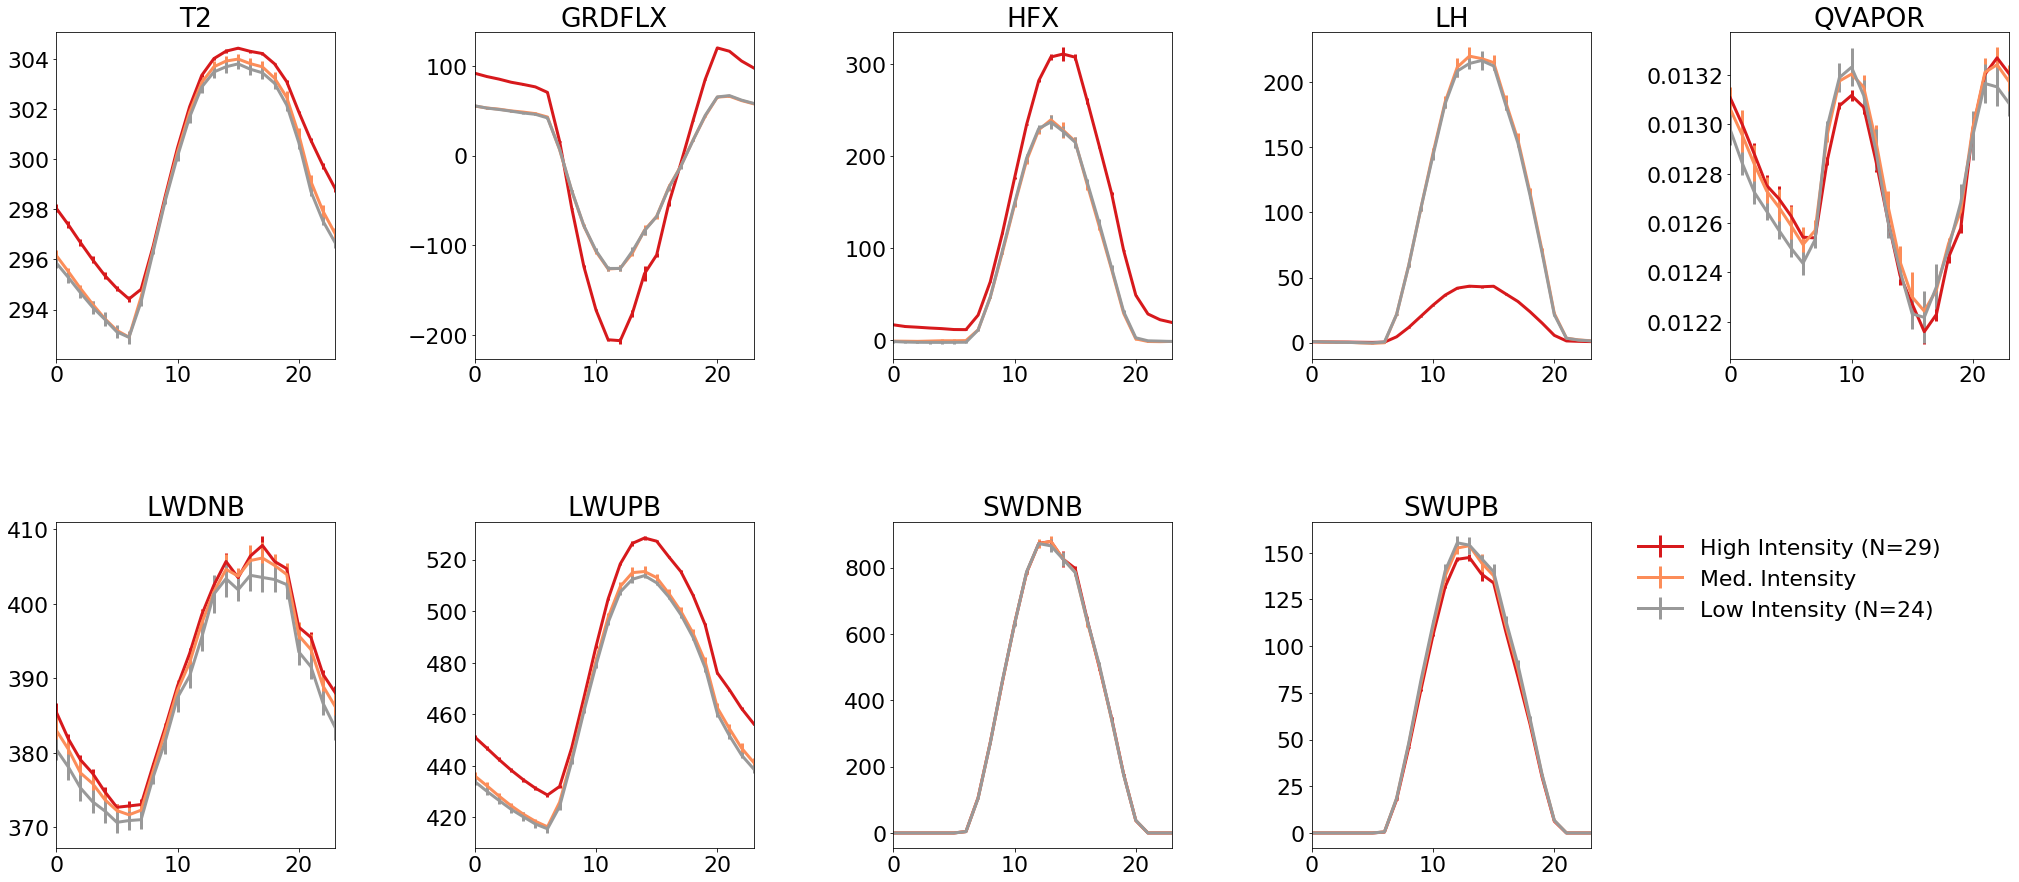

In [39]:
vars= [u'T2', 'GRDFLX', u'HFX', u'LH',u'QVAPOR', u'LWDNB', u'LWUPB',  u'SWDNB', u'SWUPB']
plt.figure(figsize = [35,15])
i =1
for var in vars: 
    ax = plt.subplot(2,5,i)
    for lc in [ 26.,25, 24]: #,23,  28.]:
#         if lc == 25: 
#             model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(yerr= model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().std(axis=1), ax=ax)
#         else: 
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s'%var)
    i = i+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)',
 'Open Space (N=21)',
 'Rural Forest (N=3)',
 'Median'], bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/all_seb_vars.eps')

Fluxes $Q$ in urban grid cells are computed using : 
$$ Q= F_{veg} \cdot Q_{veg} + F_{urban} \cdot Q_{urban}$$
where $F_{veg}$ and $F_{urban}$ are the fraction of vegetated and urban land respectively and $Q_{veg}$ and $Q_{urban}$ are the fluxes from the vegetated and urban land respectively. 
The urban fractions for low, medium, and high intensity land are 0.5, 0.9, and 0.95 respectively, meaning that the urban model contributes very little to the total fluxes in low intensity land compared to medium and high intensity lands.
The model does not save out $Q_{veg}$ and $Q_{urban}$ explicitly, but it is reasonable to assume that $Q_{veg}$ and $Q_{urban}$ are of similar magnitude. This explains why low intensity land differs from other land types. 

To explain why medium and high intensity land differs, we turn to the other parameters, including roof level, roof width, and road width. 

In [38]:
0.47*60

28.2

In [34]:
model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1)

0      -1.980006
1      -2.528372
2      -2.785627
3      -2.872789
4      -2.922914
5      -2.847047
6      -2.718730
7      10.537324
8      46.334042
9      96.736455
10    148.123193
11    197.604975
12    229.702309
13    236.681557
14    226.617817
15    214.725885
16    170.816124
17    126.064353
18     78.445772
19     30.434333
20      2.112919
21     -1.175303
22     -1.514456
23     -1.902089
dtype: float64

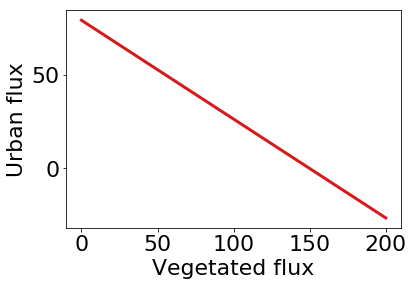

In [37]:
# H = .05*Hv + 0.95
var = 'HFX'
H = model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).mean()
Hv = np.linspace(0,200, 25)
Hu = (75-0.5*Hv)/0.95
plt.plot(Hv, Hu)
plt.xlabel('Vegetated flux')
plt.ylabel('Urban flux')

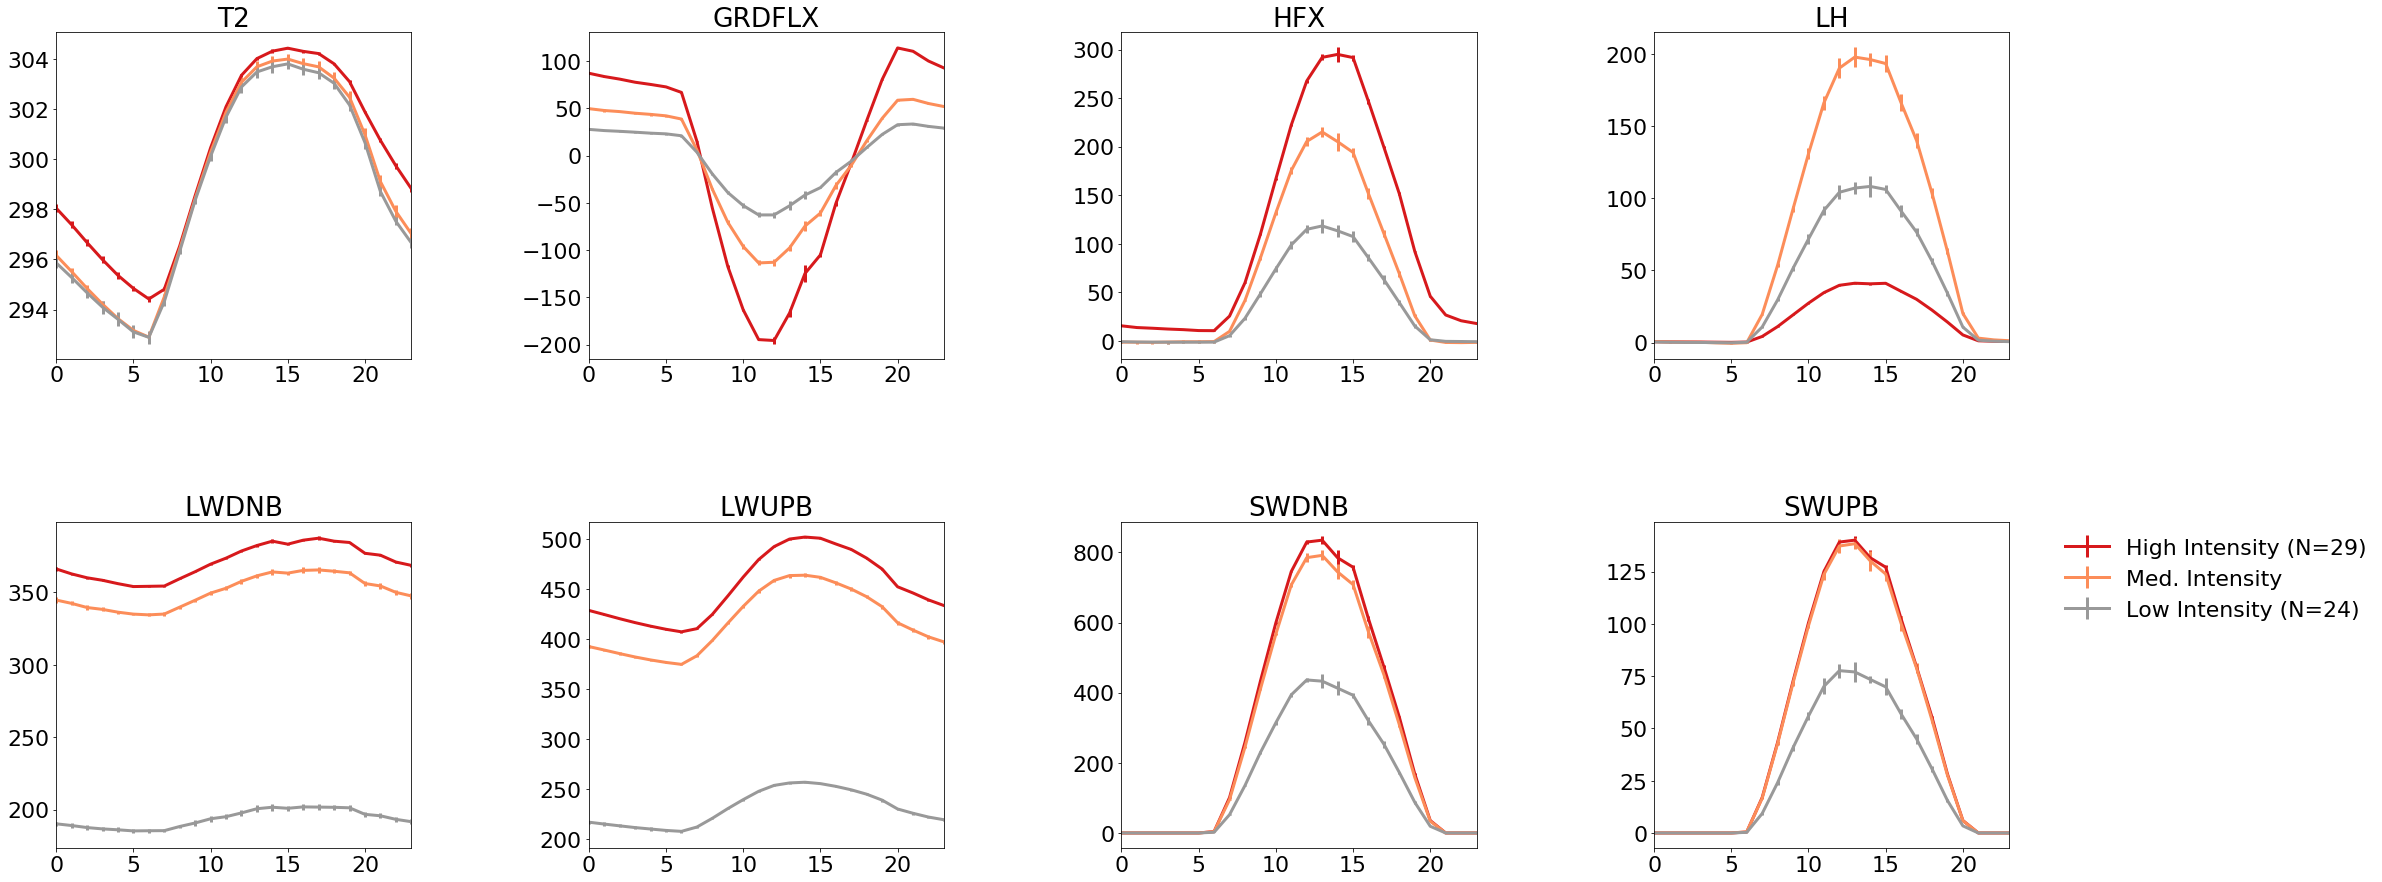

In [40]:
plt.figure(figsize = [35,15])
i = 1
var = 'T2'
ax = plt.subplot(2,4,i)
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
ax.set_title('%s'%var)
i =i+1
vars= [ 'GRDFLX', u'HFX', u'LH', u'LWDNB', u'LWUPB',  u'SWDNB', u'SWUPB']
for var in vars: 
    ax = plt.subplot(2,4,i)
    for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
#         if lc == 25: 
#             model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(yerr= model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().std(axis=1), ax=ax)
#         else: 
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).multiply(f_urban).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s'%var)
    i = i+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)'], bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/all_seb_vars_times_urban_fraction.eps')

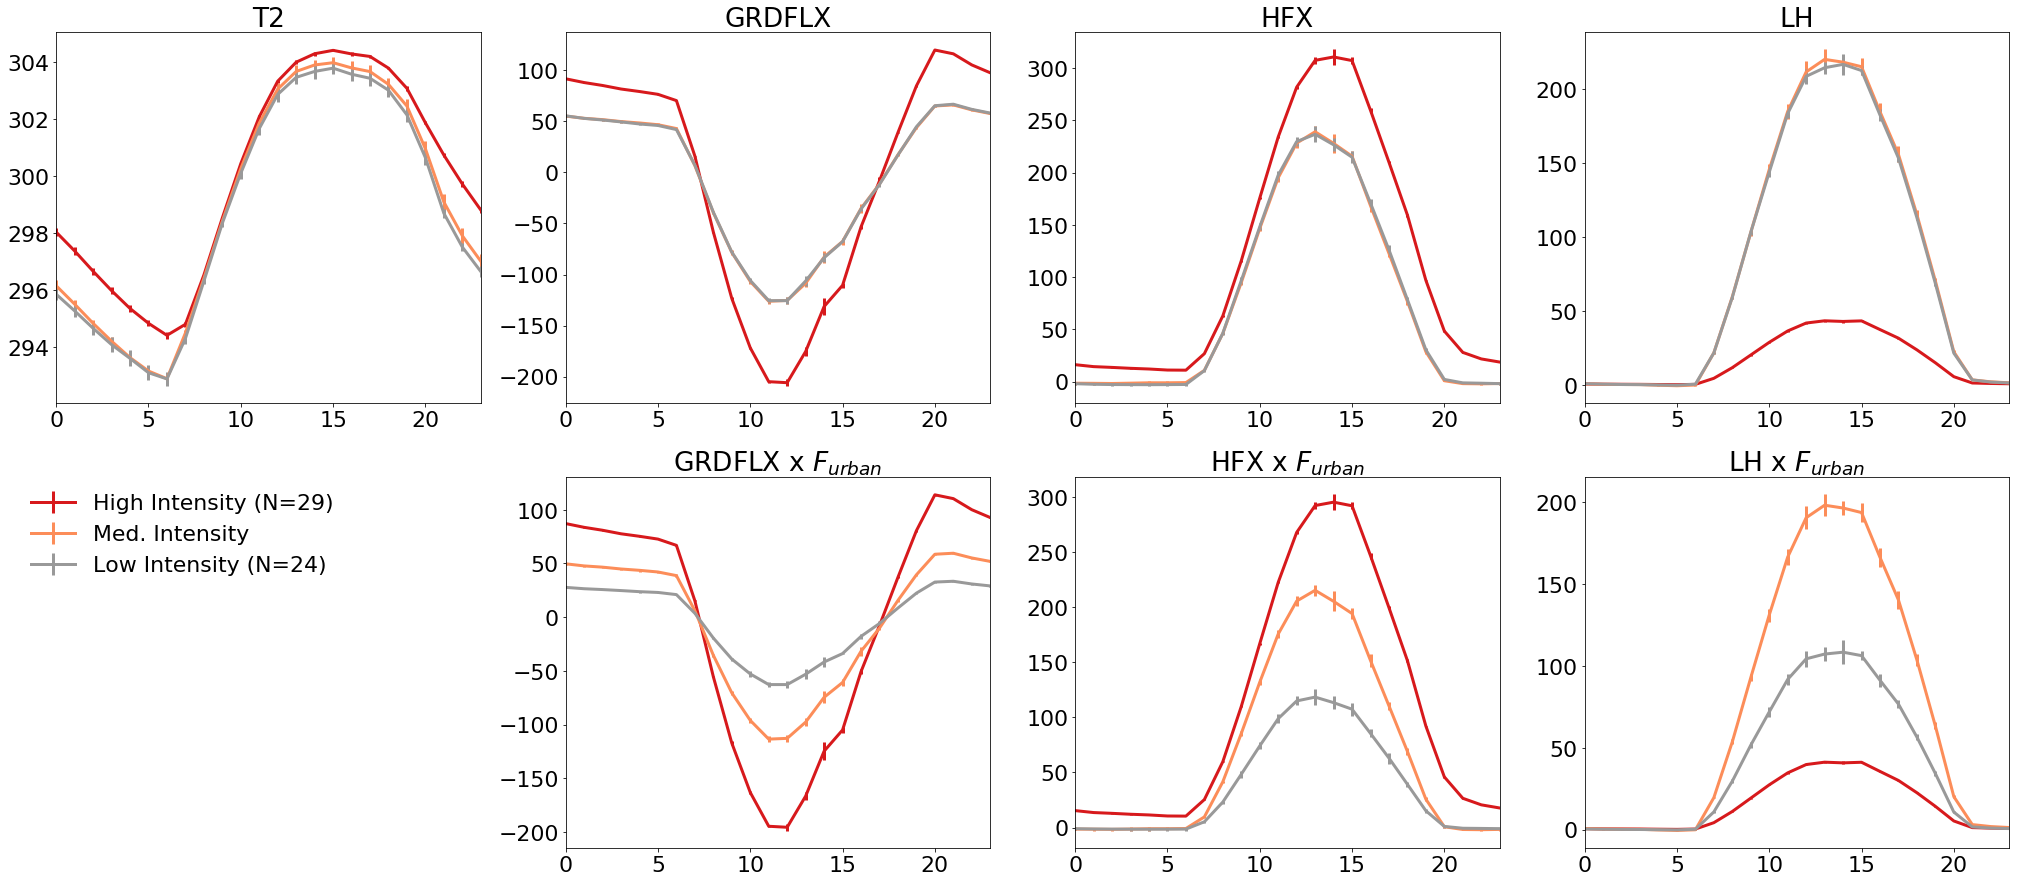

In [53]:
plt.figure(figsize = [35,15])
i = 1
var = 'T2'
ax = plt.subplot(2,4,i)
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
ax.set_title('%s'%var)
i =i+1

vars= ['GRDFLX', u'HFX', u'LH',]#u'QVAPOR', u'LWDNB', u'LWUPB',  u'SWDNB', u'SWUPB']
for var in vars: 
    ax = plt.subplot(2,4,i)
    for lc in [ 26.,25, 24]: #,23,  28.]:
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s'%var)
    i = i+1
    
i = i+1

for var in vars: 
    ax = plt.subplot(2,4,i)
    for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).multiply(f_urban).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s x $ F_{urban}$'%var)
    i = i+1
    
ax = plt.subplot(2,4,6)    
plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)'], bbox_to_anchor=(-0.5, 1.01), frameon=False)
plt.savefig('figures/group_meeting_may9.eps')

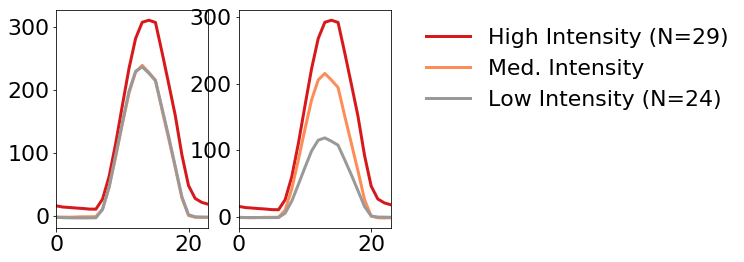

In [31]:
ax = plt.subplot(1,2,1)
var = 'HFX'
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax)
ax = plt.subplot(1,2,2)
var = 'HFX'
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).multiply(f_urban).plot(ax=ax)


plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)'], bbox_to_anchor=(1.1, 1.01), frameon=False)

- Differences in water fluxes, may explain variability between sites 
- little difference between SW down except for high intensity, could be sky view fraction? 
- 

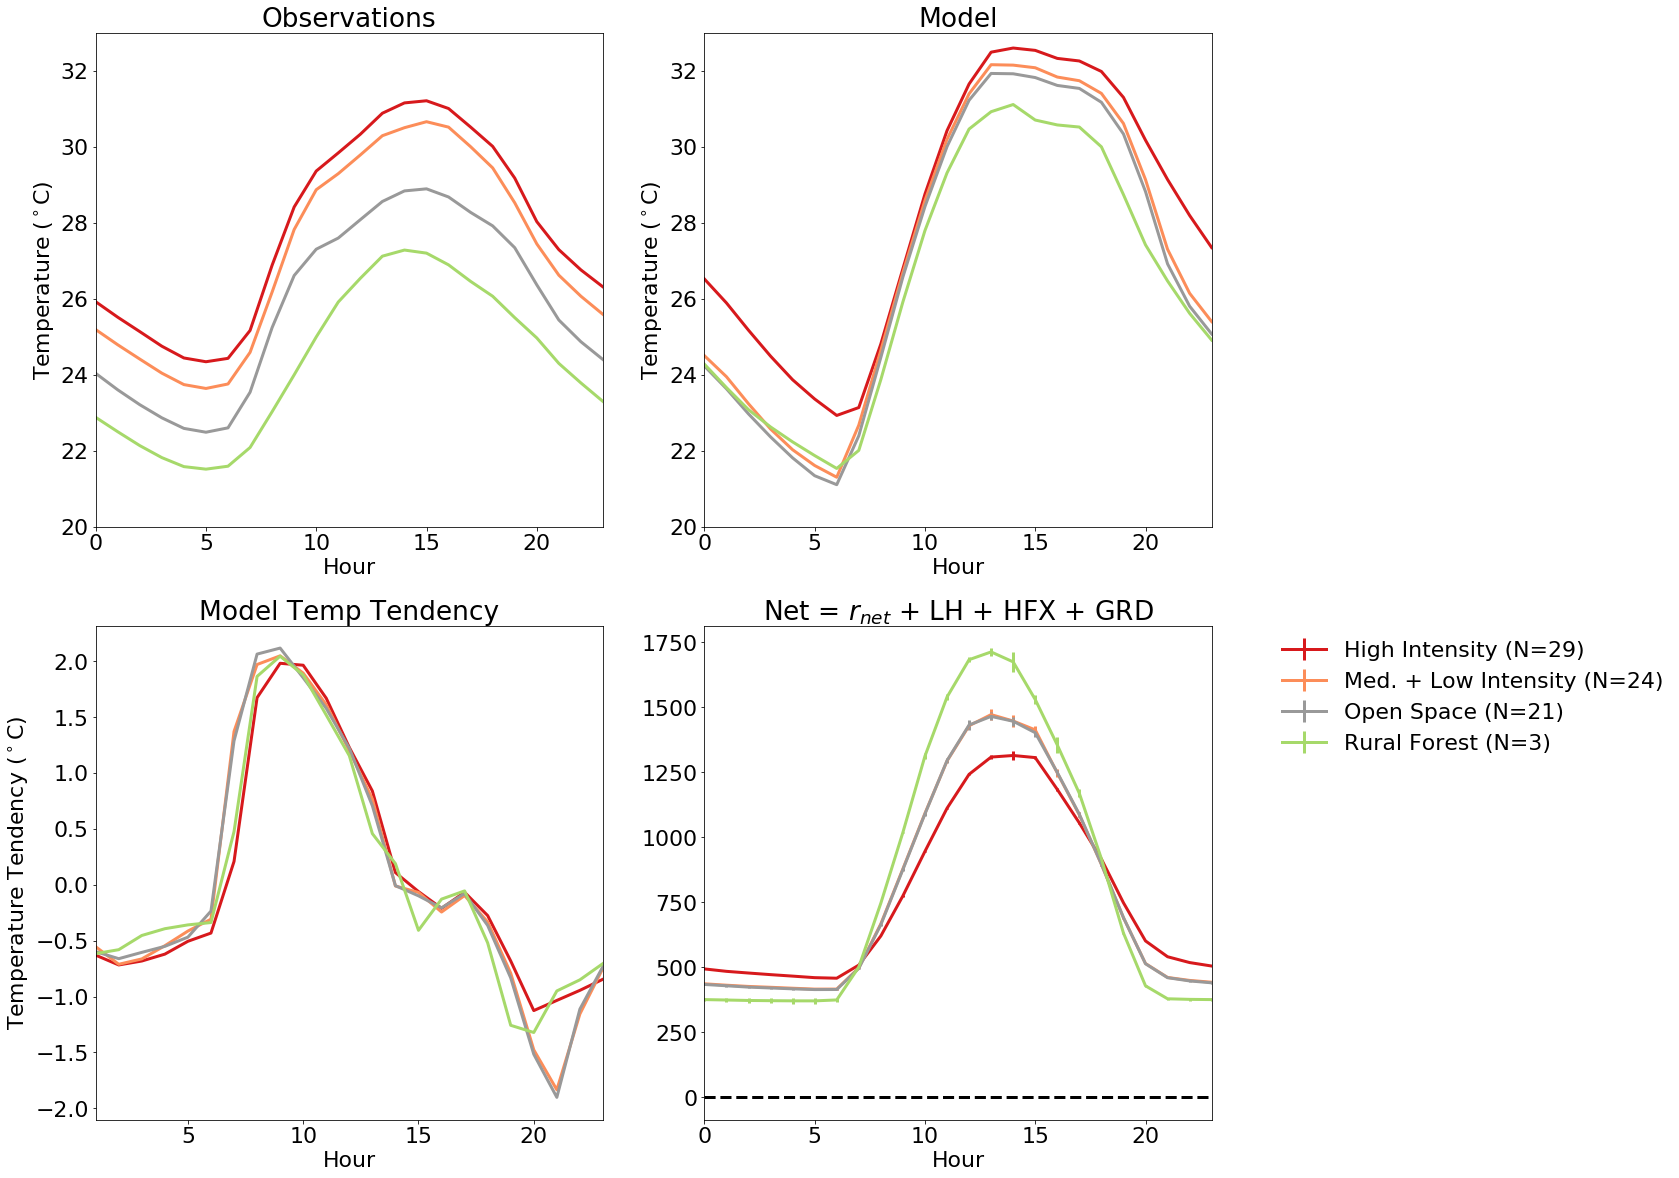

In [289]:
# group meeting slide 
# Temperature, temperature tendency, Flux 

rnet = model_allvars['LWDNB']+net_sw
netflux = rnet + model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']

plt.figure(figsize=[20,20])
ax = plt.subplot(2,2,1)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', 'Urban Forest (N=16)']
#plt.legend(labels, bbox_to_anchor=(2.2, 1.01),loc=2,frameon=False)
ax.set_title('Observations')

ax = plt.subplot(2,2,2)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
ax.set_title('Model')

ax = plt.subplot(2,2,3)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        diurnal = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
    (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values)).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model')
ax.set_ylabel('Temperature Tendency ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_xlabel('Hour')
ax.set_title('Model Temp Tendency')


ax = plt.subplot(2,2,4)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('Net = $r_{net}$ + LH + HFX + GRD')
#plt.savefig('figures/group_meetingApr11.eps', bbox_inches='tight')

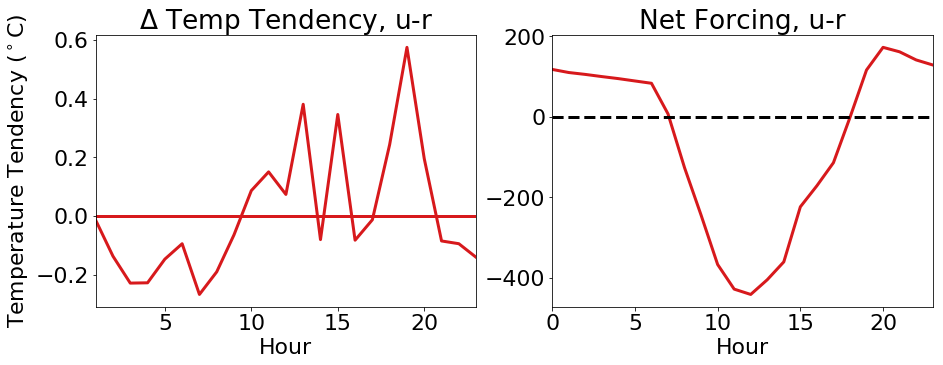

In [292]:
plt.figure(figsize = [15,5])
ax = plt.subplot(1,2,1)
lc = 26
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dT1 = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
lc = 28
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dT2 = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
(dT1-dT2).plot()
ax.set_title('Model')
ax.set_ylabel('Temperature Tendency ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_xlabel('Hour')
ax.set_title('$\Delta$ Temp Tendency, u-r')
ax.axhline(0)

ax = plt.subplot(1,2,2)
rnet = model_allvars['LWDNB']+net_sw
netflux = rnet + model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']
lc = 26
nf1 = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)
lc = 28 
nf2 = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)
(nf1-nf2).plot()
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('Net Forcing, u-r')
#plt.savefig('figures/group_meetingApr11.eps', bbox_inches='tight')

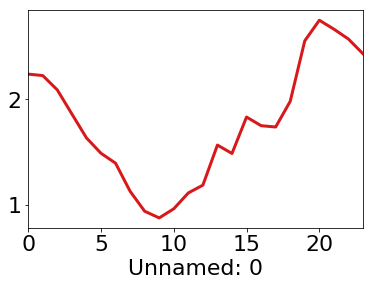

In [294]:
lc = 26
t1 = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
lc = 28 
t2 = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
(t1-t2).plot()
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
ax.set_title('Model')


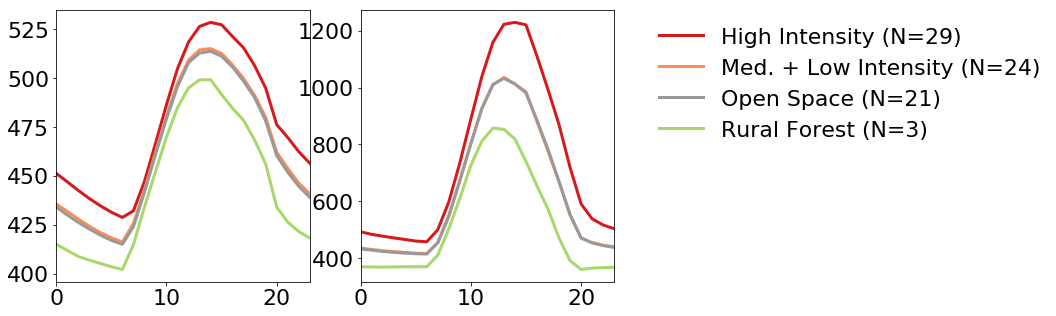

In [319]:
plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        model_allvars['LWUPB'][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(#yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        model_allvars['LWUPB'][lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot()#yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 

netflux = rnet -model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']
plt.subplot(1,2,2)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(#yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot()#yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)


In [ ]:
netflux

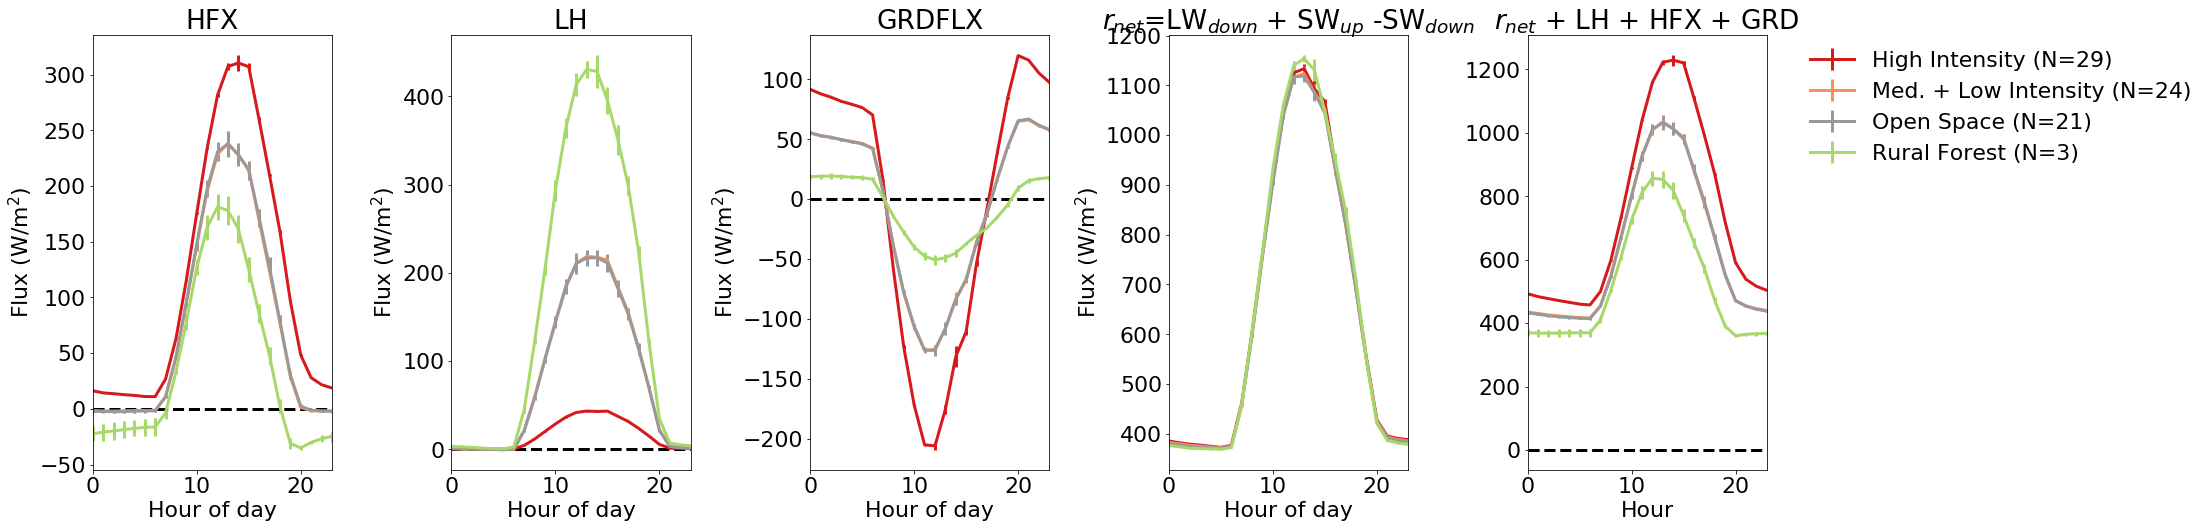

In [312]:
selected_vars = ['HFX','LH','GRDFLX' ]
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
#rnet = net_lw+net_sw
rnet = model_allvars['LWDNB']+net_sw
netflux = rnet - model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']


plt.figure(figsize=[30,8])
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 1
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(1,5,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_title(var)
    #ax.set_ylim([-100,675])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    plt.axhline(0, color ='k', linestyle = '--')
    

ax = plt.subplot(1,5,4)
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('$r_{net}$=LW$_{down}$ + SW$_{up}$ -SW$_{down}$')#%s)'%(string.ascii_lowercase[i-3]))
    #ax.set_ylim([-100,675])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')

ax = plt.subplot(1,5,5)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('$r_{net}$ + LH + HFX + GRD')
plt.subplots_adjust(wspace =0.5)

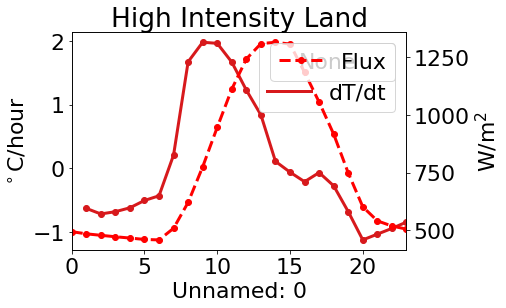

In [299]:
lc = 26 
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dTdt = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
flux = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)

dTdt.plot(style = '-o', label = 'Temp Tendency', )
plt.legend(['dT/dt'], loc=1)
plt.ylabel('$^\circ$C/hour')
flux.plot(secondary_y = True, style = '--or', label = 'Flux')
plt.ylabel('W/m$^2$')
plt.legend(loc=1)
plt.title('High Intensity Land')
plt.xlabel('Hour')
plt.savefig('figures/group_meetingApr11_extra.eps', bbox_inches='tight')

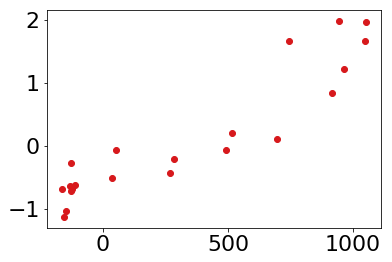

In [836]:
lag = 3
plt.scatter(flux.iloc[lag:].values, dTdt[0:-lag+1].values)
plt.title('')

In [808]:
lag

1

In [826]:
lag

2

In [827]:
flux.iloc[lag:].shape

(22,)

In [828]:
dTdt[0:-lag+1].shape

(22,)

In [835]:
print(np.corrcoef(flux.iloc[1:].values, dTdt.values)[0,1])
for lag in range(2,5) : 
    print(np.corrcoef(flux.iloc[lag:].values, dTdt[0:-lag+1].values)[0,1])

0.697461578047
0.846086088951
0.922076955076
0.906947707673


In [825]:
np.corrcoef(flux.iloc[lag:].values, dTdt.values)[0,1]
for lag in range(2,5) : 
    np.corrcoef(flux.iloc[lag:].values, dTdt[0:-lag+1].values)[0,1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

array([[ 1.        ,  0.65240929],
       [ 0.65240929,  1.        ]])

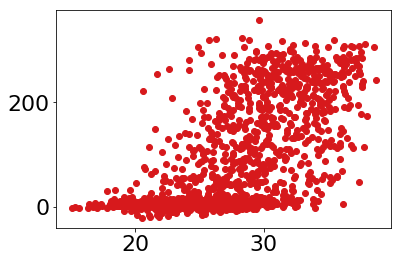

In [309]:
beta = model_allvars['HFX']
plt.scatter(model.mean(axis=1), beta[model.index[0]:model.index[-1]].mean(axis=1))
np.corrcoef(model.mean(axis=1).dropna(), beta[model.index[0]:model.index[-1]].mean(axis=1).dropna())

array([[ 1.        ,  0.67561591],
       [ 0.67561591,  1.        ]])

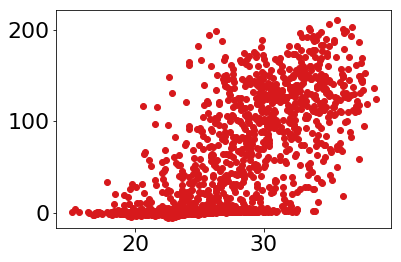

In [311]:
beta = model_allvars['LH']
plt.scatter(model.mean(axis=1).dropna(), beta[model.index[0]:model.index[-1]].mean(axis=1).dropna())
np.corrcoef(model.mean(axis=1).dropna(), beta[model.index[0]:model.index[-1]].mean(axis=1).dropna())

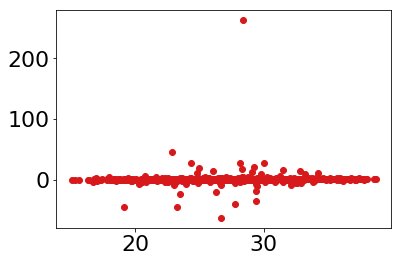

In [306]:
beta = model_allvars['LH']/model_allvars['HFX']
plt.scatter(model.mean(axis=1), beta[model.index[0]:model.index[-1]].mean(axis=1))

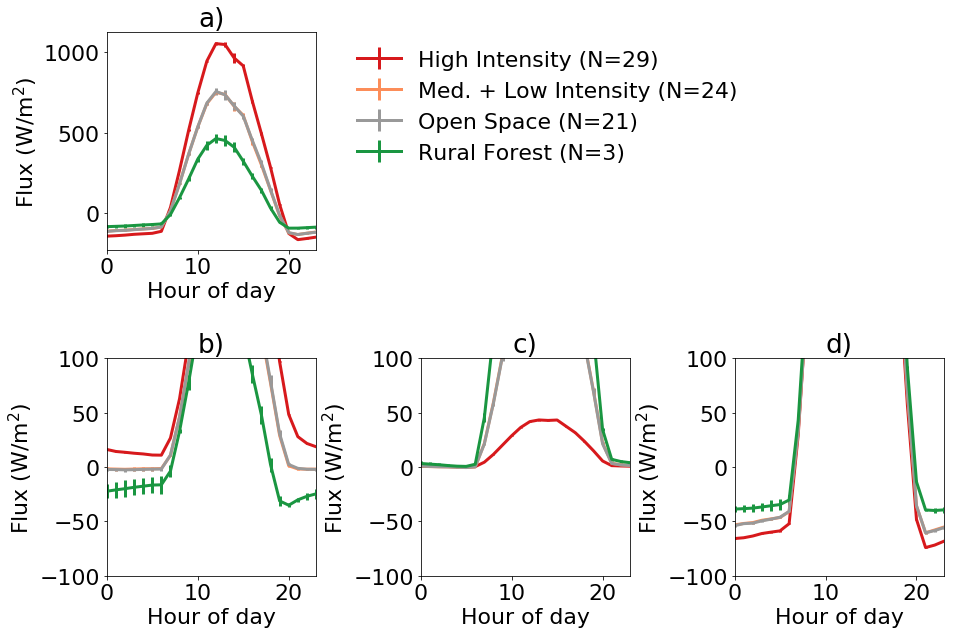

In [789]:
fig = plt.figure(figsize=[15,10])
ax = plt.subplot(2, 3,1)
netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
#plt.xticks([6,12,16])
plt.title('a)')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
#plt.ylabel(' (Wm$^{-2}$)')

# want: 'R_net', 'Net LW','Sensible', 'Latent', 'Ground flux',
#selected_vars = ['GRDFLX','LH','HFX' ]
selected_vars = ['HFX','LH', ]
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 4
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(2,3,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
#    ax.set_title(var)
    ax.set_ylim([-100,100])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    
#ax = plt.subplot(1, 4,i)
ax = plt.subplot(2,3,i)
data = model_allvars.loc[:,var]
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_ylim([-100,100])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')

#ax.set_title('r_net')
plt.subplots_adjust(hspace=.5,wspace =0.5)

In [570]:
em = getvar(Dataset(files[0]), "ALBBCK")
emm = np.diagonal(em.isel(west_east = all_pts.values[0], south_north = all_pts.values[1]), axis1=0,axis2=1)
emissivity = pd.DataFrame(emm, index = meta['location:Latitude'].dropna().index.astype('int64') )
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = emissivity.loc[lcc[lcc.LCC==lc].index].mean().values
    std = emissivity.loc[lcc[lcc.LCC==lc].index].std().values
    print('Albedo : LCC = %i, mean = %2.2f, std = %2.2f'%(lc, mean, std))

Albedo : LCC = 26, mean = 0.10, std = 0.00
Albedo : LCC = 25, mean = 0.10, std = 0.00
Albedo : LCC = 24, mean = 0.11, std = 0.00
Albedo : LCC = 23, mean = 0.12, std = 0.00
Albedo : LCC = 28, mean = 0.15, std = 0.00


In [384]:
em = getvar(Dataset(files[0]), "EMISS")
emm = np.diagonal(em.isel(west_east = all_pts.values[0], south_north = all_pts.values[1]), axis1=0,axis2=1)
emissivity = pd.DataFrame(emm, index = meta['location:Latitude'].dropna().index.astype('int64') )
emissivity

0
sensornumber      
82            0.97
139           0.90
130           0.93
32            0.97
10            0.88
129           0.97
105           0.90
80            0.88
34            0.97
71            0.88
35            0.88
106           0.97
91            0.90
19            0.90
42            0.97
27            0.88
5             0.90
88            0.88
72            0.90
70            0.88
40            0.88
132           0.88
48            0.90
33            0.88
54            0.90
102           0.88
124           0.88
127           0.97
64            0.97
79            0.90
...            ...
73            0.95
41            0.97
103           0.97
123           0.95
50            0.90
108           0.88
12            0.90
100           0.90
137           0.88
77            0.88
22            0.90
90            0.97
31            0.97
92            0.90
2             0.97
110           0.97
11            0.97
141           0.88
126           0.88
78            0.88
62            0.88
24            0.88
75            0.93
65            0.88
85            0.95
29            0.88
144           0.97
21            0.97
134           0.95
44            0.97

[86 rows x 1 columns]

In [413]:
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = emissivity.loc[lcc[lcc.LCC==lc].index].mean().values
    std = emissivity.loc[lcc[lcc.LCC==lc].index].std().values
    print('LCC = %i, mean = %2.2f, std = %2.2f'%(lc, mean, std))

LCC = 26, mean = 0.88, std = 0.00
LCC = 25, mean = 0.90, std = 0.00
LCC = 24, mean = 0.95, std = 0.00
LCC = 23, mean = 0.97, std = 0.00
LCC = 28, mean = 0.93, std = 0.00


In [418]:
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = vff.loc[lcc[lcc.LCC==lc].index].mean().values
    std = vff.loc[lcc[lcc.LCC==lc].index].std().values
    print('LCC = %i, mean VF = %2.2f, std = %2.2f'%(lc, mean, std))

LCC = 26, mean VF = 24.53, std = 29.72
LCC = 25, mean VF = 50.75, std = 28.27
LCC = 24, mean VF = 77.44, std = 12.00
LCC = 23, mean VF = 61.81, std = 32.61
LCC = 28, mean VF = 78.80, std = 3.44


In [568]:
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
ds = Dataset(files[0])
all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
                        meta['location:Longitude'].dropna().values)

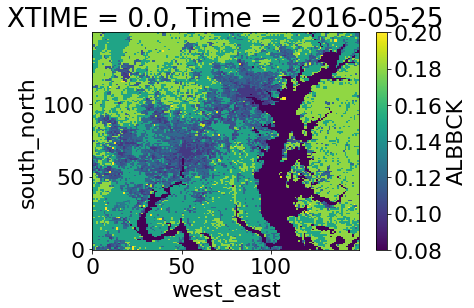

In [567]:
albedo = getvar(ds, "ALBBCK")
albedo.plot()

In [ ]:
albedo.

(<xarray.DataArray u'xy' ()>
 array(10)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.29813979, lon=-76.69014149)
     x_y           <U1 u'y', <xarray.DataArray u'xy' ()>
 array(308)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.28520643, lon=-76.54833725)
     x_y           <U1 u'y')

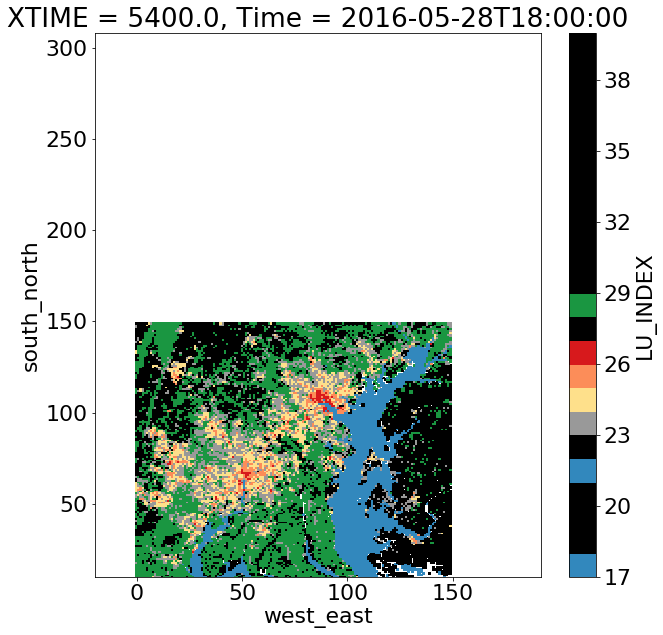

In [720]:
# Fig. 1: A map with insets, some points
# exp = 'UCM+SST'
# dom = 'd03'
# fpath = home_dir + '/mountpoint/wrf/out/'
# files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
# ds = Dataset(files[30*3])
# lu = getvar(ds, "LU_INDEX")
# all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
#                        meta['location:Longitude'].dropna().values)
color_dict ={26.: '#d7191c',
             25 : '#fc8d59',
             24: '#fee08b', #'yellow',
             23: '#999999',
             28: '#1a9641', 
             21: '#3288bd',
             17: '#3288bd'
            }
cmap = ['k' for x in range(17,40)]
#cmap = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30', '#762a83','#af8dc3','#e7d4e8',]

for x in color_dict.keys(): 
    x = int(x)
    cmap[x-17] = color_dict[x]
#lu.plot(levels = 24, cmap  = cm.tab20, figsize = [10,10])
lu.plot(levels = 24,  
        cmap = cmap, 
        vmin = 17, vmax =40, figsize = [10,10])
#plt.scatter(all_pts[0], all_pts[1], marker = '^', color = 'k')
# plt.xlim(pts[0].values)
# plt.ylim(pts[1].values)
plt.xlim(pts[0][0]-100, pts[0][1]+100)
plt.ylim(pts[1][0]-100, pts[1][1]+200)

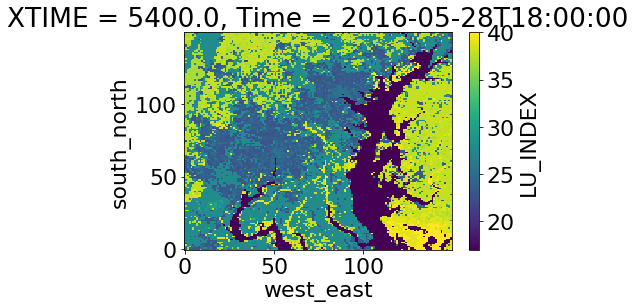

In [721]:
fig = plt.figure()
ax = plt.subplot(1,3,1) 
lu.plot()
ax = plt.subplot(1,3,2) 


In [724]:
ds.variables

OrderedDict([(u'Times', <type 'netCDF4._netCDF4.Variable'>
              |S1 Times(Time, DateStrLen)
              unlimited dimensions: Time
              current shape = (1, 19)
              filling on, default _FillValue of   used),
             (u'XLAT', <type 'netCDF4._netCDF4.Variable'>
              float32 XLAT(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LATITUDE, SOUTH IS NEGATIVE
                  units: degree_north
                  stagger: 
                  coordinates: XLONG XLAT
              unlimited dimensions: Time
              current shape = (1, 150, 150)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'XLONG', <type 'netCDF4._netCDF4.Variable'>
              float32 XLONG(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LONGITUDE, WEST IS NEGATIVE
           